# Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as st
import math
import seaborn as sns
import dataframe_image as dfi

from fitter import Fitter, get_common_distributions, get_distributions
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.core.display import HTML
import themepy
#import warnings
#warnings.filterwarnings("ignore")

# Pobranie czcionek

In [26]:
def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

# Ustawienie stylu

In [100]:
theme = themepy.Theme()

theme.set_theme() # ensures set to default matplotlib rcParams

(theme
 .set_font("FreeSans", color="black") # sets default font and text color
 .set_pips(False) # turns off tick lines
 .set_spines("off", which=[], color="black") # turns off top and right ax borders & sets color of others to white
 .set_background("white") # sets the fig, axis, and savefig facecolors
 .set_ticklabel_size(14) # sets size of tick labels
 .set_plot_colors("#DC5349","#26D8FF","#D3CFBD")  # sets first three colors of cycler and also colors of theme.primary_color, theme.secondary_color, and theme.tertiary_color
)
theme.add_theme("arek")
theme.set_theme("arek")

A theme named arek already exists, would you like to overwrite? [y/n]y
Theme arek successfully overwritten


arek is the active theme

# Import baz danych i wstępny przegląd.

In [4]:
df = pd.read_csv("../loading/results.csv")
#df = df.astype({"date": 'datetime64[ns]'})
#dfi.export(df.tail(5), 'df1.png')
df.tail(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False
43420,2022-03-30,Solomon Islands,New Zealand,0,5,FIFA World Cup qualification,Doha,Qatar,True


In [3]:
df_karne = pd.read_csv("shootouts.csv")
#df_karne = df_karne.astype({"date": 'datetime64[ns]'})
#dfi.export(df_karne.tail(5), 'df2.png')
df_karne.tail(5)

,date,home_team,away_team,winner
452,2022-01-26,Mali,Equatorial Guinea,Equatorial Guinea
453,2022-02-03,Cameroon,Egypt,Egypt
454,2022-02-05,Cameroon,Burkina Faso,Cameroon
455,2022-02-06,Senegal,Egypt,Senegal
456,2022-03-29,Senegal,Egypt,Senegal


# Usuwanie brakujących danych.

In [5]:
df = df.dropna()
df_markovian = df.copy()
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False


# Stworzenie bazy z meczami zakończonymi rzutami karnymi

In [5]:
df_penalty = pd.merge(left=df, right=df_karne, how='left', left_on=['date', 'home_team', 'away_team'], right_on=['date', 'home_team', 'away_team'])
df_penalty#[df_penalty['winner'].notnull()]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,NaN
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,NaN
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,NaN
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,NaN
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,NaN
...,...,...,...,...,...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False,NaN
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False,NaN
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False,NaN
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False,NaN


# Stworzenie funkcji estymującej wyniki oraz liczącej ranking FIFA 1993-1998.

In [7]:
df93 = df[df['date']>='2000-01-01'].copy()

df93["diff"] = df93["home_score"] - df93["away_score"]

conditions = [
    (df93["diff"] > 0),
    (df93["diff"] == 0),
    (df93["diff"] < 0)
    ]

values1 = [3,1,0]
values2 = [0,1,3]
values = [1,0.5,0]

df93["W_home"] = np.select(conditions, values1)
df93["W_away"] = np.select(conditions, values2)
df93["W"] = np.select(conditions, values)
                    
def estymuj93(df, importance, sensitivity, home_buff):
    unique1 = pd.unique(df["home_team"])
    unique2 = pd.unique(df["away_team"])
    unique_countries = np.unique(np.concatenate((unique1,unique2),0))
    
    ranking = dict()
    for i in unique_countries:
        ranking[i] = 0
     
    #ilosc_dobrych_val = 0
    #ilosc_dobrych_test = 0
    
    for i, row in df.iterrows():
        rank_home_before = ranking[df.loc[i,"home_team"]]
        rank_away_before = ranking[df.loc[i,"away_team"]]
        
        if(df.loc[i,'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance**(-(rank_home_before-rank_away_before+home_buff)/sensitivity)) #+np.log10(2)
        else:
            df.loc[i,"We_home"] = 1/(1+importance**(-(rank_home_before-rank_away_before)/sensitivity))
            
        ranking[df.loc[i,"home_team"]] = ranking[df.loc[i,"home_team"]] + df.loc[i,"W_home"]
        ranking[df.loc[i,"away_team"]] = ranking[df.loc[i,"away_team"]] + df.loc[i,"W_away"]
    
#     for i, row in df.tail(8000).head(4000).iterrows():
#         if((df.tail(8000).head(4000).loc[i,"W_home"]==3 and df.tail(8000).head(4000).loc[i,"We_home"]>0.5) or
#            (df.tail(8000).head(4000).loc[i,"W_home"]==0 and df.tail(8000).head(4000).loc[i,"We_home"]<0.5)):
#             ilosc_dobrych_val += 1
#     score_val = round(ilosc_dobrych_val/len(df.tail(8000).head(4000)[df.tail(8000).head(4000)["W_home"] != 1]),5)
    
#     for i, row in df.tail(4000).iterrows():
#         if((df.loc[i,"W_home"]==3 and df.loc[i,"We_home"]>0.5) or
#            (df.loc[i,"W_home"]==0 and df.loc[i,"We_home"]<0.5)):
#             ilosc_dobrych_test += 1
#     score_test = round(ilosc_dobrych_test/len(df.tail(4000)[df.tail(4000)["W_home"] != 1]),5)
    
    #df["W_home-We_home"] = df["W_home"]-df["We_home"]
    df["W-We_home"] = df["W"]-df["We_home"]
    return(df, ranking)   #, score_val, score_test 

In [8]:
rezultaty93 = []
progres = 1

for sensitivity in range(100, 625, 25):
    for buff in range(0, 105, 5):
        df_est, _ = estymuj93(df93, 10, sensitivity, buff) #, score_val, score_test
        mse_val = round(np.sum(df_est["W-We_home"].tail(8000).head(4000)**2/4000),5)
        mse_test = round(np.sum(df_est["W-We_home"].tail(4000)**2/4000),5)
        
        rezultaty93.append([sensitivity, buff, mse_val, mse_test]) #, score_val, score_test

        print("Progres: ", progres, "/400\n", [sensitivity, buff, mse_val, mse_test]) #, score_val, score_test
        progres = progres+1
            
skutecznosc93 = pd.DataFrame(rezultaty93, columns=['sensitivity', 'buff', 'MSEval', 'MSEtest']) #, 'SCOREval', 'SCOREtest'

Progres:  1 /400
 [100, 0, 0.19873, 0.20224]
Progres:  2 /400
 [100, 5, 0.19705, 0.20065]
Progres:  3 /400
 [100, 10, 0.19555, 0.19921]
Progres:  4 /400
 [100, 15, 0.19423, 0.19791]
Progres:  5 /400
 [100, 20, 0.1931, 0.19674]
Progres:  6 /400
 [100, 25, 0.19214, 0.19572]
Progres:  7 /400
 [100, 30, 0.19136, 0.19484]
Progres:  8 /400
 [100, 35, 0.19076, 0.19408]
Progres:  9 /400
 [100, 40, 0.19033, 0.19347]
Progres:  10 /400
 [100, 45, 0.19008, 0.19298]
Progres:  11 /400
 [100, 50, 0.18999, 0.19261]
Progres:  12 /400
 [100, 55, 0.19007, 0.19237]
Progres:  13 /400
 [100, 60, 0.19031, 0.19224]
Progres:  14 /400
 [100, 65, 0.1907, 0.19223]
Progres:  15 /400
 [100, 70, 0.19124, 0.19233]
Progres:  16 /400
 [100, 75, 0.19192, 0.19253]
Progres:  17 /400
 [100, 80, 0.19274, 0.19283]
Progres:  18 /400
 [100, 85, 0.19368, 0.19322]
Progres:  19 /400
 [100, 90, 0.19474, 0.19371]
Progres:  20 /400
 [100, 95, 0.19591, 0.19429]
Progres:  21 /400
 [100, 100, 0.19719, 0.19495]
Progres:  22 /400
 [125, 

Progres:  176 /400
 [300, 35, 0.15436, 0.15207]
Progres:  177 /400
 [300, 40, 0.15387, 0.15157]
Progres:  178 /400
 [300, 45, 0.15347, 0.15115]
Progres:  179 /400
 [300, 50, 0.15315, 0.15079]
Progres:  180 /400
 [300, 55, 0.15291, 0.15051]
Progres:  181 /400
 [300, 60, 0.15274, 0.15029]
Progres:  182 /400
 [300, 65, 0.15265, 0.15013]
Progres:  183 /400
 [300, 70, 0.15264, 0.15005]
Progres:  184 /400
 [300, 75, 0.1527, 0.15003]
Progres:  185 /400
 [300, 80, 0.15283, 0.15007]
Progres:  186 /400
 [300, 85, 0.15304, 0.15018]
Progres:  187 /400
 [300, 90, 0.15332, 0.15035]
Progres:  188 /400
 [300, 95, 0.15366, 0.15058]
Progres:  189 /400
 [300, 100, 0.15407, 0.15087]
Progres:  190 /400
 [325, 0, 0.1592, 0.15604]
Progres:  191 /400
 [325, 5, 0.15818, 0.1551]
Progres:  192 /400
 [325, 10, 0.15725, 0.15422]
Progres:  193 /400
 [325, 15, 0.15638, 0.1534]
Progres:  194 /400
 [325, 20, 0.15559, 0.15265]
Progres:  195 /400
 [325, 25, 0.15488, 0.15197]
Progres:  196 /400
 [325, 30, 0.15424, 0.1513

Progres:  348 /400
 [500, 55, 0.15307, 0.14778]
Progres:  349 /400
 [500, 60, 0.15275, 0.14747]
Progres:  350 /400
 [500, 65, 0.15246, 0.14719]
Progres:  351 /400
 [500, 70, 0.15221, 0.14695]
Progres:  352 /400
 [500, 75, 0.152, 0.14675]
Progres:  353 /400
 [500, 80, 0.15182, 0.14658]
Progres:  354 /400
 [500, 85, 0.15169, 0.14645]
Progres:  355 /400
 [500, 90, 0.1516, 0.14635]
Progres:  356 /400
 [500, 95, 0.15154, 0.14629]
Progres:  357 /400
 [500, 100, 0.15152, 0.14627]
Progres:  358 /400
 [525, 0, 0.15978, 0.15394]
Progres:  359 /400
 [525, 5, 0.15903, 0.15324]
Progres:  360 /400
 [525, 10, 0.15832, 0.15257]
Progres:  361 /400
 [525, 15, 0.15764, 0.15194]
Progres:  362 /400
 [525, 20, 0.157, 0.15134]
Progres:  363 /400
 [525, 25, 0.15641, 0.15078]
Progres:  364 /400
 [525, 30, 0.15584, 0.15025]
Progres:  365 /400
 [525, 35, 0.15532, 0.14976]
Progres:  366 /400
 [525, 40, 0.15484, 0.1493]
Progres:  367 /400
 [525, 45, 0.15439, 0.14888]
Progres:  368 /400
 [525, 50, 0.15398, 0.14849]

In [9]:
grid_skutecznosc93 = skutecznosc93.sort_values(by=['MSEval'])
grid_skutecznosc93.to_csv(r'/home/arek/Pulpit/magisterka/grid_skutecznosc93.csv')
grid_skutecznosc93

,sensitivity,buff,MSEval,MSEtest
269,400,85,0.15080,0.14646
268,400,80,0.15081,0.14650
291,425,90,0.15084,0.14620
270,400,90,0.15084,0.14647
290,425,85,0.15084,0.14622
...,...,...,...,...
2,100,10,0.19555,0.19921
19,100,95,0.19591,0.19429
1,100,5,0.19705,0.20065
20,100,100,0.19719,0.19495


# Stworzenie wykresów dla rankingu 1993-1998

In [242]:
def graph(x,y,data,xlabel,ylabel,col,save,s):
    fig,ax=plt.subplots(figsize=(7.8,6))
    plt.subplots_adjust(left=0.1,right=0.9,top=0.9,bottom=0.1)
    plot=ax.scatter(x='sensitivity', y='buff', data=data, 
                    c=col, cmap = "viridis", s = s, marker = "s",norm=matplotlib.colors.PowerNorm(gamma=0.3))
    #set_size(6,6)
    plt.colorbar(plot)
    ax.set_xlabel(xlabel,size=20)
    ax.set_ylabel(ylabel,size=20)
    fig.savefig(save+".png",dpi=200)

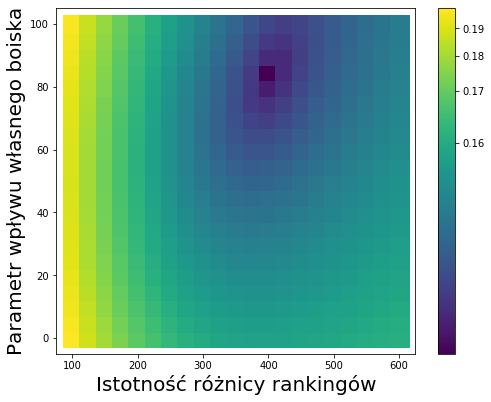

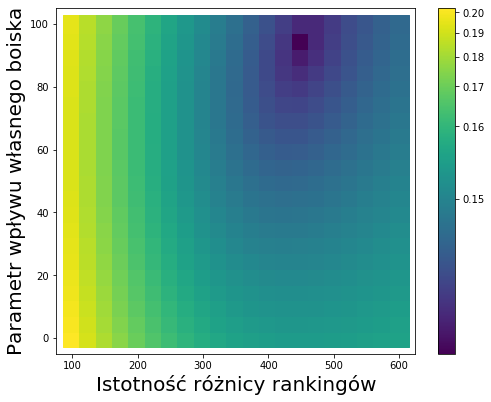

In [11]:
graph(x=skutecznosc93['sensitivity'], y=skutecznosc93['buff'], data=skutecznosc93,
      xlabel="Istotność różnicy rankingów",ylabel="Parametr wpływu własnego boiska",col="MSEval",save="MSEval93",s=350)
graph(x=skutecznosc93['sensitivity'], y=skutecznosc93['buff'], data=skutecznosc93,
      xlabel="Istotność różnicy rankingów",ylabel="Parametr wpływu własnego boiska",col="MSEtest",save="MSEtest93",s=350)
plt.show()

In [8]:
_, ranking93 = estymuj93(df93, 10, 400, 60)

In [7]:
def save_rank(ranking_dict, save_title):
    ranking_df = pd.DataFrame.from_dict(ranking_dict, orient='index').rename(columns={0: "Ranking"}).sort_values(by=['Ranking'],ascending=False).drop(['Jersey','Padania'])
    #ranking_df = ranking_df.loc[ranking_df['Ranking']>0]
    ranking_df2 = ranking_df.head().append(pd.DataFrame({'index':['...'],'Ranking':['...']}).set_index('index')).append(ranking_df.tail())
    dfi.export(ranking_df2, save_title+'.png')

In [40]:
save_rank(ranking93,'ranking93')

# Stworzenie funkcji na ważność turniejów

In [6]:
def tournament(friendly, nl, quali, continental, worldcup, other, df_with_diff):
    df_with_diff["I"] = 0

    for i, row in df.iterrows():
        if row["tournament"]=="Friendly":
            df_with_diff.loc[i,"I"] = friendly
        elif ("Nations League" in row["tournament"] and "qualification" not in row["tournament"]):
            df_with_diff.loc[i,"I"] = nl
        elif (row["tournament"] == "FIFA World Cup qualification"
        or row["tournament"] == "AFC Asian Cup qualification"
        or row["tournament"] == "UEFA Euro qualification"
        or row["tournament"] == "African Cup of Nations qualification"
        or row["tournament"] == "Gold Cup qualification"
        or row["tournament"] == "Copa América qualification"):
            df_with_diff.loc[i,"I"] = quali
        elif (row["tournament"] == "AFC Asian Cup"
        or row["tournament"] == "UEFA Euro"
        or row["tournament"] == "African Cup of Nations"
        or row["tournament"] == "Gold Cup"
        or row["tournament"] == "Copa América"):
            df_with_diff.loc[i,"I"] = continental
        elif row["tournament"] == "FIFA World Cup":
            df_with_diff.loc[i,"I"] = worldcup
        else:
            df_with_diff.loc[i,"I"] = other
    return df_with_diff

# Przygotowanie danych do rankingu 2006-2018 oraz pobranie danych o konfederacjach.

In [139]:
df_penalty2 = df_penalty.copy()

df_penalty2 = tournament(1, 2, 2.5, 3, 4, 2, df_penalty2)

df06 = df_penalty2[df_penalty2['date']>='2000-01-01'].copy()

In [140]:
Asia=pd.read_html("https://en.wikipedia.org/wiki/Asian_Football_Confederation")
Asia=Asia[4].Name
#Africa=pd.read_html("https://en.wikipedia.org/wiki/Confederation_of_African_Football")
#Africa[1]
America=pd.read_html("https://en.wikipedia.org/wiki/CONCACAF")
America=America[3].Association
SAmerica=pd.read_html("https://en.wikipedia.org/wiki/CONMEBOL")
SAmerica=SAmerica[4].Association
Oceania=pd.read_html("https://en.wikipedia.org/wiki/Oceania_Football_Confederation")
Oceania=Oceania[3].Association
Europa=pd.read_html("https://en.wikipedia.org/wiki/UEFA")
Europa=Europa[3].Association

America=America.drop([3,11])
America=America["North American Zone (NAFU) (3)"].str.split("[",expand=True).drop(columns=[1])
America["c"]=0.85
America.set_index(0,inplace=True)

Asia=Asia.drop([12,19,30,38])
Asia=Asia["ASEAN Football Federation (AFF) (12)"].str.split("[",expand=True).drop(columns=[1])
Asia["c"]=0.85
Asia.set_index(0,inplace=True)

Oceania=pd.DataFrame({"0":Oceania.to_numpy(),"c":0.85})
Oceania.set_index("0",inplace=True)

SAmerica=pd.DataFrame({"0":SAmerica.to_numpy(),"c":1})
SAmerica.set_index("0",inplace=True)

Europa=pd.DataFrame({"0":Europa.to_numpy()})
Europa=Europa["0"].str.split("[",expand=True).drop(columns=[1])
Europa.set_index(0,inplace=True)
Europa["c"]=1

unique1 = pd.unique(df06["home_team"])
unique2 = pd.unique(df06["away_team"])
unique_countries = np.unique(np.concatenate((unique1,unique2),0))


confs=pd.concat([Asia,America,SAmerica,Europa,Oceania])

africa=pd.DataFrame({"Country":list(set(unique_countries)-set(confs.index.to_numpy())),"c":0.9})
africa=africa.set_index("Country")

confs=pd.concat([confs,africa])
confs

,c
Australia,0.85
Brunei Darussalam,0.85
Cambodia,0.85
Indonesia,0.85
Laos,0.85
...,...
Brittany,0.90
Sark,0.90
Crimea,0.90
United Koreans in Japan,0.90


In [ ]:
ranking_test = pd.DataFrame.from_dict(ranking, orient='index')
ranking_test['conf'] = ['Asia' if x in Asia.index
                        else 'Europa' if x in Europa.index
                        else 'NA' if x in America.index
                        else 'SA' if x in SAmerica.index
                        else "Oceania" if x in Oceania.index
                        else 'rest' for x in ranking_test.index]

# Stworzenie funkcji estymującej wyniki oraz liczącej ranking FIFA 2006-2018.

In [16]:
df06["diff"] = df06["home_score"] - df06["away_score"]

conditions = [
    (df06["diff"] > 0),
    (df06["home_team"]==df06["winner"]),
    ((df06["diff"] == 0) & (df06["winner"]!=df06["home_team"])),
    (df06["diff"] < 0)
    ]

values1 = [3,2,1,0]

df06["W_home"] = np.select(conditions, values1)

conditions_away = [
    (df06["diff"] > 0),
    ((df06["diff"] == 0) & (df06["winner"]!=df06["away_team"])),
    (df06["away_team"]==df06["winner"]),
    (df06["diff"] < 0)
    ]

values2 = [0,1,2,3]

df06["W_away"] = np.select(conditions_away, values2)

conditions2 = [
    (df06["W_home"] > 1),
    (df06["W_home"] == 1),
    (df06["W_home"] < 1)
    ]

values = [1,0.5,0]
df06["W_home_real"] = np.select(conditions2, values)

conditions3 = [
    (df06["W_away"] > 1),
    (df06["W_away"] == 1),
    (df06["W_away"] < 1)
    ]

df06["W_away_real"] = np.select(conditions3, values)

lata = []
for rok in range(2001, 2024):
    lata.append(str(rok)+"-01-01")

In [17]:
def estymuj06(df, importance, sensitivity, home_buff):
    unique1 = pd.unique(df["home_team"])
    unique2 = pd.unique(df["away_team"])
    unique_countries = np.unique(np.concatenate((unique1,unique2),0))
     
    ranking_df = pd.DataFrame({'country': unique_countries, 
                               'nr_of_games_in_year': 0, '1': 0, '0.5': 0, '0.3': 0, '0.2': 0, 'overall': 0})
    ranking_df = ranking_df.set_index('country')

    #ilosc_dobrych_val = 0
    #ilosc_dobrych_test = 0
    
    year = 0
    
    place = [2]
    place.extend(range(2,151))
    place.extend([150]*(len(unique_countries)-150))
     
    kolejnosc = ranking_df['overall'].copy().to_frame()
    kolejnosc = kolejnosc.sort_values('overall', ascending = False)
    kolejnosc['place'] = place
            
    for i, row in df.iterrows():
        
        if(df.loc[i,"date"]>lata[year]):           
            ranking_df['1'] = ranking_df['1'].divide(ranking_df['nr_of_games_in_year']).replace(np.inf, 0).replace(np.nan, 0)
            ranking_df['overall'] = ranking_df['1']+0.5*ranking_df['0.5']+0.3*ranking_df['0.3']+0.2*ranking_df['0.2']
            
            ranking_df['nr_of_games_in_year'] = 0
            ranking_df['0.5'] = ranking_df['1']
            ranking_df['0.3'] = ranking_df['0.5']
            ranking_df['0.2'] = ranking_df['0.3']
            ranking_df['1'] = 0
            
            kolejnosc = ranking_df['overall'].copy().to_frame()
            kolejnosc = kolejnosc.sort_values('overall', ascending = False)
            kolejnosc['place'] = place
            
            year += 1
            
            

        rank_home = ranking_df.loc[df.loc[i,"home_team"], "overall"]
        rank_away = ranking_df.loc[df.loc[i,"away_team"], "overall"]

        if(df.loc[i, 'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance**(-(rank_home-rank_away+home_buff)/sensitivity))
        else:
            df.loc[i,"We_home"] = 1/(1+importance**(-(rank_home-rank_away)/sensitivity))
        df.loc[i,"We_away"] = 1 - df.loc[i,"We_home"]
                
        if(lata[year] < '2001-01-01'):
            ranking_df.loc[df.loc[i,"home_team"], "1"] += df.loc[i,"W_home"]*df.loc[i,"I"]*1/2*confs.loc[df.loc[i,"away_team"],"c"]
            ranking_df.loc[df.loc[i,"home_team"], "nr_of_games_in_year"] += 1

            ranking_df.loc[df.loc[i,"away_team"], "1"] += df.loc[i,"W_away"]*df.loc[i,"I"]*1/2*confs.loc[df.loc[i,"home_team"],"c"]
            ranking_df.loc[df.loc[i,"away_team"], "nr_of_games_in_year"] += 1
        else:
            ranking_df.loc[df.loc[i,"home_team"], "1"] += df.loc[i,"W_home"]*df.loc[i,"I"]*(200-kolejnosc.loc[df.loc[i,"away_team"],'place'])*confs.loc[df.loc[i,"away_team"],"c"]
            ranking_df.loc[df.loc[i,"home_team"], "nr_of_games_in_year"] += 1

            ranking_df.loc[df.loc[i,"away_team"], "1"] += df.loc[i,"W_away"]*df.loc[i,"I"]*(200-kolejnosc.loc[df.loc[i,"home_team"],'place'])*confs.loc[df.loc[i,"home_team"],"c"]
            ranking_df.loc[df.loc[i,"away_team"], "nr_of_games_in_year"] += 1
    
    
    
    
#     for i, row in df.tail(8000).head(4000).iterrows():
#         if((df.tail(8000).head(4000).loc[i,"W_home"]>=2 and df.tail(8000).head(4000).loc[i,"We_home"]>0.5) or
#            (df.tail(8000).head(4000).loc[i,"W_home"]==0 and df.tail(8000).head(4000).loc[i,"We_home"]<0.5)):
#             ilosc_dobrych_val += 1
#     score_val = round(ilosc_dobrych_val/len(df.tail(8000).head(4000)[df.tail(8000).head(4000)["W_home"] != 1]),5)
    
#     for i, row in df.tail(4000).iterrows():
#         if((df.loc[i,"W_home"]>=2 and df.loc[i,"We_home"]>0.5) or
#            (df.loc[i,"W_home"]==0 and df.loc[i,"We_home"]<0.5)):
#             ilosc_dobrych_test += 1
#     score_test = round(ilosc_dobrych_test/len(df.tail(4000)[df.tail(4000)["W_home"] != 1]),5)
    
    df["W_home_real-We_home"] = df["W_home_real"]-df["We_home"]
    df["W_away_real-We_away"] = df["W_away_real"]-df["We_away"]
    
    return(df, kolejnosc) #, score_val, score_test

In [42]:
rezultaty06 = []
progres = 1

import time
start_time = time.time()

for sensitivity in range(600, 1600, 100):
    for buff in range(0, 500, 50):
        df_est, _ = estymuj06(df06, 10, sensitivity, buff) #, score_val, score_test
        mse_val = round(np.sum((df_est["W_home_real-We_home"].tail(8000).head(4000)**2+df_est["W_away_real-We_away"].tail(8000).head(4000)**2)/8000),5)
        mse_test = round(np.sum((df_est["W_home_real-We_home"].tail(4000)**2+df_est["W_away_real-We_away"].tail(4000)**2)/8000),5)
        
        rezultaty06.append([sensitivity, buff, mse_val, mse_test]) #, score_val, score_test

        print("Progres: ", progres, "/400\n", [sensitivity, buff, mse_val, mse_test]) #, score_val, score_test
        progres = progres+1
            
skutecznosc06 = pd.DataFrame(rezultaty06, columns=['sensitivity', 'buff', 'MSEval', 'MSEtest']) #, 'SCOREval', 'SCOREtest'

(time.time()-start_time)/60

Progres:  1 /400
 [600, 0, 0.16879, 0.159]
Progres:  2 /400
 [600, 50, 0.16383, 0.1541]
Progres:  3 /400
 [600, 100, 0.16074, 0.15113]
Progres:  4 /400
 [600, 150, 0.15946, 0.15002]
Progres:  5 /400
 [600, 200, 0.15987, 0.15065]
Progres:  6 /400
 [600, 250, 0.16181, 0.15284]
Progres:  7 /400
 [600, 300, 0.16508, 0.15638]
Progres:  8 /400
 [600, 350, 0.16944, 0.16103]
Progres:  9 /400
 [600, 400, 0.17468, 0.16655]
Progres:  10 /400
 [600, 450, 0.18058, 0.17272]
Progres:  11 /400
 [700, 0, 0.16618, 0.15738]
Progres:  12 /400
 [700, 50, 0.16162, 0.15287]
Progres:  13 /400
 [700, 100, 0.1586, 0.14995]
Progres:  14 /400
 [700, 150, 0.15709, 0.14858]
Progres:  15 /400
 [700, 200, 0.15701, 0.14868]
Progres:  16 /400
 [700, 250, 0.15826, 0.15012]
Progres:  17 /400
 [700, 300, 0.16069, 0.15276]
Progres:  18 /400
 [700, 350, 0.16415, 0.15644]
Progres:  19 /400
 [700, 400, 0.16846, 0.16099]
Progres:  20 /400
 [700, 450, 0.17346, 0.16622]
Progres:  21 /400
 [800, 0, 0.16473, 0.15673]
Progres:  22 

97.75383704106012

In [43]:
grid_skutecznosc06 = skutecznosc06.sort_values(by=['MSEval'])
grid_skutecznosc06.to_csv(r'/home/arek/Pulpit/magisterka/grid_skutecznosc06.csv')
grid_skutecznosc06

,sensitivity,buff,MSEval,MSEtest
45,1000,250,0.15469,0.14837
44,1000,200,0.15473,0.14830
55,1100,250,0.15474,0.14887
34,900,200,0.15481,0.14784
54,1100,200,0.15502,0.14906
...,...,...,...,...
0,600,0,0.16879,0.15900
7,600,350,0.16944,0.16103
19,700,450,0.17346,0.16622
8,600,400,0.17468,0.16655


In [44]:
skutecznosc06 = pd.read_csv("grid_skutecznosc06.csv")
skutecznosc06

,Unnamed: 0,sensitivity,buff,MSEval,MSEtest
0,45,1000,250,0.15469,0.14837
1,44,1000,200,0.15473,0.14830
2,55,1100,250,0.15474,0.14887
3,34,900,200,0.15481,0.14784
4,54,1100,200,0.15502,0.14906
...,...,...,...,...,...
95,0,600,0,0.16879,0.15900
96,7,600,350,0.16944,0.16103
97,19,700,450,0.17346,0.16622
98,8,600,400,0.17468,0.16655


# Stworzenie wykresów dla rankingu 2006-2018.

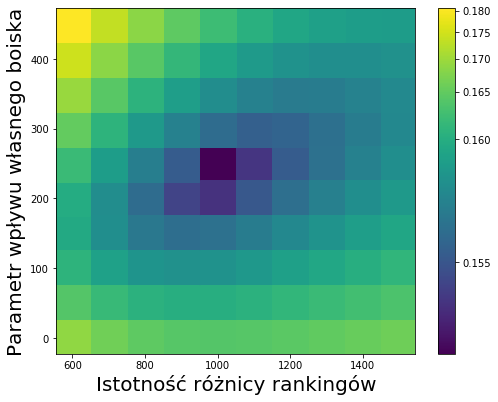

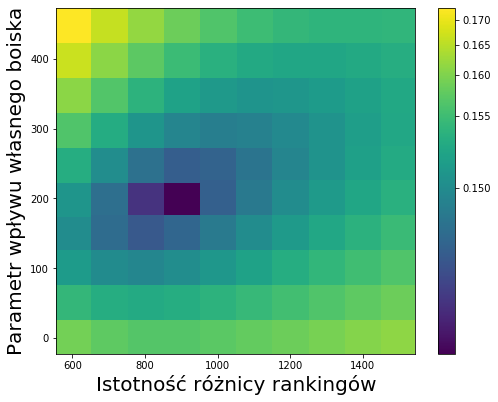

In [45]:
graph(x=skutecznosc06['sensitivity'], y=skutecznosc06['buff'], data=skutecznosc06,
      xlabel="Istotność różnicy rankingów",ylabel="Parametr wpływu własnego boiska",col="MSEval",save="MSEval06",s=1300)
graph(x=skutecznosc06['sensitivity'], y=skutecznosc06['buff'], data=skutecznosc06,
      xlabel="Istotność różnicy rankingów",ylabel="Parametr wpływu własnego boiska",col="MSEtest",save="MSEtest06",s=1300)
plt.show()

In [46]:
_,ranking06 = estymuj06(df06,10,1000,250)

In [9]:
def save_rank_from_df(ranking_df, save_title):
    ranking_df.index.name = None
    ranking_df = ranking_df.rename(columns={'overall':'Ranking'}).drop(['place'],axis=1)
    ranking_df.Ranking = ranking_df.Ranking.astype(int)
    ranking_df = ranking_df.loc[ranking_df['Ranking']>0]
    ranking_df2 = ranking_df.head().append(pd.DataFrame({'index':['...'],'Ranking':['...']}).set_index('index')).append(ranking_df.tail())
    dfi.export(ranking_df2, save_title+'.png')

In [52]:
save_rank_from_df(ranking06,'ranking06')

# Aktualny ranking FIFA
# Dodanie warunkow na jakość turniei z możliwie najbliższym przybliżeniem spowodowanym przez brak szczegółowych informacji w bazie danych oraz dodanie kolumny z różnicą goli oraz faktycznym wynikiem meczu.

In [10]:
df_penalty_fifa = df_penalty.copy()

df_penalty_fifa = tournament(10, 20, 25, 40, 50, 15, df_penalty_fifa)

df_with_diff = df_penalty_fifa[df_penalty_fifa['date']>='2000-01-01'].copy()

df_with_diff["diff"] = df["home_score"] - df["away_score"]

conditions = [
    (df_with_diff["diff"] > 0),
    (df_with_diff["home_team"]==df_with_diff["winner"]),
    ((df_with_diff["diff"] == 0) & (df_with_diff["winner"]!=df_with_diff["home_team"])),
    (df_with_diff["diff"] < 0)
    ]

values1 = [1,0.75,0.5,0]

df_with_diff["W_home"] = np.select(conditions, values1)

conditions_away = [
    (df_with_diff["diff"] > 0),
    ((df_with_diff["diff"] == 0) & (df_with_diff["winner"]!=df_with_diff["away_team"])),
    (df_with_diff["away_team"]==df_with_diff["winner"]),
    (df_with_diff["diff"] < 0)
    ]

values2 = [0,0.5,0.75,1]

df_with_diff["W_away"] = np.select(conditions_away, values2)

df_with_diff

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner,I,diff,W_home,W_away
22617,2000-01-04,Egypt,Togo,2,1,Friendly,Aswan,Egypt,False,NaN,10,1,1.0,0.0
22618,2000-01-07,Tunisia,Togo,7,0,Friendly,Tunis,Tunisia,False,NaN,10,7,1.0,0.0
22619,2000-01-08,Trinidad and Tobago,Canada,0,0,Friendly,Port of Spain,Trinidad and Tobago,False,NaN,10,0,0.5,0.5
22620,2000-01-09,Burkina Faso,Gabon,1,1,Friendly,Ouagadougou,Burkina Faso,False,NaN,10,0,0.5,0.5
22621,2000-01-09,Guatemala,Armenia,1,1,Friendly,Los Angeles,United States,True,NaN,10,0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False,NaN,25,2,1.0,0.0
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False,NaN,25,2,1.0,0.0
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False,NaN,25,1,1.0,0.0
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False,NaN,25,1,1.0,0.0


# Stworzenie funkcji estymującej wyniki zgodnie z rankingiem FIFA, jak i własnymi parametrami.

In [7]:
#funkcja wymaga kolumny "diff", default = FIFA

# 1/(1+ importance_diff_ranking^(-(diff+home_buff)/sensitivity_diff_ranking))

def estymuj_wyniki(df, importance_diff_ranking = 10, sensitivity_diff_ranking = 600, home_buff = 0):
    df["We_home"] = 0
    df["We_away"] = 0

    a = pd.unique(df["home_team"])
    b = pd.unique(df["away_team"])
    countries = np.unique(np.concatenate((a,b),0))
    
    ranking = dict()
    for i in countries:
        ranking[i] = 1200;
        
    for i, row in df.iterrows():
        rank_home_before = ranking[df.loc[i,"home_team"]]
        rank_away_before = ranking[df.loc[i,"away_team"]]
        if(df.loc[i,'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before+home_buff)/sensitivity_diff_ranking))
        else:
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before)/sensitivity_diff_ranking))
        df.loc[i,"We_away"] = 1 - df.loc[i,"We_home"]
        
        ranking[df.loc[i,"home_team"]] = int(rank_home_before + df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
        ranking[df.loc[i,"away_team"]] = int(rank_away_before + df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))

    df["W_home-We_home"] = df["W_home"]-df["We_home"]
    df["W_away-We_away"] = df["W_away"]-df["We_away"]
    
    df_1loop = df.copy()
    ranking_1loop = ranking.copy()
    
    for i, row in df.iterrows():
        rank_home_before = ranking[df.loc[i,"home_team"]]
        rank_away_before = ranking[df.loc[i,"away_team"]]
        if(df.loc[i,'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before+home_buff)/sensitivity_diff_ranking))
        else:
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before)/sensitivity_diff_ranking))
        df.loc[i,"We_away"] = 1 - df.loc[i,"We_home"]
        
        ranking[df.loc[i,"home_team"]] = int(rank_home_before + df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
        ranking[df.loc[i,"away_team"]] = int(rank_away_before + df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))

    df["W_home-We_home"] = df["W_home"]-df["We_home"]
    df["W_away-We_away"] = df["W_away"]-df["We_away"]

    return(df, df_1loop, ranking, ranking_1loop)

In [12]:
df2 = df.copy()
df2 = tournament(10, 20, 25, 40, 50, 15, df2)

df_own = df2[df2['date']>='2000-01-01'].copy()

df_own["diff"] = df_own["home_score"] - df_own["away_score"]

conditions = [
    (df_own["diff"] > 0),
    (df_own["diff"] == 0),
    (df_own["diff"] < 0)
    ]

values1 = [1,0.5,0]
values2 = [0,0.5,1]

df_own["W_home"] = np.select(conditions, values1)
df_own["W_away"] = np.select(conditions, values2)

In [17]:
qp, qp1, ranking, ranking1 = estymuj_wyniki(df_own,10,250,40)

In [18]:
import operator
sorted(ranking.items(), key=operator.itemgetter(1), reverse=True)

[('Brazil', 1349),
 ('Argentina', 1340),
 ('France', 1329),
 ('Belgium', 1312),
 ('Jersey', 1294),
 ('England', 1291),
 ('Guernsey', 1287),
 ('Padania', 1279),
 ('Spain', 1277),
 ('Isle of Man', 1276),
 ('Northern Cyprus', 1275),
 ('Italy', 1268),
 ('County of Nice', 1252),
 ('Abkhazia', 1248),
 ('Iraqi Kurdistan', 1247),
 ('Kárpátalja', 1247),
 ('Uruguay', 1245),
 ('Portugal', 1244),
 ('Mexico', 1242),
 ('Germany', 1241),
 ('United States', 1239),
 ('Kernow', 1235),
 ('Andalusia', 1233),
 ('Réunion', 1232),
 ('Basque Country', 1230),
 ('Switzerland', 1228),
 ('Netherlands', 1227),
 ('Yorkshire', 1225),
 ('Arameans Suryoye', 1222),
 ('Denmark', 1222),
 ('Menorca', 1221),
 ('Colombia', 1219),
 ('Occitania', 1218),
 ('Artsakh', 1216),
 ('Iran', 1216),
 ('Rhodes', 1215),
 ('Chameria', 1213),
 ('Cascadia', 1212),
 ('Ellan Vannin', 1212),
 ('Galicia', 1212),
 ('Catalonia', 1211),
 ('Panjab', 1210),
 ('Ynys Môn', 1210),
 ('Surrey', 1209),
 ('Canada', 1206),
 ('Crimea', 1205),
 ('Parishes of 

In [19]:
sorted(ranking1.items(), key=operator.itemgetter(1), reverse=True)

[('Brazil', 1403),
 ('Argentina', 1395),
 ('France', 1393),
 ('Belgium', 1375),
 ('England', 1352),
 ('Spain', 1340),
 ('Italy', 1331),
 ('Mexico', 1311),
 ('Iran', 1309),
 ('United States', 1309),
 ('Portugal', 1308),
 ('Germany', 1304),
 ('Uruguay', 1298),
 ('Switzerland', 1291),
 ('Japan', 1289),
 ('Netherlands', 1289),
 ('Denmark', 1284),
 ('Jersey', 1283),
 ('South Korea', 1283),
 ('Canada', 1280),
 ('Colombia', 1274),
 ('Guernsey', 1274),
 ('Costa Rica', 1269),
 ('Isle of Man', 1266),
 ('Padania', 1262),
 ('Northern Cyprus', 1260),
 ('Senegal', 1258),
 ('Serbia', 1258),
 ('Morocco', 1257),
 ('Peru', 1254),
 ('Croatia', 1251),
 ('New Zealand', 1246),
 ('Wales', 1245),
 ('Réunion', 1241),
 ('Egypt', 1240),
 ('Sweden', 1239),
 ('Ecuador', 1238),
 ('Abkhazia', 1237),
 ('Ukraine', 1234),
 ('Iraqi Kurdistan', 1233),
 ('Saudi Arabia', 1232),
 ('County of Nice', 1230),
 ('Kárpátalja', 1229),
 ('Basque Country', 1226),
 ('Australia', 1224),
 ('Ynys Môn', 1224),
 ('Andalusia', 1222),
 ('Qa

In [22]:
MSE(qp, 4000)

0.12997

In [23]:
MSE(qp1, 4000)

0.13345

# Analiza wpływu parametru nazwanego "sensitivity_diff_ranking".

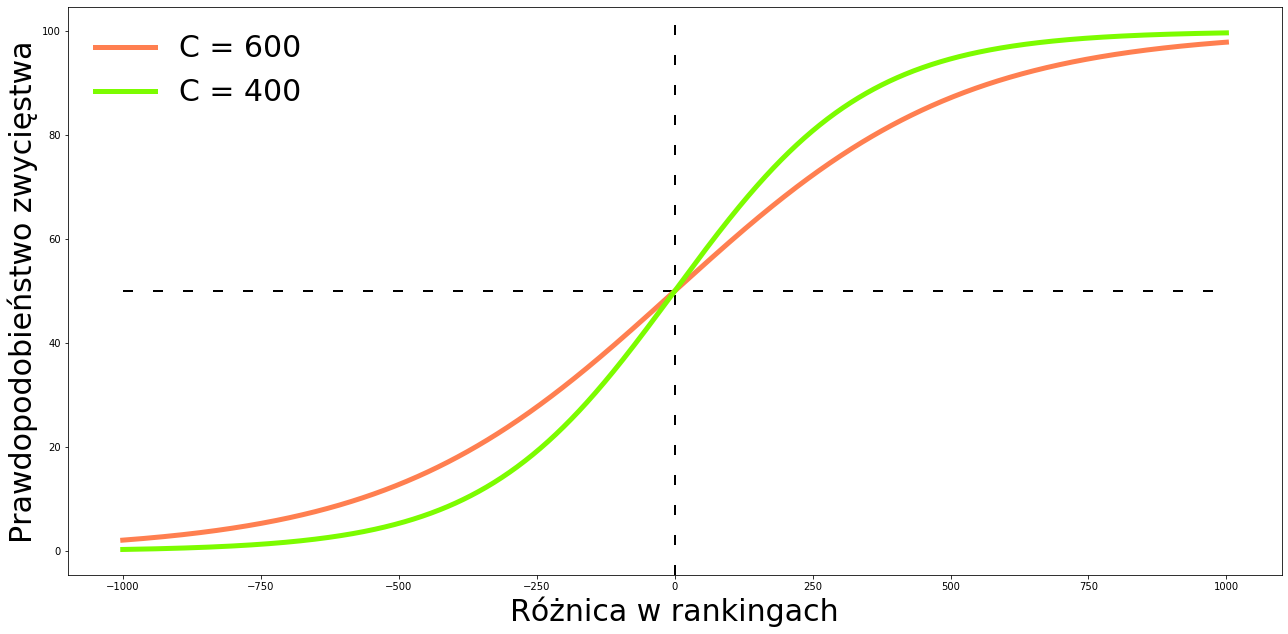

In [61]:
x = np.linspace(-1000, 1000, 1000)

fig, ax =plt.subplots(figsize=(18,9))
ax.plot(x, 1/2*x**0*100, color = "black", linewidth = 2, linestyle =(0,(5,10)))
ax.axvline(0, color = "black", linewidth = 2, linestyle =(0,(5,10)))
ax.plot(x, 1/(1+10**(-x/600))*100, label = "C = 600",color="coral", linewidth = 5)
ax.plot(x, 1/(1+10**(-x/400))*100,label = "C = 400",color='lawngreen', linewidth = 5)
font = {'color':  'black','size': 30}  
ax.set_xlabel("Różnica w rankingach",fontdict=font)
ax.set_ylabel("Prawdopodobieństwo zwycięstwa",fontdict=font)
#plt.title("Analiza parametru czułości rankingu")
leg=ax.legend(frameon=False,fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.tight_layout()
plt.show()
fig.savefig("Line1.png",dpi=250)



# Analiza wpływu własnego boiska.

In [23]:
df_with_diff2 = df_penalty.copy()
df_with_diff2 = tournament(10, 20, 25, 40, 50, 15, df_with_diff2)

df_with_diff2["diff"] = df["home_score"] - df["away_score"]

conditions = [
    (df_with_diff2["diff"] > 0),
    (df_with_diff2["home_team"]==df_with_diff2["winner"]),
    ((df_with_diff2["diff"] == 0) & (df_with_diff2["winner"]!=df_with_diff2["home_team"])),
    (df_with_diff2["diff"] < 0)
    ]

values1 = [1,0.75,0.5,0]

df_with_diff2["W_home"] = np.select(conditions, values1)

conditions_away = [
    (df_with_diff2["diff"] > 0),
    ((df_with_diff2["diff"] == 0) & (df_with_diff2["winner"]!=df_with_diff2["away_team"])),
    (df_with_diff2["away_team"]==df_with_diff2["winner"]),
    (df_with_diff2["diff"] < 0)
    ]

values2 = [0,0.5,0.75,1]

df_with_diff2["W_away"] = np.select(conditions_away, values2)

df_with_diff2

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner,I,diff,W_home,W_away
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,NaN,10,0,0.5,0.5
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,NaN,10,2,1.0,0.0
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,NaN,10,1,1.0,0.0
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,NaN,10,0,0.5,0.5
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,NaN,10,3,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False,NaN,25,2,1.0,0.0
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False,NaN,25,2,1.0,0.0
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False,NaN,25,1,1.0,0.0
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False,NaN,25,1,1.0,0.0


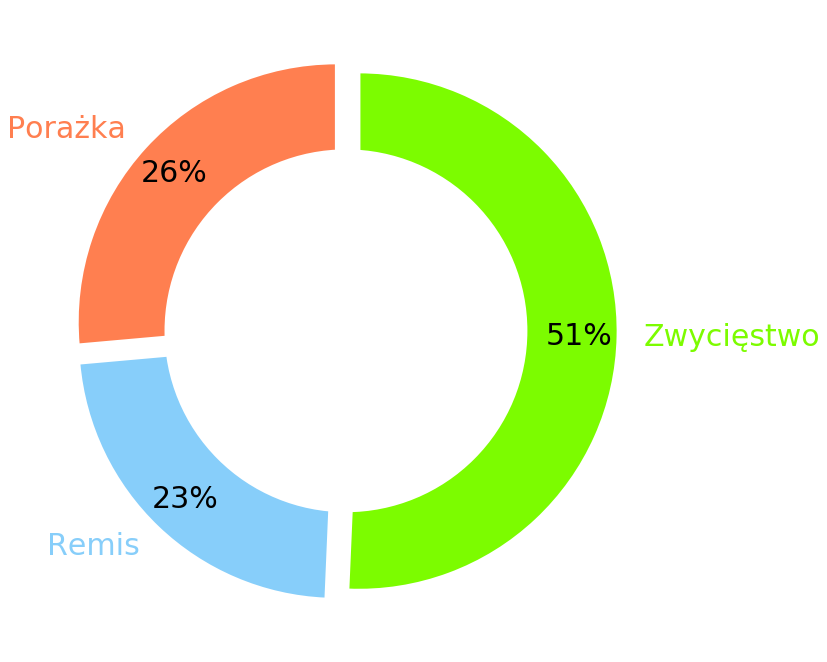

In [30]:
fig, ax =plt.subplots(figsize=(18,9))
plt.subplots_adjust(left=0,right=1,top=1,bottom=0)
explode = (0.05, 0.05, 0.05)
colors = ['coral','lightskyblue','lawngreen']

plot_home = df_with_diff2[(df_with_diff2["neutral"] == False) & (df_with_diff2["W_home"] != 0.75)].groupby(['W_home']).count()

patches, texts, pcts = ax.pie(
    plot_home.date, autopct='%1.0f%%', colors=colors, explode=explode,labels=["Porażka","Remis","Zwycięstwo"],
    startangle=90, pctdistance=0.85,
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 30})

for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())

#ax.pie(plot_home.date, autopct='%1.0f%%', colors=colors, explode=explode,labels=["Lose","Draw","Win"],startangle=90, pctdistance=0.85)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#ax.set_title("Rozkład wyników dla drużyny domowej", loc="center", **theme.title_font, fontsize=18, fontweight="bold")

plt.show()

fig.savefig("Pie.png",dpi=250)

# Analiza wpływu parametru nazwanego "home_buff".

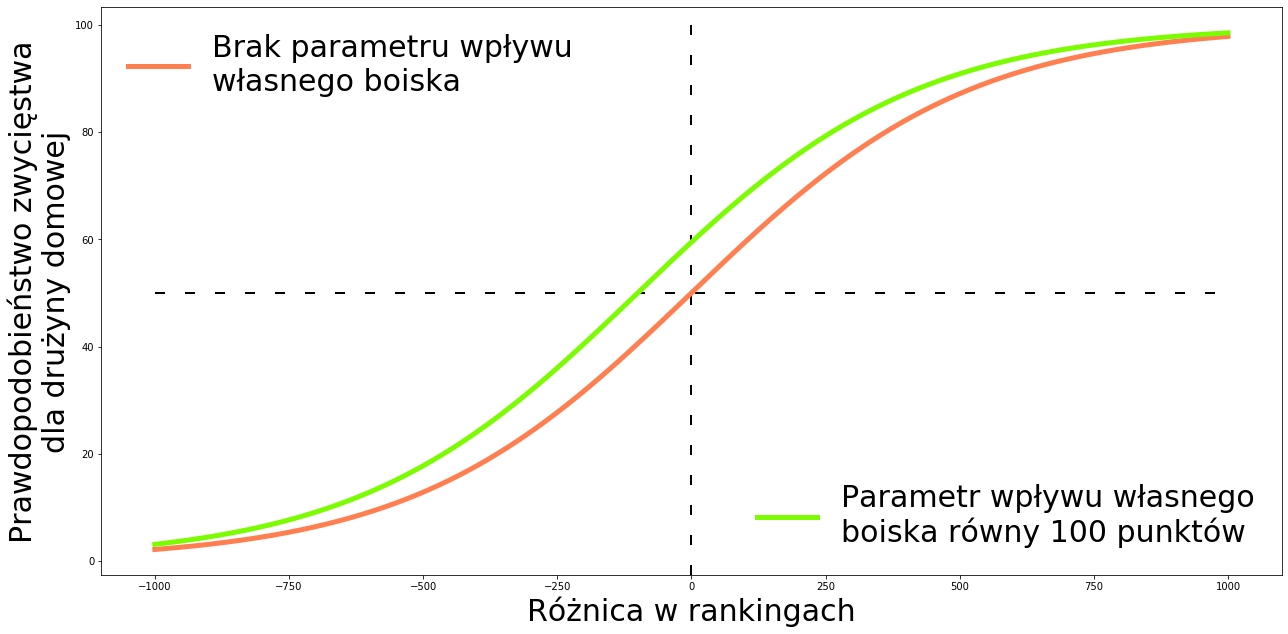

In [3]:
x = np.linspace(-1000, 1000, 1000)

fig, ax =plt.subplots(figsize=(18,9))
#plt.subplots_adjust(left=0,right=1,top=1,bottom=0)

ax.plot(x, 1/2*x**0*100, color = "black", linewidth = 2, linestyle =(0,(5,10)))
ax.axvline(0, color = "black", linewidth = 2, linestyle =(0,(5,10)))
line2,=ax.plot(x, 1/(1+10**(-x/600))*100, label = "Brak parametru wpływu\nwłasnego boiska",color="coral", linewidth = 5)
line1,=ax.plot(x, 1/(1+10**(-(x+100)/600))*100,label = "Parametr wpływu\nwłasnego boiska równy 100 punktów",color='lawngreen', linewidth =5)

font = {'color':  'black','size': 30}       
ax.set_xlabel("Różnica w rankingach",fontdict=font)
ax.set_ylabel("Prawdopodobieństwo zwycięstwa\ndla drużyny domowej",fontdict=font)
leg1=ax.legend(loc='upper left',handles=[line2],labels = ["Brak parametru wpływu\nwłasnego boiska"], frameon=False,fontsize=30)
for line in leg1.get_lines():
    line.set_linewidth(5.0)
leg2=ax.legend(loc='lower right',handles=[line1],labels = ["Parametr wpływu własnego\nboiska równy 100 punktów"], frameon=False,fontsize=30)
for line in leg2.get_lines():
    line.set_linewidth(5.0)
ax.add_artist(leg1)
plt.tight_layout()
plt.show()

fig.savefig("Line2.png",dpi=250)

# Stworzenie dynamicznego rankingu i wyznaczanie prawdopodobieństw zwycięstw dla aktualnego rankingu FIFA.

In [462]:
df_with_diff, ranking = estymuj_wyniki(df_with_diff)
df_with_diff

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner,I,diff,W_home,W_away,We_home,We_away,W_home-We_home,W_away-We_away
22617,2000-01-04,Egypt,Togo,2,1,Friendly,Aswan,Egypt,False,NaN,10,1,1.0,0.0,0.500000,0.500000,0.500000,-0.500000
22618,2000-01-07,Tunisia,Togo,7,0,Friendly,Tunis,Tunisia,False,NaN,10,7,1.0,0.0,0.504797,0.495203,0.495203,-0.495203
22619,2000-01-08,Trinidad and Tobago,Canada,0,0,Friendly,Port of Spain,Trinidad and Tobago,False,NaN,10,0,0.5,0.5,0.500000,0.500000,0.000000,0.000000
22620,2000-01-09,Burkina Faso,Gabon,1,1,Friendly,Ouagadougou,Burkina Faso,False,NaN,10,0,0.5,0.5,0.500000,0.500000,0.000000,0.000000
22621,2000-01-09,Guatemala,Armenia,1,1,Friendly,Los Angeles,United States,True,NaN,10,0,0.5,0.5,0.500000,0.500000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False,NaN,25,2,1.0,0.0,0.778810,0.221190,0.221190,-0.221190
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False,NaN,25,2,1.0,0.0,0.312874,0.687126,0.687126,-0.687126
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False,NaN,25,1,1.0,0.0,0.367930,0.632070,0.632070,-0.632070
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False,NaN,25,1,1.0,0.0,0.574280,0.425720,0.425720,-0.425720


In [410]:
#wyestymowany aktualny ranking zblizony do rzeczywistego

#dict(sorted(ranking.items(), key=lambda item: -item[1]))

{'Brazil': 1621,
 'Belgium': 1606,
 'France': 1605,
 'Spain': 1554,
 'Italy': 1539,
 'Germany': 1505,
 'Portugal': 1499,
 'England': 1491,
 'Netherlands': 1491,
 'Argentina': 1487,
 'Iran': 1456,
 'Mexico': 1455,
 'United States': 1422,
 'Japan': 1421,
 'South Korea': 1395,
 'Colombia': 1391,
 'Sweden': 1383,
 'Uruguay': 1382,
 'Switzerland': 1375,
 'Denmark': 1371,
 'Croatia': 1366,
 'Senegal': 1366,
 'Australia': 1364,
 'Algeria': 1355,
 'Morocco': 1350,
 'Chile': 1343,
 'Nigeria': 1332,
 'Jersey': 1320,
 'Egypt': 1317,
 'Ghana': 1317,
 'Qatar': 1313,
 'Padania': 1301,
 'Guernsey': 1300,
 'Ivory Coast': 1298,
 'Ukraine': 1289,
 'Wales': 1288,
 'Russia': 1287,
 'Northern Cyprus': 1286,
 'Poland': 1285,
 'Tunisia': 1283,
 'Isle of Man': 1282,
 'Saudi Arabia': 1278,
 'China PR': 1273,
 'Uzbekistan': 1269,
 'Iraq': 1268,
 'United Arab Emirates': 1268,
 'Czech Republic': 1265,
 'Peru': 1265,
 'Serbia': 1261,
 'Austria': 1256,
 'Cameroon': 1249,
 'Réunion': 1248,
 'Canada': 1246,
 'Turkey'

## Definicja funkcji liczącej MSE.

In [12]:
def MSE(df, number_of_obs):
    return(round(np.sum(df["W_home-We_home"].tail(number_of_obs)**2/number_of_obs),5))

## Wyliczenie MSE dla aktualnego rankingu FIFA estymowanego z całej bazy na ostatnich 10000 obserwacji.

In [32]:
test1 = estymuj_wyniki(df_with_diff2)[0]
round(np.sum((test1["W_home-We_home"].tail(10000)**2+test1["W_away-We_away"].tail(10000)**2)/20000),5)

0.14757

## Wyliczenie MSE dla aktualnego rankingu FIFA estymowanego z ostatnich 20 lat na ostatnich 10000 obserwacji.

In [34]:
test2 = estymuj_wyniki(df_with_diff2.tail(20000).copy())[0]
round(np.sum((test2["W_home-We_home"].tail(10000)**2+test2["W_away-We_away"].tail(10000)**2)/20000),5)

0.14523

## Wyliczenie MSE dla aktualnego rankingu FIFA estymowanego z ostatnich 20 lat na ostatnich 4000 obserwacji ~ 4 lata.

In [35]:
round(np.sum((test2["W_home-We_home"].tail(4000)**2+test2["W_away-We_away"].tail(4000)**2)/8000),5)

0.13948

## Wyliczenie MSE dla aktualnego rankingu FIFA estymowanego z ostatnich 10 lat na ostatnich 4000 obserwacji ~ 4 lata.

Duża zmiana w porównaniu do 20 lat, więc za optymalne uznaje 20 lat estymacji, w tym 4 lata walidacji i 4 lata oceny.

In [37]:
test3 = estymuj_wyniki(df_with_diff2.tail(10000).copy())[0]
round(np.sum((test3["W_home-We_home"].tail(4000)**2+test3["W_away-We_away"].tail(4000)**2)/8000),5)

0.1422

## Ostateczne wyniki aktualnego rankingu FIFA.

In [55]:
df_score, df_score_loop, ranking, _ = estymuj_wyniki(df_with_diff2)

print("MSE walidacyjny 1 obieg: ", round((np.sum(df_score_loop["W_home-We_home"].tail(8000).head(4000)**2)+np.sum(df_score_loop["W_away-We_away"].tail(8000).head(4000)**2))/8000,5))
print("MSE walidacyjny: ", round((np.sum(df_score["W_home-We_home"].tail(8000).head(4000)**2)+np.sum(df_score["W_away-We_away"].tail(8000).head(4000)**2))/8000,5))
print("MSE test: ", round((np.sum(df_score["W_away-We_away"].tail(4000)**2)+np.sum(df_score["W_away-We_away"].tail(4000)**2))/8000,5))

MSE walidacyjny 1 obieg:  0.15528
MSE walidacyjny:  0.14972
MSE test:  0.14146


In [61]:
save_rank(ranking, 'ranking_actual')

In [57]:
ranking

{'Abkhazia': 1273,
 'Afghanistan': 631,
 'Albania': 810,
 'Alderney': 1015,
 'Algeria': 1041,
 'American Samoa': 739,
 'Andalusia': 1225,
 'Andorra': 273,
 'Angola': 789,
 'Anguilla': 484,
 'Antigua and Barbuda': 766,
 'Arameans Suryoye': 1220,
 'Argentina': 1367,
 'Armenia': 736,
 'Artsakh': 1230,
 'Aruba': 610,
 'Asturias': 1210,
 'Australia': 1094,
 'Austria': 977,
 'Azerbaijan': 553,
 'Bahamas': 821,
 'Bahrain': 897,
 'Bangladesh': 453,
 'Barawa': 1116,
 'Barbados': 698,
 'Basque Country': 1297,
 'Belarus': 713,
 'Belgium': 1355,
 'Belize': 657,
 'Benin': 862,
 'Bermuda': 825,
 'Bhutan': 343,
 'Bolivia': 793,
 'Bonaire': 992,
 'Bosnia and Herzegovina': 919,
 'Botswana': 706,
 'Brazil': 1439,
 'British Virgin Islands': 533,
 'Brittany': 1181,
 'Brunei': 426,
 'Brunei Darussalam': 1181,
 'Bulgaria': 837,
 'Burkina Faso': 943,
 'Burundi': 679,
 'Cambodia': 434,
 'Cameroon': 1061,
 'Canada': 1080,
 'Canary Islands': 1194,
 'Cape Verde': 885,
 'Cascadia': 1215,
 'Catalonia': 1199,
 'Cay

# Szukanie optymalnych parametrów dla aktualnego rankingu FIFA.

In [27]:
rezultaty = []
progres = 1

for sensitivity in range(100, 625, 25):
    for buff in range(0, 210, 10):
        df_est, df_est1loop, _, _ = estymuj_wyniki(df_own, 10, sensitivity, buff)
            
        rezultaty.append([sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                         MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])

        print("Progres: ", progres, "/400\n", [sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                                              MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])
        progres = progres+1
            
skutecznosc = pd.DataFrame(rezultaty, columns=['sensitivity', 'buff', 'MSEval', 'MSEtest', 'MSEval1loop','MSEtest1loop'])

Progres:  1 /400
 [100, 0, 0.15491, 0.143, 0.15782, 0.14505]
Progres:  2 /400
 [100, 10, 0.14877, 0.13788, 0.15173, 0.13967]
Progres:  3 /400
 [100, 20, 0.14604, 0.13545, 0.14872, 0.13708]
Progres:  4 /400
 [100, 30, 0.14562, 0.13557, 0.14853, 0.1372]
Progres:  5 /400
 [100, 40, 0.14749, 0.13778, 0.15054, 0.13943]
Progres:  6 /400
 [100, 50, 0.1512, 0.14169, 0.15449, 0.14332]
Progres:  7 /400
 [100, 60, 0.15561, 0.14638, 0.15941, 0.1483]
Progres:  8 /400
 [100, 70, 0.1608, 0.15161, 0.16501, 0.15389]
Progres:  9 /400
 [100, 80, 0.16635, 0.15726, 0.17091, 0.15974]
Progres:  10 /400
 [100, 90, 0.1717, 0.16277, 0.17661, 0.16572]
Progres:  11 /400
 [100, 100, 0.17694, 0.16802, 0.18242, 0.17127]
Progres:  12 /400
 [100, 110, 0.18192, 0.17313, 0.18778, 0.17676]
Progres:  13 /400
 [100, 120, 0.18673, 0.17803, 0.19298, 0.18199]
Progres:  14 /400
 [100, 130, 0.191, 0.18254, 0.19787, 0.18694]
Progres:  15 /400
 [100, 140, 0.19515, 0.18682, 0.20255, 0.19161]
Progres:  16 /400
 [100, 150, 0.19896, 

Progres:  127 /400
 [250, 0, 0.1478, 0.1368, 0.15372, 0.14055]
Progres:  128 /400
 [250, 10, 0.14512, 0.13439, 0.1509, 0.13796]
Progres:  129 /400
 [250, 20, 0.14299, 0.1324, 0.14867, 0.13593]
Progres:  130 /400
 [250, 30, 0.14134, 0.13089, 0.14694, 0.13442]
Progres:  131 /400
 [250, 40, 0.14021, 0.12997, 0.14583, 0.13345]
Progres:  132 /400
 [250, 50, 0.13953, 0.12939, 0.14514, 0.13295]
Progres:  133 /400
 [250, 60, 0.13941, 0.12943, 0.14499, 0.13301]
Progres:  134 /400
 [250, 70, 0.13965, 0.12978, 0.14544, 0.13341]
Progres:  135 /400
 [250, 80, 0.14037, 0.13055, 0.14607, 0.13423]
Progres:  136 /400
 [250, 90, 0.14144, 0.13172, 0.14725, 0.13546]
Progres:  137 /400
 [250, 100, 0.14274, 0.1331, 0.14879, 0.13705]
Progres:  138 /400
 [250, 110, 0.14436, 0.13482, 0.1506, 0.13898]
Progres:  139 /400
 [250, 120, 0.14625, 0.1368, 0.15266, 0.14113]
Progres:  140 /400
 [250, 130, 0.14836, 0.139, 0.15507, 0.14349]
Progres:  141 /400
 [250, 140, 0.15057, 0.14134, 0.15752, 0.146]
Progres:  142 /40

Progres:  252 /400
 [375, 200, 0.1501, 0.14077, 0.15832, 0.14701]
Progres:  253 /400
 [400, 0, 0.14801, 0.13725, 0.15505, 0.14215]
Progres:  254 /400
 [400, 10, 0.14629, 0.13558, 0.15324, 0.14043]
Progres:  255 /400
 [400, 20, 0.14476, 0.13416, 0.15165, 0.13897]
Progres:  256 /400
 [400, 30, 0.14341, 0.13296, 0.15019, 0.13768]
Progres:  257 /400
 [400, 40, 0.14233, 0.13186, 0.14899, 0.13658]
Progres:  258 /400
 [400, 50, 0.1414, 0.13106, 0.1481, 0.13581]
Progres:  259 /400
 [400, 60, 0.14071, 0.13042, 0.1474, 0.13519]
Progres:  260 /400
 [400, 70, 0.14018, 0.13, 0.14693, 0.13479]
Progres:  261 /400
 [400, 80, 0.13992, 0.12979, 0.1466, 0.13453]
Progres:  262 /400
 [400, 90, 0.13984, 0.12977, 0.14652, 0.13454]
Progres:  263 /400
 [400, 100, 0.13982, 0.12984, 0.14663, 0.13475]
Progres:  264 /400
 [400, 110, 0.1401, 0.13016, 0.14699, 0.13513]
Progres:  265 /400
 [400, 120, 0.14045, 0.13064, 0.14749, 0.13566]
Progres:  266 /400
 [400, 130, 0.141, 0.13127, 0.14813, 0.13648]
Progres:  267 /40

Progres:  377 /400
 [525, 190, 0.14302, 0.13354, 0.15115, 0.13987]
Progres:  378 /400
 [525, 200, 0.14375, 0.13428, 0.15196, 0.14076]
Progres:  379 /400
 [550, 0, 0.14887, 0.13846, 0.15675, 0.14423]
Progres:  380 /400
 [550, 10, 0.14756, 0.13723, 0.15538, 0.143]
Progres:  381 /400
 [550, 20, 0.14635, 0.13607, 0.15407, 0.14183]
Progres:  382 /400
 [550, 30, 0.14531, 0.13504, 0.15292, 0.14074]
Progres:  383 /400
 [550, 40, 0.14434, 0.13413, 0.15195, 0.13979]
Progres:  384 /400
 [550, 50, 0.14351, 0.13336, 0.15101, 0.139]
Progres:  385 /400
 [550, 60, 0.14278, 0.13267, 0.15026, 0.13832]
Progres:  386 /400
 [550, 70, 0.14217, 0.13214, 0.14966, 0.13775]
Progres:  387 /400
 [550, 80, 0.14167, 0.13165, 0.14907, 0.1373]
Progres:  388 /400
 [550, 90, 0.14127, 0.13128, 0.14869, 0.13699]
Progres:  389 /400
 [550, 100, 0.14098, 0.13103, 0.14842, 0.13676]
Progres:  390 /400
 [550, 110, 0.14075, 0.1309, 0.14828, 0.13662]
Progres:  391 /400
 [550, 120, 0.14064, 0.1309, 0.14825, 0.13663]
Progres:  392

In [28]:
grid_skutecznosc = skutecznosc.sort_values(by=['MSEtest'])
grid_skutecznosc.to_csv(r'/home/arek/Pulpit/magisterka/grid_skutecznosc_newest.csv')
grid_skutecznosc

,sensitivity,buff,MSEval,MSEtest,MSEval1loop,MSEtest1loop
153,275,60,0.13942,0.12931,0.14526,0.13309
196,325,70,0.13951,0.12932,0.14576,0.13356
175,300,70,0.13937,0.12932,0.14545,0.13334
174,300,60,0.13953,0.12937,0.14558,0.13337
131,250,50,0.13953,0.12939,0.14514,0.13295
...,...,...,...,...,...,...
41,125,200,0.20315,0.19538,0.21299,0.20231
17,100,170,0.20599,0.19811,0.21471,0.20397
18,100,180,0.20912,0.20137,0.21834,0.20755
19,100,190,0.21199,0.20435,0.22175,0.21098


In [12]:
skutecznosc = pd.read_csv("grid_skutecznosc_newest.csv")
skutecznosc

,Unnamed: 0,sensitivity,buff,MSEval,MSEtest,MSEval1loop,MSEtest1loop
0,153,275,60,0.13942,0.12931,0.14526,0.13309
1,196,325,70,0.13951,0.12932,0.14576,0.13356
2,175,300,70,0.13937,0.12932,0.14545,0.13334
3,174,300,60,0.13953,0.12937,0.14558,0.13337
4,131,250,50,0.13953,0.12939,0.14514,0.13295
...,...,...,...,...,...,...,...
436,41,125,200,0.20315,0.19538,0.21299,0.20231
437,17,100,170,0.20599,0.19811,0.21471,0.20397
438,18,100,180,0.20912,0.20137,0.21834,0.20755
439,19,100,190,0.21199,0.20435,0.22175,0.21098


In [13]:
skutecznosc.sort_values(by=['MSEval'])

,Unnamed: 0,sensitivity,buff,MSEval,MSEtest,MSEval1loop,MSEtest1loop
2,175,300,70,0.13937,0.12932,0.14545,0.13334
9,154,275,70,0.13937,0.12949,0.14528,0.13328
6,132,250,60,0.13941,0.12943,0.14499,0.13301
0,153,275,60,0.13942,0.12931,0.14526,0.13309
1,196,325,70,0.13951,0.12932,0.14576,0.13356
...,...,...,...,...,...,...,...
436,41,125,200,0.20315,0.19538,0.21299,0.20231
437,17,100,170,0.20599,0.19811,0.21471,0.20397
438,18,100,180,0.20912,0.20137,0.21834,0.20755
439,19,100,190,0.21199,0.20435,0.22175,0.21098


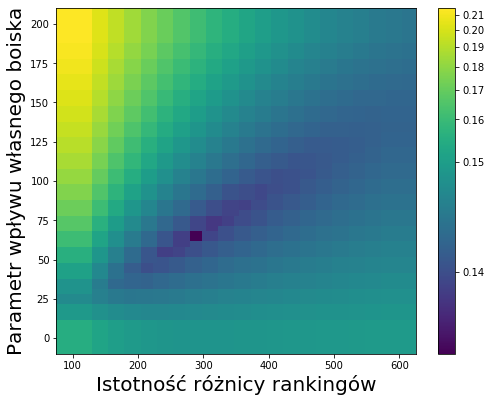

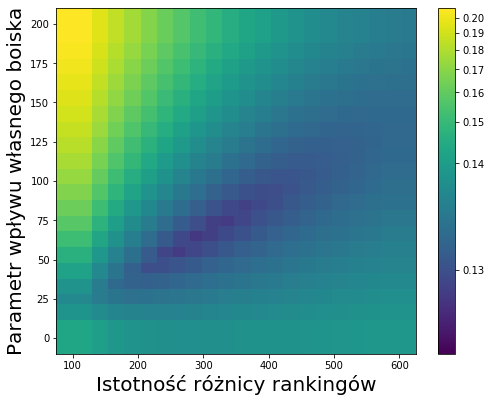

In [17]:
graph(x=skutecznosc['sensitivity'], y=skutecznosc['buff'], data=skutecznosc,
      xlabel="Istotność różnicy rankingów",ylabel="Parametr wpływu własnego boiska",col="MSEval",save="MSEval",s=1300)
graph(x=skutecznosc['sensitivity'], y=skutecznosc['buff'], data=skutecznosc,
      xlabel="Istotność różnicy rankingów",ylabel="Parametr wpływu własnego boiska",col="MSEtest",save="MSEtest",s=1300)
plt.show()

In [14]:
skutecznosc.sort_values(by=['MSEval1loop'])

,Unnamed: 0,sensitivity,buff,MSEval,MSEtest,MSEval1loop,MSEtest1loop
8,110,225,50,0.13957,0.12948,0.14479,0.13281
27,89,200,50,0.13996,0.12986,0.14487,0.13294
54,67,175,40,0.14040,0.13042,0.14498,0.13308
6,132,250,60,0.13941,0.12943,0.14499,0.13301
17,111,225,60,0.13965,0.12970,0.14506,0.13309
...,...,...,...,...,...,...,...
436,41,125,200,0.20315,0.19538,0.21299,0.20231
437,17,100,170,0.20599,0.19811,0.21471,0.20397
438,18,100,180,0.20912,0.20137,0.21834,0.20755
439,19,100,190,0.21199,0.20435,0.22175,0.21098


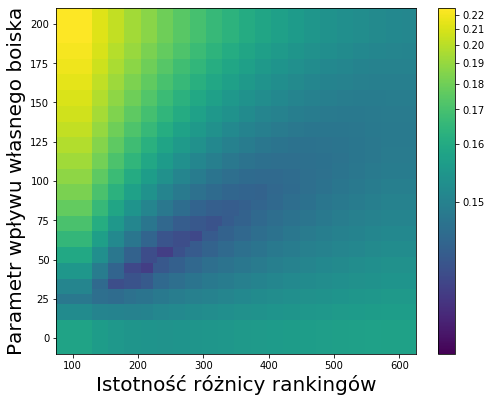

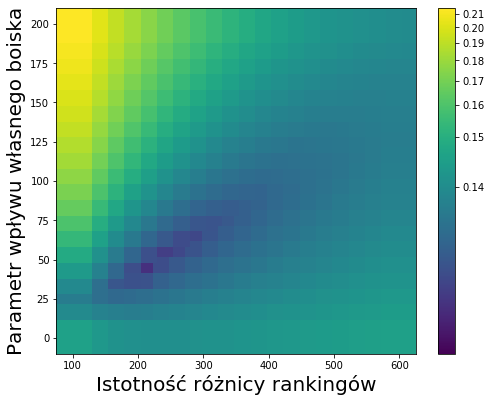

In [16]:
graph(x=skutecznosc['sensitivity'], y=skutecznosc['buff'], data=skutecznosc,
      xlabel="Istotność różnicy rankingów",ylabel="Parametr wpływu własnego boiska",col="MSEval1loop",save="MSEval1loop",s=1300)
graph(x=skutecznosc['sensitivity'], y=skutecznosc['buff'], data=skutecznosc,
      xlabel="Istotność różnicy rankingów",ylabel="Parametr wpływu własnego boiska",col="MSEtest1loop",save="MSEtest1loop",s=1300)
plt.show()

In [20]:
_, _, ranking, _ = estymuj_wyniki(df_own, 10, 300, 70)
_, _, _, ranking_1loop = estymuj_wyniki(df_own, 10, 225, 50)

In [21]:
save_rank(ranking,'ranking')
save_rank(ranking_1loop,'ranking_1loop')

In [ ]:
#ranking_best = estymuj_wyniki(df_own,5,200,40)[1]
#dict(sorted(ranking_best.items(), key=lambda item: -item[1]))

# Porównanie rankingu FIFA i wyestymowanego.

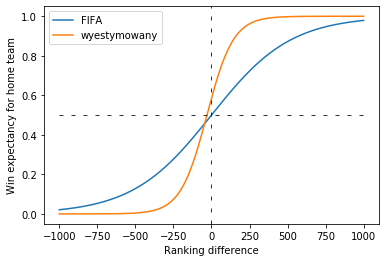

In [12]:
x = np.linspace(-1000, 1000, 1000)

plt.plot(x, 1/(1+10**(-x/600)), label = "FIFA")
plt.plot(x, 1/(1+10**(-(x+30)/200)),label = "wyestymowany")
plt.plot(x, 1/2*x**0, color = "black", linewidth = 0.8, linestyle =(0,(5,10)))
plt.axvline(0, color = "black", linewidth = 0.8, linestyle =(0,(5,10)))
plt.xlabel("Ranking difference")
plt.ylabel("Win expectancy for home team")
plt.legend()
plt.show()

# Sprawdzenie założenia Mahera o rozkładzie goli jako rozkładzie Poissona.

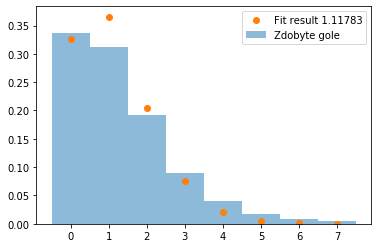

Power_divergenceResult(statistic=7971.426964514021, pvalue=0.0)


In [69]:
df_poisson = df[(df['date']>='2000-01-01') & (df['neutral'] == False)]
gole = np.concatenate([df_poisson['home_score'].to_numpy(),df_poisson['away_score'].to_numpy()])

bins = np.arange(9) - 0.5  #szerokosc powinno byc liczba calkowita bo poisson to dyskretny rozklad
entries, bin_edges, patches = plt.hist(gole, bins=bins, density=True, label='Zdobyte gole', alpha = 0.5)

bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])


def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)


parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries)

x_plot = np.arange(0, 8)

plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    marker='o', linestyle='',
    label='Fit result '+str(round(float(parameters),5)),
)
plt.legend()
plt.show()


fig = plt.figure()
entries_count, bins, _ = plt.hist(gole, bins=bins)
plt.close(fig)


expected_poisson = st.poisson.pmf(range(8),parameters)
print(st.chisquare(f_obs=entries_count, f_exp=expected_poisson*np.sum(entries_count)))

In [40]:
licznik = (entries_count[:10]-[float(st.poisson.pmf(i, parameters))*np.sum(entries_count[:10]) for i in range(10)])**2

In [46]:
float(st.poisson.pmf(0, parameters))

0.2989256391517259

In [23]:
#####################################################################################
#model regresji z atakiem i obrona gdzie 0 na argumentach nieuzywanych
len({'a':[]}['a'])>1

False

In [224]:
lata = []
for rok in range(2001, 2024):
    lata.append(str(rok)+"-01-01")
import heapq
 
def estymuj_arek(df, importance_diff_ranking = 10, sensitivity_diff_ranking = 600, home_buff = 0):
    df["We_home"] = 0
    df["We_away"] = 0

    a = pd.unique(df["home_team"])
    b = pd.unique(df["away_team"])
    countries = np.unique(np.concatenate((a,b),0))
    
    ranking, results_in_year, results_in_year_score, score = dict(), dict(), dict(), dict()
    
    for i in countries:
        ranking[i] = 1200;
#         results_in_year[i] = []
    
#     year = 0
    
    for i, row in df.iterrows():
#         if(df.loc[i,"date"]>lata[year]):  
#             results_in_year_score = {x:(int(np.mean(results_in_year[x]))
#                                         if len(results_in_year[x])>1 else 0) for x in countries}
#             mean = int(sum(results_in_year_score.values()) / len(results_in_year_score))
#             score = {x:results_in_year_score[x]-mean for x in countries}
#             ranking = {i:ranking[i]+score[i] for i in countries}
#             results_in_year = {x:[] for x in countries}
#             year += 1
            
        rank_home_before = ranking[df.loc[i,"home_team"]]
        rank_away_before = ranking[df.loc[i,"away_team"]]
        if(df.loc[i,'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before+home_buff)/sensitivity_diff_ranking))
        else:
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before)/sensitivity_diff_ranking))
        df.loc[i,"We_away"] = 1 - df.loc[i,"We_home"]
        
        diff = df.loc[i,'home_score'] - df.loc[i,'away_score']
        if(diff>0):
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"])*math.atan(diff)*4/math.pi)
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))
        elif(diff<0):
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"]))*math.atan(-diff)*4/math.pi)
        else:
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))
        
        ranking[df.loc[i,"home_team"]] = rank_home_before + home_add
        ranking[df.loc[i,"away_team"]] = rank_away_before + away_add

#         results_in_year[df.loc[i,"home_team"]].append(home_add)
#         results_in_year[df.loc[i,"away_team"]].append(away_add)
    
    ranking_test = pd.DataFrame.from_dict(ranking, orient='index')
    ranking_test['conf'] = ['Asia' if x in Asia.index
                            else 'Europa' if x in Europa.index
                            else 'NA' if x in America.index
                            else 'SA' if x in SAmerica.index
                            else "Oceania" if x in Oceania.index
                            else 'rest' for x in ranking_test.index]
    
    ranking = {x:(int(ranking_test.groupby('conf').mean().loc['Asia',0]) if x in Asia.index
                  else 1200 - 2*(1200 - int(ranking_test.groupby('conf').mean().loc['Europa',0])) if x in Europa.index
                  else 1200 - 2*(1200 - int(ranking_test.groupby('conf').mean().loc['NA',0])) if x in America.index
                  else 1200 - 2*(1200 - int(ranking_test.groupby('conf').mean().loc['SA',0])) if x in SAmerica.index
                  else 1200 - 2*(1200 - int(ranking_test.groupby('conf').mean().loc['Oceania',0])) if x in Oceania.index
                  else 1200 - 2*(1200 - int(ranking_test.groupby('conf').mean().loc['rest',0]))) for x in countries}
    print(ranking_test.groupby('conf').mean(), ranking['Mexico'], ranking['Poland'])
#     year = 0
    
    for i, row in df.iterrows():  
#        if(df.loc[i,"date"]>lata[year]):
#             print(np.mean(results_in_year['Mexico']),
#                  np.mean(results_in_year['Poland']))
#             results_in_year_score = {x:(int(np.mean(results_in_year[x]))
#                                         if len(results_in_year[x])>1 else 0) for x in countries}
#             mean = int(sum(results_in_year_score.values()) / len(results_in_year_score))
#             score = {x:results_in_year_score[x]-mean for x in countries}
#             ranking = {i:ranking[i]+score[i] for i in countries}
#             results_in_year = {x:[] for x in countries}
#             year += 1
                                                      
        rank_home_before = ranking[df.loc[i,"home_team"]]
        rank_away_before = ranking[df.loc[i,"away_team"]]
        if(df.loc[i,'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before+home_buff)/sensitivity_diff_ranking))
        else:
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before)/sensitivity_diff_ranking))
        df.loc[i,"We_away"] = 1 - df.loc[i,"We_home"]

        diff = df.loc[i,'home_score'] - df.loc[i,'away_score']
        if(diff>0):
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"])*math.atan(diff)*4/math.pi)
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))
        elif(diff<0):
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"]))*math.atan(-diff)*4/math.pi)
        else:
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))
            
        if(df.loc[i,"home_team"]=='Mexico'):
            print(ranking[df.loc[i,"home_team"]], home_add, df.loc[i,"away_team"], ranking[df.loc[i,"away_team"]])
        if(df.loc[i,"away_team"]=='Mexico'):  
            print(ranking[df.loc[i,"away_team"]], away_add, df.loc[i,"home_team"], ranking[df.loc[i,"home_team"]])
            
        ranking[df.loc[i,"home_team"]] = rank_home_before + home_add
        ranking[df.loc[i,"away_team"]] = rank_away_before + away_add

#         results_in_year[df.loc[i,"home_team"]].append(home_add)
#         results_in_year[df.loc[i,"away_team"]].append(away_add)
    
    df_1loop = df.copy()
    ranking_1loop = ranking.copy()
    
    for i, row in df.iterrows():                                                      
        rank_home_before = ranking[df.loc[i,"home_team"]]
        rank_away_before = ranking[df.loc[i,"away_team"]]
        if(df.loc[i,'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before+home_buff)/sensitivity_diff_ranking))
        else:
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before)/sensitivity_diff_ranking))
        df.loc[i,"We_away"] = 1 - df.loc[i,"We_home"]

        diff = df.loc[i,'home_score'] - df.loc[i,'away_score']
        if(diff>0):
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"])*math.atan(diff)*4/math.pi)
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))
        elif(diff<0):
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"]))*math.atan(-diff)*4/math.pi)
        else:
            home_add = int(df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
            away_add = int(df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))
        
        ranking[df.loc[i,"home_team"]] = rank_home_before + home_add
        ranking[df.loc[i,"away_team"]] = rank_away_before + away_add

#         results_in_year[df.loc[i,"home_team"]].append(home_add)
#         results_in_year[df.loc[i,"away_team"]].append(away_add)
        
    df["W_home-We_home"] = df["W_home"]-df["We_home"]
    df["W_away-We_away"] = df["W_away"]-df["We_away"]

    return(df, df_1loop, ranking, ranking_1loop)

In [159]:
rezultaty_arek = []
progres = 1

for sensitivity in range(250, 625, 50):
    for buff in range(0, 110, 50):
        df_est, df_est1loop, _, _ = estymuj_arek(df_own, 10, sensitivity, buff)
            
        rezultaty_arek.append([sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                         MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])

        print("Progres: ", progres, "/400\n", [sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                                              MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])
        progres = progres+1
            
skutecznosc_arek = pd.DataFrame(rezultaty_arek, columns=['sensitivity', 'buff', 'MSEval', 'MSEtest', 'MSEval1loop','MSEtest1loop'])

                   0
conf                
Asia     1156.170732
Europa   1245.818182
NA       1172.675000
Oceania  1167.461538
SA       1362.700000
rest     1193.956522 1172 1245
Progres:  1 /400
 [250, 0, 0.1438, 0.13314, 0.13595, 0.12606]
                   0
conf                
Asia     1153.268293
Europa   1242.145455
NA       1176.025000
Oceania  1169.923077
SA       1367.200000
rest     1194.753623 1176 1242
Progres:  2 /400
 [250, 50, 0.13589, 0.12597, 0.1438, 0.13314]
                   0
conf                
Asia     1149.707317
Europa   1238.145455
NA       1179.400000
Oceania  1172.384615
SA       1376.100000
rest     1195.550725 1179 1238
Progres:  3 /400
 [250, 100, 0.13914, 0.1297, 0.13589, 0.12597]
                   0
conf                
Asia     1154.170732
Europa   1245.909091
NA       1171.675000
Oceania  1167.076923
SA       1376.300000
rest     1193.855072 1171 1245
Progres:  4 /400
 [300, 0, 0.14383, 0.13327, 0.13914, 0.1297]
                   0
conf            

In [8]:
df2 = df.copy()
df2 = tournament(10, 20, 25, 40, 100, 15, df2)

df_own2 = df2[df2['date']>='2000-01-01'].copy()

df_own2["diff"] = df_own2["home_score"] - df_own2["away_score"]

conditions = [
    (df_own2["diff"] > 0),
    (df_own2["diff"] == 0),
    (df_own2["diff"] < 0)
    ]

values1 = [1,0.5,0]
values2 = [0,0.5,1]

df_own2["W_home"] = np.select(conditions, values1)
df_own2["W_away"] = np.select(conditions, values2)

In [16]:
df_est, df_est1loop, r, _ = estymuj_wyniki(df_own2, 10, 400, 100)
print([MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                                      MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])

[0.14027, 0.12995, 0.14717, 0.13484]


In [17]:
dict(sorted(r.items(), key=lambda item: -item[1]))

{'France': 1532,
 'Brazil': 1496,
 'Belgium': 1489,
 'Argentina': 1471,
 'Spain': 1405,
 'Italy': 1390,
 'England': 1389,
 'Uruguay': 1364,
 'Netherlands': 1363,
 'Portugal': 1362,
 'Germany': 1359,
 'Mexico': 1345,
 'Jersey': 1339,
 'Colombia': 1334,
 'Guernsey': 1327,
 'Padania': 1320,
 'United States': 1316,
 'Denmark': 1315,
 'Switzerland': 1315,
 'Isle of Man': 1305,
 'Croatia': 1301,
 'Iran': 1301,
 'Northern Cyprus': 1298,
 'Peru': 1276,
 'Sweden': 1273,
 'Japan': 1269,
 'South Korea': 1264,
 'Canada': 1260,
 'Iraqi Kurdistan': 1259,
 'Abkhazia': 1258,
 'County of Nice': 1257,
 'Réunion': 1257,
 'Kárpátalja': 1252,
 'New Zealand': 1250,
 'Chile': 1248,
 'Ecuador': 1246,
 'Costa Rica': 1245,
 'Serbia': 1245,
 'Basque Country': 1239,
 'Senegal': 1238,
 'Menorca': 1235,
 'Andalusia': 1234,
 'Ukraine': 1234,
 'Wales': 1232,
 'Kernow': 1229,
 'Yorkshire': 1226,
 'Arameans Suryoye': 1224,
 'Morocco': 1223,
 'Ellan Vannin': 1219,
 'Rhodes': 1219,
 'Russia': 1219,
 'Occitania': 1217,
 '

In [229]:
df_est, df_est1loop, r, _ = estymuj_arek(df_own, 10, 400, 100)
print("Progres: ", progres, "/400\n", [sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                                      MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])

                   0
conf                
Asia     1272.804878
Europa   1391.236364
NA       1280.825000
Oceania  1240.769231
SA       1616.000000
rest     1254.891304 1360 1582
1360 4 Iran 1308
1364 5 Japan 1272
1369 -3 Czech Republic 1582
1366 32 Trinidad and Tobago 1352
1398 -2 Guatemala 1346
1396 -21 Canada 1367
1375 3 Republic of Ireland 1573
1378 11 South Africa 1393
1389 -4 United States 1447
1385 8 El Salvador 1408
1393 9 Venezuela 2009
1402 16 Panama 1406
1418 -8 Trinidad and Tobago 1443
1410 15 Canada 1458
1425 13 Panama 1386
1438 13 Ecuador 2014
1451 9 Bolivia 1970
1460 17 Trinidad and Tobago 1477
1477 -3 United States 1457
1474 2 Canada 1447
1476 0 Argentina 2118
1476 -4 Bulgaria 1581
1472 0 Colombia 1993
1472 -8 United States 1485
1464 4 Brazil 2084
1468 11 Jamaica 1390
1479 8 Chile 1955
1487 2 Trinidad and Tobago 1471
1489 -2 England 1604
1487 -9 Australia 1404
1478 -6 South Korea 1427
1472 -3 France 1698
1469 -17 Costa Rica 1423
1452 -6 Honduras 1536
1446 12 United State

1977 2 Panama 1696
1979 8 Panama 1694
1987 0 Bermuda 1481
1987 6 Netherlands 2015
1993 -3 Algeria 1714
1990 2 South Korea 1809
1992 4 Japan 1840
1996 -5 Wales 1841
1991 2 Costa Rica 1772
1993 1 Iceland 1742
1994 -5 Costa Rica 1770
1989 -10 United States 1869
1979 -3 Honduras 1702
1976 2 Panama 1709
1978 2 Nigeria 1709
1980 -16 Trinidad and Tobago 1579
1964 7 Guatemala 1616
1971 7 El Salvador 1702
1978 11 Honduras 1714
1989 10 Canada 1799
1999 -19 United States 1914
1980 2 Jamaica 1722
1982 8 Costa Rica 1781
1990 -5 Panama 1724
1985 -8 Canada 1799
1977 4 Honduras 1706
1981 8 El Salvador 1676
1989 -6 Ecuador 1901
1983 -10 United States 1926
1973 -14 Canada 1824
1959 0 Chile 1935
1959 8 Jamaica 1731
1967 -8 Costa Rica 1778
1959 3 Panama 1752
1962 -4 United States 1932
1958 5 Honduras 1647
1963 3 El Salvador 1667
Progres:  25 /400
 [600, 100, 0.13511, 0.12551, 0.13559, 0.12596]


In [230]:
dict(sorted(r.items(), key=lambda item: -item[1]))

{'Brazil': 2328,
 'Argentina': 2293,
 'France': 2269,
 'Belgium': 2248,
 'Spain': 2199,
 'England': 2188,
 'Italy': 2182,
 'Uruguay': 2169,
 'Germany': 2164,
 'Portugal': 2145,
 'Colombia': 2144,
 'Netherlands': 2142,
 'Mexico': 2107,
 'Switzerland': 2102,
 'Peru': 2101,
 'Denmark': 2098,
 'Croatia': 2071,
 'United States': 2069,
 'Ecuador': 2067,
 'Chile': 2056,
 'Sweden': 2037,
 'Serbia': 2015,
 'Wales': 2012,
 'Czech Republic': 2003,
 'Paraguay': 2003,
 'Ukraine': 2003,
 'Iran': 2002,
 'Japan': 2001,
 'Canada': 1999,
 'South Korea': 1989,
 'Poland': 1987,
 'Russia': 1981,
 'Costa Rica': 1976,
 'Turkey': 1945,
 'Venezuela': 1942,
 'Austria': 1928,
 'Scotland': 1922,
 'Hungary': 1920,
 'Norway': 1915,
 'Australia': 1913,
 'Finland': 1910,
 'Qatar': 1905,
 'Slovakia': 1902,
 'Republic of Ireland': 1896,
 'Romania': 1893,
 'Panama': 1886,
 'Greece': 1885,
 'Bolivia': 1884,
 'Saudi Arabia': 1876,
 'Morocco': 1870,
 'Senegal': 1870,
 'Bosnia and Herzegovina': 1862,
 'North Macedonia': 184

In [40]:
df_est, df_est1loop, _, _ = estymuj_arek(df_own, 10, 300, 70)

print("Progres: ", progres, "/400\n", [sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                                      MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])

Progres:  20 /400
 [250, 200, 0.13832, 0.12836, 0.14432, 0.13263]


In [43]:
df_est, df_est1loop, _, _ = estymuj_arek(df_own, 10, 300, 70)

print("Progres: ", progres, "/400\n", [sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                                      MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])

Progres:  20 /400
 [250, 200, 0.13758, 0.12752, 0.14424, 0.13266]


In [46]:
df_est, df_est1loop, r, _ = estymuj_arek(df_own, 10, 300, 70)

print("Progres: ", progres, "/400\n", [sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                                      MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])

Progres:  20 /400
 [250, 200, 0.13616, 0.12565, 0.14772, 0.13532]


In [48]:
dict(sorted(r.items(), key=lambda item: -item[1]))

{'Brazil': 1405,
 'Argentina': 1397,
 'France': 1396,
 'Belgium': 1377,
 'Guernsey': 1369,
 'Northern Cyprus': 1365,
 'Jersey': 1364,
 'Isle of Man': 1361,
 'Kárpátalja': 1346,
 'County of Nice': 1342,
 'Padania': 1342,
 'Spain': 1337,
 'England': 1335,
 'Iraqi Kurdistan': 1325,
 'Italy': 1325,
 'Abkhazia': 1322,
 'Yorkshire': 1316,
 'Réunion': 1312,
 'Occitania': 1306,
 'Portugal': 1302,
 'Andalusia': 1298,
 'Arameans Suryoye': 1296,
 'Menorca': 1291,
 'Germany': 1290,
 'Basque Country': 1288,
 'Uruguay': 1287,
 'Chameria': 1286,
 'Kernow': 1285,
 'Netherlands': 1279,
 'Rhodes': 1279,
 'Switzerland': 1275,
 'Ynys Môn': 1275,
 'Ellan Vannin': 1273,
 'Mexico': 1272,
 'Cascadia': 1271,
 'Artsakh': 1268,
 'Panjab': 1266,
 'Romani people': 1266,
 'Colombia': 1264,
 'Denmark': 1264,
 'Isle of Wight': 1264,
 'Corsica': 1263,
 'Crimea': 1263,
 'Galicia': 1262,
 'Surrey': 1261,
 'Felvidék': 1258,
 'Catalonia': 1256,
 'United States': 1255,
 'Silesia': 1252,
 'Brittany': 1247,
 'Parishes of Jer

In [53]:
df_est, df_est1loop, r, _ = estymuj_arek(df_own, 10, 300, 70)

print("Progres: ", progres, "/400\n", [sensitivity, buff, MSE(df_est.head(16000), 4000), MSE(df_est, 4000),
                                      MSE(df_est1loop.head(16000), 4000), MSE(df_est1loop, 4000)])

Progres:  20 /400
 [250, 200, 0.13756, 0.1277, 0.14411, 0.13235]


In [54]:
dict(sorted(r.items(), key=lambda item: -item[1]))

{'Brazil': 1405,
 'Argentina': 1397,
 'France': 1389,
 'Belgium': 1368,
 'Jersey': 1343,
 'Guernsey': 1338,
 'Spain': 1328,
 'England': 1326,
 'Padania': 1322,
 'Northern Cyprus': 1321,
 'Isle of Man': 1319,
 'Italy': 1316,
 'County of Nice': 1299,
 'Portugal': 1291,
 'Iraqi Kurdistan': 1290,
 'Kárpátalja': 1289,
 'Abkhazia': 1288,
 'Uruguay': 1287,
 'Germany': 1282,
 'Mexico': 1280,
 'Réunion': 1274,
 'Netherlands': 1268,
 'United States': 1267,
 'Switzerland': 1266,
 'Colombia': 1264,
 'Occitania': 1262,
 'Kernow': 1257,
 'Menorca': 1256,
 'Denmark': 1254,
 'Arameans Suryoye': 1253,
 'Andalusia': 1249,
 'Basque Country': 1249,
 'Rhodes': 1249,
 'Yorkshire': 1249,
 'Ellan Vannin': 1245,
 'Chameria': 1242,
 'Iran': 1241,
 'Panjab': 1241,
 'Artsakh': 1238,
 'Cascadia': 1237,
 'Peru': 1235,
 'Crimea': 1232,
 'Ynys Môn': 1232,
 'Galicia': 1229,
 'Surrey': 1229,
 'Canada': 1228,
 'Croatia': 1227,
 'Isle of Wight': 1227,
 'Japan': 1223,
 'Catalonia': 1222,
 'Parishes of Jersey': 1222,
 'Cor

# Dopasowanie modelu regresji liniowej do danych treningowych.

## 1. Przypadek meczów na boiskach nie neutralnych dla zespołu domowego.

x - liczba goli zespołu domowego przy wartości oczekiwanej wyniku zaokrąglonej do 2 miejsca po przecinku

y - liczba goli zespołu przyjezdnego przy wartości oczekiwanej wyniku zaokrąglonej do 2 miejsca po przecinku

                   0
conf                
Asia     1156.292683
Europa   1241.400000
NA       1177.525000
Oceania  1170.384615
SA       1348.300000
rest     1195.043478 1177 1241


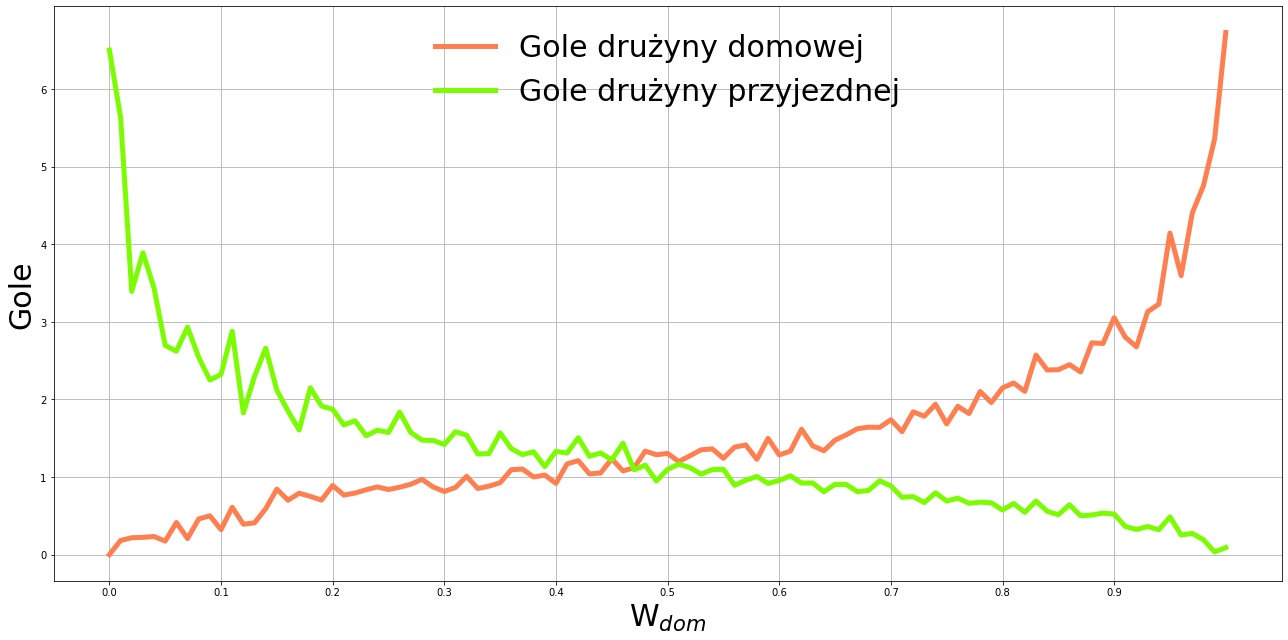

         home_score
We_home            
0.96       3.593407
0.97       4.402597
0.98       4.753425
0.99       5.355932
1.00       6.727273
         away_score
We_home            
0.00       6.500000
0.01       5.636364
0.02       3.391304
0.03       3.888889
0.04       3.433333
0.05       2.695652
0.06       2.620690
0.07       2.931034
0.08       2.540541
0.09       2.250000
0.10       2.321429
0.11       2.878049
0.12       1.826087
0.13       2.295455
0.14       2.659091


In [168]:
#nowe

df_best = estymuj_arek(df_own,10,200,40)[0] #estymacja najlepszego rankingu estymuj_wyniki 300, 70

df_best['We_away'] = 1-df_best['We_home']

df_train = df_best.tail(20000).head(16000).copy()
df_test = df_best.tail(4000).copy()

df_home = df_train.loc[df_train['neutral']==False].copy()
df_home['We_home'] = round(df_home['We_home'],2)
x = df_home[['We_home','home_score']].sort_values(by=['We_home']).groupby(['We_home']).mean()
y = df_home[['We_home','away_score']].sort_values(by=['We_home']).groupby(['We_home']).mean()

fig, ax =plt.subplots(figsize=(18,9))
ax.plot(x, linestyle='-', label = "Gole drużyny domowej",color="coral", linewidth = 5)
ax.plot(y, linestyle='-',label = "Gole drużyny przyjezdnej",color='lawngreen', linewidth = 5)
ax.set_xticks(np.arange(0, 1, 0.1))
ax.set_yticks(np.arange(0, 7., 1))
ax.grid()
font = {'color':  'black','size': 30}
ax.set_xlabel('W${_{dom}}$',fontdict=font)
ax.set_ylabel("Gole",fontdict=font)
leg=ax.legend(frameon=False,fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.tight_layout()
plt.show()

#fig.savefig("nonneutral.png",dpi=500)


print(x.tail(5))
print(y.head(15))

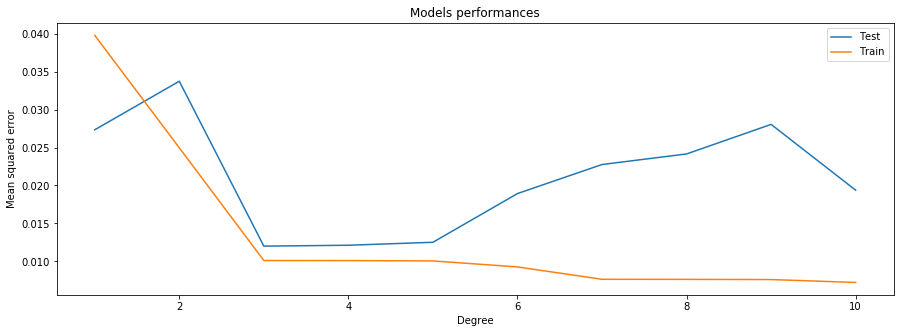

Test errors:  [0.02734133759783724, 0.03374101173663223, 0.01200606411780407, 0.012125402674337326, 0.012514851376988944, 0.018935489724214084, 0.022765048513302837, 0.024157015586201987, 0.02805431757036797, 0.01938168541423104]


In [169]:
we_home = x[x.index.values<0.93].index.values.reshape(-1,1)
goals_home = x[x.index.values<0.93].home_score.values.reshape(-1,1)

errors_train = []
errors_test = []

model = LinearRegression() 

for order in range(1,11):
    
    X_train, X_test, y_train, y_test = train_test_split(we_home, goals_home, test_size=0.3, random_state=43)
        
    poly = PolynomialFeatures(order, include_bias = False)
    X_order = poly.fit_transform(X_train)

    model.fit(X_order, y_train)
    y_to_error_train = model.predict(X_order)
    errors_train.append(mean_squared_error(y_train,y_to_error_train))

    
    X_order_test = poly.fit_transform(X_test)
    
    y_to_error_test = model.predict(X_order_test)
    errors_test.append(mean_squared_error(y_test,y_to_error_test))
    

plt.figure(figsize = (15,5)) 
plt.title("Models performances")
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.plot(range(1,11),errors_test, label = "Test")
plt.plot(range(1,11),errors_train, label = "Train")
plt.legend()
plt.show()

print("Test errors: ", errors_test)

In [170]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

search = GridSearchCV(pipeline,
                      {'model__alpha': np.arange(0.1,10,0.1)},
                          cv = cv,
                          scoring = "neg_mean_squared_error",
                          verbose = 3,
                          n_jobs=-1
                      )

In [171]:
poly = PolynomialFeatures(3, include_bias = False)
X0 = poly.fit_transform(we_home)

X_train, X_test, y_train, y_test = train_test_split(X0, goals_home, test_size=0.3, random_state=43)

results_split = search.fit(X_train, y_train)
best_model_split = results_split.best_estimator_

y_pred = best_model_split.predict(X_test)
print("Mean squared error equals: {0}".format(mean_squared_error(y_pred, y_test)))
print("Score: ", best_model_split.score(X_test,y_test))

Fitting 30 folds for each of 99 candidates, totalling 2970 fits
Mean squared error equals: 0.018786255969174083
Score:  0.9683505532095561


In [20]:
print(best_model_split.named_steps['model'].coef_,best_model_split.named_steps['model'].intercept_)

[[1.00943976 0.55273407 1.17541127]] [0.40775205]


## 1b. Przypadek meczów na boiskach nie neutralnych dla zespołu gospadarza z We_home>=0.93.

In [172]:
x11 = 0.93
x21 = 1
y11 = y.loc[y.index.values==x11].away_score.values.reshape(-1,1)
y21 = y.loc[y.index.values==x21].away_score.values.reshape(-1,1)
a_away1 = (y21-y11)/(x21-x11)
b_away1 = y11 - a_away1*x11
def home_big_we_home(x):
    return a_away1*x+b_away1

In [24]:
print(a_away1, b_away1)

[[-6.44499179]] [[6.52832512]]


## 2a. Przypadek meczów na boiskach nie neutralnych dla zespołu przyjezdnego z We_home>0.07.

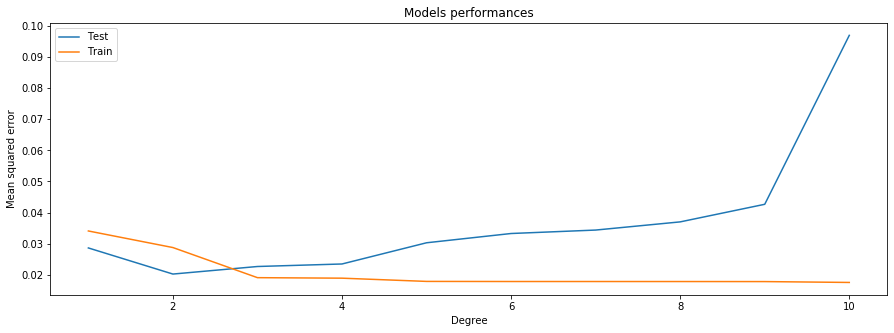

Test errors:  [0.028641959461567026, 0.02025730351849961, 0.022683417401005972, 0.02349247533902229, 0.030303736985638003, 0.033280728647173206, 0.0343885376701199, 0.0370144523996503, 0.04266393356017724, 0.09692613292863593]


In [173]:
we_home = y[y.index.values>0.07].index.values.reshape(-1,1)
goals_away = y[y.index.values>0.07].away_score.values.reshape(-1,1)

errors_train = []
errors_test = []

model = LinearRegression() 

for order in range(1,11):
    
    X_train, X_test, y_train, y_test = train_test_split(we_home, goals_away, test_size=0.3, random_state=43)
        
    poly = PolynomialFeatures(order, include_bias = False)
    X_order = poly.fit_transform(X_train)

    model.fit(X_order, y_train)
    y_to_error_train = model.predict(X_order)
    errors_train.append(mean_squared_error(y_train,y_to_error_train))

    
    X_order_test = poly.fit_transform(X_test)
    
    y_to_error_test = model.predict(X_order_test)
    errors_test.append(mean_squared_error(y_test,y_to_error_test))
    

plt.figure(figsize = (15,5)) 
plt.title("Models performances")
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.plot(range(1,11),errors_test, label = "Test")
plt.plot(range(1,11),errors_train, label = "Train")
plt.legend()
plt.show()

print("Test errors: ", errors_test)

In [174]:
poly2 = PolynomialFeatures(3, include_bias = False)
X0 = poly2.fit_transform(we_home)

X_train, X_test, y_train, y_test = train_test_split(X0, goals_away, test_size=0.3, random_state=43)

results_split = search.fit(X_train, y_train)
best_model_split_away = results_split.best_estimator_

y_pred = best_model_split_away.predict(X_test)
print("Mean squared error equals: {0}".format(mean_squared_error(y_pred, y_test)))
print(y_pred, y_test)
print("Score: ", best_model_split_away.score(X_test,y_test))

Fitting 30 folds for each of 99 candidates, totalling 2970 fits
Mean squared error equals: 0.017942007650482372
[[2.22820287]
 [0.75805621]
 [0.46922752]
 [1.7971    ]
 [1.92062786]
 [1.06961769]
 [0.74082705]
 [0.38279425]
 [0.57107403]
 [1.98531776]
 [0.88131789]
 [1.21384362]
 [2.30257262]
 [0.5033276 ]
 [1.85791028]
 [2.12087451]
 [2.26510057]
 [0.58796351]
 [1.08950599]
 [0.31189444]
 [1.8890266 ]
 [1.5983455 ]
 [0.32979799]
 [1.12996549]
 [0.36523977]
 [1.04994619]
 [0.417611  ]
 [0.55417382]] [[2.32142857]
 [0.8852459 ]
 [0.5       ]
 [1.53164557]
 [1.91489362]
 [1.03680982]
 [0.73825503]
 [0.32307692]
 [0.65838509]
 [1.60465116]
 [0.92307692]
 [1.43564356]
 [2.54054054]
 [0.51308901]
 [1.67123288]
 [2.29545455]
 [2.25      ]
 [0.57391304]
 [1.12121212]
 [0.25274725]
 [1.87272727]
 [1.41860465]
 [0.48571429]
 [1.09821429]
 [0.36206897]
 [1.09448819]
 [0.52238806]
 [0.54411765]]
Score:  0.9605493955683104


In [39]:
print(best_model_split_away.named_steps['model'].coef_,best_model_split_away.named_steps['model'].intercept_)

[[-1.75133191 -0.48479231  0.19308858]] [2.21033208]


## 2b. Przypadek meczów na boiskach nie neutralnych dla zespołu przyjezdnego z We_home<=0.07.

In [175]:
x1 = 0.01
x2 = 0.07
y1 = y.loc[y.index.values==x1].away_score.values.reshape(-1,1)
y2 = y.loc[y.index.values==x2].away_score.values.reshape(-1,1)
a_away = (y2-y1)/(x2-x1)
b_away = y1 - a_away*x1
def away_small_we_home(x):
    return a_away*x+b_away

In [46]:
print(a_away, b_away)

[[-72.22222222]] [[7.55555556]]


## 3a. Przypadek meczów na boiskach neutralnych z We<0.8.

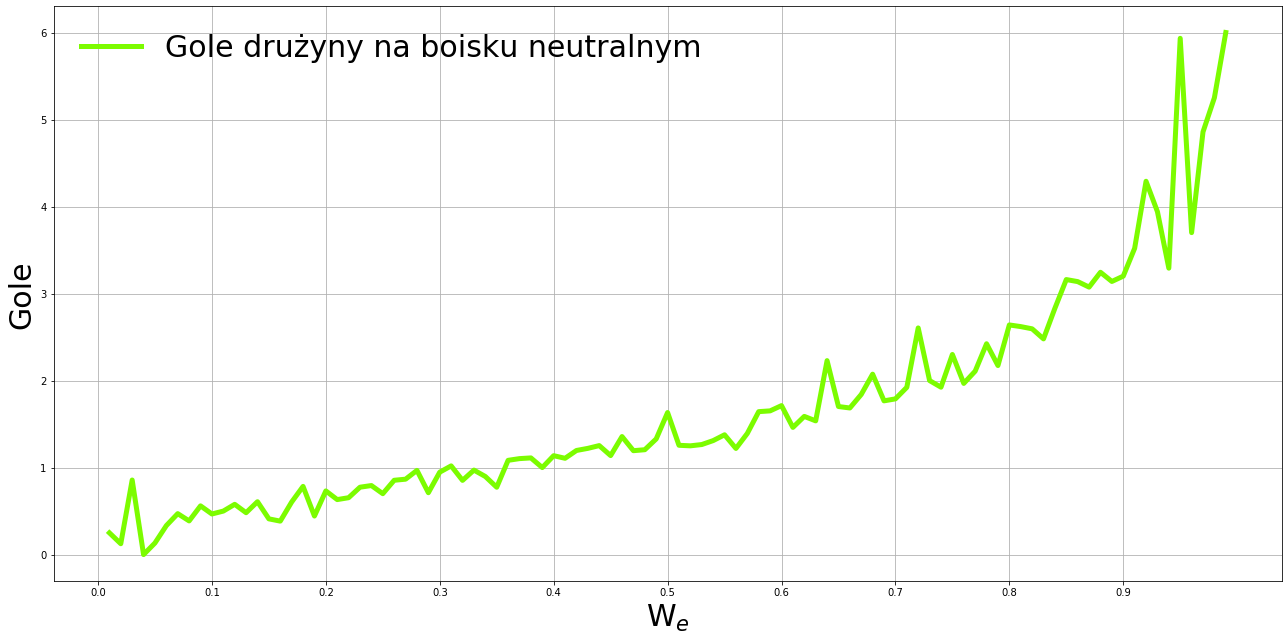

         home_score
We_home            
0.85       3.160714
0.86       3.137255
0.87       3.074074
0.88       3.244444
0.89       3.138889
0.90       3.200000
0.91       3.520000
0.92       4.290323
0.93       3.941176
0.94       3.291667
0.95       5.933333
0.96       3.700000
0.97       4.857143
0.98       5.250000
0.99       6.000000


In [176]:
df_neutral1 = df_train.loc[df_train['neutral']==True].copy()
df_neutral2 = df_train.loc[df_train['neutral']==True].copy()

df_neutral2 = df_neutral2.drop(columns = ['We_home','home_score'])
df_neutral2 = df_neutral2.rename(columns={'We_away': 'We_home', 'away_score': 'home_score'})

df_neutral = pd.concat([df_neutral1[['We_home','home_score']], df_neutral2[['We_home','home_score']]])

df_neutral['We_home'] = round(df_neutral['We_home'],2)

x_neutral = df_neutral.sort_values(by=['We_home']).groupby(['We_home']).mean()

fig, ax =plt.subplots(figsize=(18,9))
ax.plot(x_neutral, linestyle='-',label = "Gole drużyny na boisku neutralnym",color='lawngreen', linewidth = 5)
ax.set_xticks(np.arange(0, 1, 0.1))
ax.set_yticks(np.arange(0, 7., 1))
ax.grid()
font = {'color':  'black','size': 30}
ax.set_xlabel('W${_{e}}$',fontdict=font)
ax.set_ylabel("Gole",fontdict=font)
leg=ax.legend(frameon=False,fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.tight_layout()
plt.show()

fig.savefig("neutral.png",dpi=500)

print(x_neutral.tail(15))

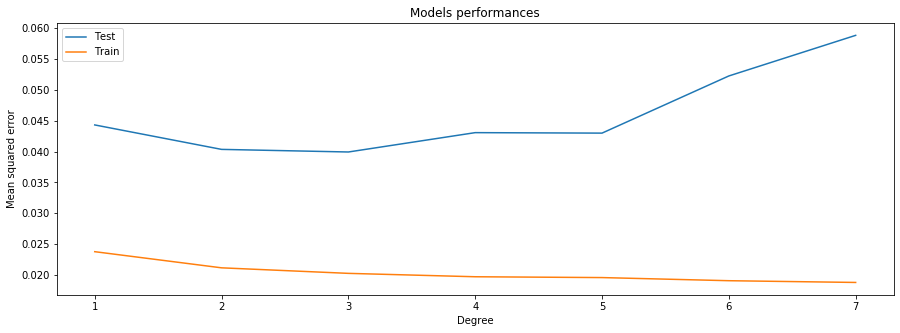

Test errors:  [0.04431779374118095, 0.04035562859851983, 0.039933409123417814, 0.04306867125410113, 0.042991596916959474, 0.05225317102237822, 0.058832738207384515]


In [177]:
we = x_neutral[x_neutral.index.values<0.8].index.values.reshape(-1,1)
goals = x_neutral[x_neutral.index.values<0.8].home_score.values.reshape(-1,1)

errors_train = []
errors_test = []

model = LinearRegression() 

for order in range(1,8):
    
    X_train, X_test, y_train, y_test = train_test_split(we, goals, test_size=0.3, random_state=43)
        
    poly = PolynomialFeatures(order, include_bias = False)
    X_order = poly.fit_transform(X_train)

    model.fit(X_order, y_train)
    y_to_error_train = model.predict(X_order)
    errors_train.append(mean_squared_error(y_train,y_to_error_train))

    
    X_order_test = poly.fit_transform(X_test)
    
    y_to_error_test = model.predict(X_order_test)
    errors_test.append(mean_squared_error(y_test,y_to_error_test))
    

plt.figure(figsize = (15,5)) 
plt.title("Models performances")
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.plot(range(1,8),errors_test, label = "Test")
plt.plot(range(1,8),errors_train, label = "Train")
plt.legend()
plt.show()

print("Test errors: ", errors_test)

In [178]:
poly3 = PolynomialFeatures(2, include_bias = False)
X0 = poly3.fit_transform(we)

X_train, X_test, y_train, y_test = train_test_split(X0, goals, test_size=0.3, random_state=43)

results_split = search.fit(X_train, y_train)
best_model_split_neutral = results_split.best_estimator_

y_pred = best_model_split_neutral.predict(X_test)
print("Mean squared error equals: {0}".format(mean_squared_error(y_pred, y_test)))
print("Score: ", best_model_split_neutral.score(X_test,y_test))

Fitting 30 folds for each of 99 candidates, totalling 2970 fits
Mean squared error equals: 0.04281088484575243
Score:  0.8970183740437006


In [51]:
print(best_model_split_neutral.named_steps['model'].coef_,best_model_split_neutral.named_steps['model'].intercept_)

[[1.37363058 1.59936477]] [0.31460217]


## 3b. Przypadek meczów na boiskach neutralnych z We>=0.8.

In [179]:
x111 = 0.8
x211 = 0.95
y111 = x_neutral.loc[x_neutral.index.values==x111].home_score.values.reshape(-1,1)
y211 = x_neutral.loc[x_neutral.index.values==x211].home_score.values.reshape(-1,1)
a_neutral = (y211-y111)/(x21-x111)
b_neutral = y111 - a_neutral*x111
def neutral(x):
    return a_neutral*x+b_neutral

In [53]:
print(a_neutral, b_neutral)

[[5.97222222]] [[-2.13888889]]


# Podsumowanie

best_model_split(We_home) - model dla home z We_home < 0.93 - 3 potega

home_big_we_home(We_home) - model liniowy dla We_home >= 0.93
                                              
best_model_split_away(We_home) - model dla away z We_home > 0.07 - 3 potega

away_small_we_home(We_home) - model liniowy dla We_home <= 0.07
                                              
best_model_split_neutral(We) - model dla neutralnych meczy We < 0.8 - 2 potega
                                              
neutral(We) - model liniowy dla We >= 0.8

# Predykcja oczekiwanej liczby goli na podstawie We, by móc estymować wyniki z rozkładu Poissona.

In [128]:
df_goals = df_best.copy()
for i in range(2,4):
    df_goals['We_home'+str(i)] = df_goals['We_home']**i
    df_goals['We_away'+str(i)] = df_goals['We_away']**i

df_goals['home_goals'] = 0.
df_goals['away_goals'] = 0.
for index, row in df_goals.iterrows():
    if (row['neutral']==True) and (row['We_home']>=0.8):
        df_goals.at[index, 'home_goals'] = neutral(row['We_home'])
        df_goals.at[index, 'away_goals'] = float(best_model_split_neutral.predict([row[['We_away','We_away2']].to_list()]))
    elif (row['neutral']==True) and (row['We_away']>=0.8):
        df_goals.at[index, 'away_goals'] = neutral(row['We_away'])
        df_goals.at[index, 'home_goals'] = float(best_model_split_neutral.predict([row[['We_home','We_home2']].to_list()]))
    elif (row['neutral']==False) and (row['We_home']>0.07):
        df_goals.at[index, 'away_goals'] = best_model_split_away.predict([row[['We_home','We_home2','We_home3']].to_list()])
        if(row['We_home']<0.93):
            df_goals.at[index, 'home_goals'] = best_model_split.predict([row[['We_home','We_home2','We_home3']].to_list()])
        else:
            df_goals.at[index, 'home_goals'] = home_big_we_home(row['We_home'])
    elif (row['neutral']==False) and (row['We_home']<=0.07):
        df_goals.at[index, 'home_goals'] = best_model_split.predict([row[['We_home','We_home2','We_home3']].to_list()])
        df_goals.at[index, 'away_goals'] = away_small_we_home(row['We_home'])
    else:
        df_goals.at[index, 'home_goals'] = float(best_model_split_neutral.predict([row[['We_home','We_home2']].to_list()]))
        df_goals.at[index, 'away_goals'] = float(best_model_split_neutral.predict([row[['We_away','We_away2']].to_list()]))
    
df_goals

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,I,...,We_home,We_away,W_home-We_home,W_away-We_away,We_home2,We_away2,We_home3,We_away3,home_goals,away_goals
22617,2000-01-04,Egypt,Togo,2,1,Friendly,Aswan,Egypt,False,10,...,0.864097,0.135903,0.135903,-0.135903,0.746664,0.018470,0.645190,0.002510,2.488170,0.469339
22618,2000-01-07,Tunisia,Togo,7,0,Friendly,Tunis,Tunisia,False,10,...,0.811273,0.188727,0.188727,-0.188727,0.658164,0.035618,0.533951,0.006722,2.214981,0.574390
22619,2000-01-08,Trinidad and Tobago,Canada,0,0,Friendly,Port of Spain,Trinidad and Tobago,False,10,...,0.291041,0.708959,0.208959,-0.208959,0.084705,0.502623,0.024653,0.356339,0.816500,1.669628
22620,2000-01-09,Burkina Faso,Gabon,1,1,Friendly,Ouagadougou,Burkina Faso,False,10,...,0.723004,0.276996,-0.223004,0.223004,0.522734,0.076727,0.377939,0.021253,1.833657,0.750063
22621,2000-01-09,Guatemala,Armenia,1,1,Friendly,Los Angeles,United States,True,10,...,0.674619,0.325381,-0.174619,0.174619,0.455111,0.105873,0.307027,0.034449,1.976128,0.921761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False,25,...,0.887420,0.112580,0.112580,-0.112580,0.787514,0.012674,0.698855,0.001427,2.620660,0.422845
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False,25,...,0.486571,0.513429,0.513429,-0.513429,0.236752,0.263609,0.115197,0.135344,1.161449,1.234360
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False,25,...,0.405219,0.594781,0.594781,-0.594781,0.164203,0.353764,0.066538,0.210412,1.006363,1.410317
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False,25,...,0.726067,0.273933,0.273933,-0.273933,0.527174,0.075039,0.382764,0.020556,1.845459,0.743947


# Wyznaczanie konkretnych prawdopodobieństw do własnego rankingu.

In [129]:
#mu w poissonie to oczekiwana liczba goli, a x to liczba goli jakiej prawdopodobienstwo licze,
#traktuje je jako niezalezne

#Maher (1982) proponuje niezalezne Poissony na gole

df_goals['We_home_Poisson'] = 0.
df_goals['We_draw_Poisson'] = 0.
df_goals['We_away_Poisson'] = 0.
suma = 0
draw = 0

#licze tylko dla 8000 ostatnich bo i tak tylko na nich porownuje
for index, row in df_goals.tail(8000).iterrows():
    for away in range(30):
        for home in range(away, 30):
            if(away!=home):
                suma = suma + poisson.pmf(home, row['home_goals'])*poisson.pmf(away, row['away_goals'])
            else:
                draw = draw + poisson.pmf(home, row['home_goals'])*poisson.pmf(away, row['away_goals'])
    df_goals.at[index, 'We_home_Poisson'] = suma
    df_goals.at[index, 'We_draw_Poisson'] = draw
    #df_goals.at[index, 'We_away_Poisson'] = 1 - draw - suma
    print(index, suma, draw, 1-suma-draw)
    suma = 0
    draw = 0
    
df_goals[['We_home', 'We_home_Poisson', 'We_draw_Poisson', 'We_away_Poisson']]

35421 0.31065310421442566 0.2745619594793837 0.4147849363061907
35422 0.7651388257442877 0.16073390218824773 0.07412727206746456
35423 0.28582230335261105 0.24684542513394733 0.4673322715134416
35424 0.19055375322742077 0.2454818842608245 0.5639643625117547
35425 0.3124356378677904 0.2747328580757226 0.412831504056487
35426 0.7974608270550824 0.13429659641159336 0.06824257653332427
35427 0.11147424791734435 0.20247364229075257 0.686052109791903
35428 0.16725514848181064 0.21097328314917674 0.6217715683690126
35429 0.760812642244977 0.1629857743527693 0.07620158340225366
35430 0.5459945697076873 0.24924880648139686 0.2047566238109158
35431 0.4799451130033105 0.2648538567154024 0.25520103028128704
35432 0.5973971753140519 0.2333205990099095 0.1692822256760386
35433 0.6836538590001163 0.19979657661664987 0.1165495643832338
35434 0.7230689398301485 0.18178474596843597 0.0951463142014155
35435 0.7092559777612382 0.18828559063600442 0.10245843160275742
35436 0.5311470835959053 0.235523612794

35550 0.4395994310628076 0.2714347813784363 0.2889657875587562
35551 0.30360461601282335 0.27381976320819834 0.42257562077897826
35552 0.5026930891643622 0.2601294634433531 0.23717744739228475
35553 0.7378763800794372 0.17459046620875934 0.08753315371180342
35554 0.011868419853688587 0.04305949336569351 0.9450720867806179
35555 0.21088191953712143 0.25310640335534296 0.5360116771075356
35556 0.26562413441043586 0.2679088759097313 0.46646698967983286
35557 0.2905071990122146 0.24756255938657587 0.46193024160120955
35558 0.8647683751619925 0.10314038765643585 0.0320912371815717
35559 0.4890271022893721 0.2630524700700299 0.24792042764059802
35560 0.12512369084235478 0.2116330656310187 0.6632432435266266
35561 0.3675715620392384 0.27686459115175466 0.355563846809007
35562 0.42206812763730706 0.27353573759923266 0.3043961347634603
35563 0.6855410886416219 0.19897201859055744 0.11548689276782068
35564 0.47767942030971844 0.26528539749217167 0.2570351821981099
35565 0.23748399197831552 0.261

35679 0.7068428812408227 0.17942706492833868 0.11373005383083859
35680 0.8489389025020722 0.11305626331004982 0.03800483418787802
35681 0.27351189799816356 0.26941166312650827 0.4570764388753282
35682 0.6948440952337308 0.1948515674086231 0.11030433735764608
35683 0.0018416466781380082 0.008813809027876835 0.9893445442939851
35684 0.3018629586740284 0.27361986230435215 0.4245171790216194
35685 0.8600494184485359 0.1061286676258999 0.03382191392556422
35686 0.4395994310628076 0.2714347813784363 0.2889657875587562
35687 0.4754159114099037 0.2657093390657588 0.25887474952433753
35688 0.7442060185549452 0.17144400336115104 0.08434997808390379
35689 0.4618879055879701 0.2680915221516974 0.2700205722603325
35690 0.760812642244977 0.1629857743527693 0.07620158340225366
35691 0.3536722301285977 0.2768806180459316 0.36944715182547067
35692 0.5730446816559621 0.24126014714348754 0.18569517120055035
35693 0.0882459635650372 0.18480730201385373 0.726946734421109
35694 0.36556412278220923 0.2768888

35808 0.2549217600582523 0.265627629865424 0.4794506100763237
35809 0.7549094273181486 0.16602619256230142 0.07906438011955
35810 0.2291865255083515 0.2589468949228359 0.5118665795688127
35811 0.21725250942007227 0.2552459858030681 0.5275015047768596
35812 0.3635638683225283 0.27690572964286064 0.35953040203461106
35813 0.8363384114270991 0.12073360851276474 0.04292798006013618
35814 0.2783425640435 0.27025896940547606 0.45139846655102395
35815 0.5141021751208819 0.2574978781299555 0.22839994674916264
35816 0.3524052132056489 0.25310222161684476 0.39449256517750636
35817 0.8179913687376869 0.13158181167377317 0.05042681958853998
35818 0.6358870427228477 0.21938075234909996 0.14473220492805236
35819 0.8105024371925557 0.13589982939476303 0.053597733412681314
35820 0.19399534641956243 0.24686043212240746 0.5591442214580301
35821 0.3818198613493566 0.2764846052219395 0.34169553342870385
35822 0.5048570247959348 0.2408117085997055 0.2543312666043598
35823 0.5952055914085074 0.2340634884187

35936 0.6373897340719926 0.2057882669826828 0.1568219989453246
35937 0.5049740362078649 0.259617133557029 0.23540883023510617
35938 0.14169784271688146 0.19750460279592058 0.660797554487198
35939 0.3575832406889187 0.2532569631600117 0.3891597961510695
35940 0.4913017425473957 0.2625835234553278 0.2461147339972764
35941 0.5440654441421395 0.2326151145894013 0.22331944126845918
35942 0.6338019834842508 0.22017859515909863 0.1460194213566506
35943 0.694134278406635 0.1846523203472804 0.1212134012460846
35944 0.3000075405200689 0.24888090602466553 0.45111155345526566
35945 0.13285212684564796 0.19220058734155146 0.6749472858128006
35946 0.6253945202989866 0.22334652655969395 0.15125895314131949
35947 0.161214925255516 0.2080216809087732 0.6307633938357109
35948 0.7074869030800324 0.18910350195997583 0.1034095949599918
35949 0.2905071990122146 0.24756255938657587 0.46193024160120955
35950 0.39429415086688646 0.275860258839712 0.32984559029340155
35951 0.3219805635898287 0.25125966757665397

36064 0.610438513029748 0.2287856058567301 0.16077588111352184
36065 0.3524052132056489 0.25310222161684476 0.39449256517750636
36066 0.507255556320381 0.25909775382625944 0.23364668985335957
36067 0.6682459382801813 0.20638500114487796 0.12536906057494074
36068 0.6379651829626869 0.21858075372080654 0.14345406331650656
36069 0.22783041093615433 0.2585461430399045 0.5136234460239413
36070 0.4700307298374573 0.24647266582249863 0.2834966043400441
36071 0.04099906418146202 0.09939928317188527 0.8596016526466527
36072 0.7057084947300817 0.1899223665111848 0.10436913875873352
36073 0.6545542659045158 0.19977391791779003 0.14567181617769415
36074 0.6966777193952325 0.1940284930366513 0.10929378756811622
36075 0.7410605959415979 0.1730129243764465 0.0859264796819556
36076 0.3785478455964768 0.25343403749818577 0.3680181169053374
36077 0.22331944126845873 0.23261511458940132 0.54406544414214
36078 0.5730446816559621 0.24126014714348754 0.18569517120055035
36079 0.2640709848803945 0.2675952829

36193 0.16725514848181064 0.21097328314917674 0.6217715683690126
36194 0.7394733351889491 0.173800642863107 0.0867260219479439
36195 0.04033055385862675 0.09841201081296605 0.8612574353284073
36196 0.6338019834842508 0.22017859515909863 0.1460194213566506
36197 0.4808027214421074 0.24488912747674102 0.27430815108115164
36198 0.44569824937579317 0.24948083102100774 0.3048209196031991
36199 0.05819472687597124 0.12248042766090698 0.8193248454631218
36200 0.3601823908345502 0.2533178051496909 0.38649980401575884
36201 0.2457757776911801 0.23878632003057138 0.5154379022782485
36202 0.20248094558431853 0.2256892342617965 0.571829820153885
36203 0.39850301109115915 0.2755897641272578 0.32590722478158307
36204 0.23742591160335313 0.23663988102631017 0.5259342073703367
36205 0.33199020262024065 0.2520461042062449 0.4159636931735145
36206 0.24606081420777057 0.26352183472784513 0.4904173510643843
36207 0.8279969551198818 0.12571364977801594 0.046289395102102254
36208 0.1403978378206913 0.196747

36323 0.6307633938357102 0.2080216809087733 0.16121492525551648
36324 0.5233186881883787 0.23718743133059034 0.23949388048103099
36325 0.8636772027132404 0.09696351060316277 0.039359286683596784
36326 0.6978259679172145 0.18315298889875317 0.11902104318403231
36327 0.33199020262024065 0.2520461042062449 0.4159636931735145
36328 0.62115187028638 0.22491510653647168 0.15393302317714835
36329 0.5186669173064121 0.25639710117977577 0.2249359815138121
36330 0.16270528577627869 0.2087626220382751 0.6285320921854461
36331 0.6149126693753791 0.2131632943156776 0.17192403630894326
36332 0.7336790155536982 0.16780054938215444 0.09852043506414737
36333 0.46863977802663725 0.26693522021406163 0.2644250017593011
36334 0.4264224966684054 0.2730585355457585 0.30051896778583614
36335 0.32947466511056833 0.25186545309050046 0.4186598817989312
36336 0.2878134017311521 0.5299234807958763 0.18226311747297164
36337 0.4264224966684054 0.2730585355457585 0.30051896778583614
36338 0.29840425945038757 0.273203

36454 0.25642650943660744 0.26596551691402104 0.4776079736493716
36455 0.5865399236115706 0.22165289787615125 0.19180717851227816
36456 0.3251403425082116 0.2757584999467034 0.3991011575450851
36457 0.3071125077851952 0.2742024627225237 0.41868502949228104
36458 0.22783041093615433 0.2585461430399045 0.5136234460239413
36459 0.16125413111365006 0.23220539780506763 0.6065404710812823
36460 0.7815850961121118 0.15198949621972555 0.06642540766816266
36461 0.18284090125275915 0.6401321680294323 0.1770269307178085
36462 0.05957181909848016 0.15847396974588174 0.7819542111556381
36463 0.21537821335368532 0.6053605712908923 0.1792612153554224
36464 0.4754159114099037 0.2657093390657588 0.25887474952433753
36465 0.7313917503897139 0.17776976083034735 0.09083848877993872
36466 0.361570853487583 0.27691524866952233 0.36151389784289467
36467 0.0637170683348991 0.16265716171534156 0.7736257699497593
36468 0.2475177872180301 0.26388184420919314 0.4886003685727768
36469 0.8710359301764806 0.09912819

36582 0.6985022428671799 0.19320593605805425 0.10829182107476587
36583 0.8289541534919002 0.1251462652370005 0.04589958127109933
36584 0.0284225949471456 0.0887515857770742 0.8828258192757802
36585 0.2640709848803945 0.2675952829830185 0.468333732136587
36586 0.885953150899953 0.08937453753268786 0.024672311567359176
36587 0.08064952094373451 0.17837801992859448 0.740972459127671
36588 0.6253945202989866 0.22334652655969395 0.15125895314131949
36589 0.10296325840078366 0.19632397135600552 0.7007127702432108
36590 0.20962962485940873 0.2526720993862743 0.537698275754317
36591 0.016802646960651615 0.05755435679151656 0.9256429962478319
36592 0.6930014150951825 0.1956750834109144 0.11132350149390305
36593 0.5004128525934681 0.26063468938988715 0.23895245801664472
36594 0.20469224856796203 0.2509152439312026 0.5443925075008353
36595 0.7549094273181486 0.16602619256230142 0.07906438011955
36596 0.11739058746349938 0.20654622894109195 0.6760631835954086
36597 0.43739203442132496 0.2717254057

36711 0.31065310421442566 0.2745619594793837 0.4147849363061907
36712 0.30535446866012234 0.2740139834042726 0.42063154793560503
36713 0.1849632897461803 0.2188782003468576 0.5961585099069622
36714 0.23748399197831552 0.261290754081277 0.5012252539404075
36715 0.8398531811912632 0.1186109563561203 0.04153586245261652
36716 0.31368053920665806 0.5037106528171927 0.1826088079761492
36717 0.8805217919978908 0.0929597973181345 0.026518410683974675
36718 0.7679749476126896 0.1592467408820935 0.07277831150521691
36719 0.0352846669617879 0.09069362252257049 0.8740217105156416
36720 0.41773409442363646 0.2739809237787466 0.3082849817976169
36721 0.5952055914085074 0.23406348841878769 0.17073092017270494
36722 0.5930091771825549 0.23480243083611568 0.17218839198132946
36723 0.20263318671266692 0.6189194083825003 0.1784474049048328
36724 0.5550538698512695 0.24667261542329838 0.19827351472543214
36725 0.2534250201051779 0.26528590616087105 0.48128907373395097
36726 0.8565017558617498 0.108357067

36846 0.3818198613493566 0.2764846052219395 0.34169553342870385
36847 0.4240581321177674 0.2514721851680497 0.32446968271418286
36848 0.03254832442869556 0.08629236917679248 0.8811593063945119
36849 0.5985385946402337 0.2181751914231106 0.18328621393665567
36850 0.5668551040959487 0.22699714196420478 0.20614775393984647
36851 0.5337440984848936 0.2349551355937897 0.23130076592131674
36852 0.45652277829031435 0.24824127326090745 0.29523594844877826
36853 0.3944925651775062 0.25310222161684476 0.35240521320564905
36854 0.4132697451085372 0.2522160382895988 0.334514216601864
36855 0.16725514848181064 0.21097328314917674 0.6217715683690126
36856 0.41865988179893115 0.25186545309050046 0.32947466511056844
36857 0.4808027214421074 0.24488912747674102 0.27430815108115164
36858 0.42946279629191203 0.2510366313289252 0.31950057237916285
36859 0.6329834776244077 0.2072789006563681 0.15973762171922426
36860 0.4700307298374573 0.24647266582249863 0.2834966043400441
36861 0.6978259679172145 0.18315

36975 0.5708068839750412 0.24195459612249567 0.18723851990246312
36976 0.33070573280781446 0.27610350540405604 0.3931907617881295
36977 0.6082784239610274 0.2295502135882851 0.16217136245068753
36978 0.4708959621195699 0.2665342836549628 0.26256975422546736
36979 0.4538175311402863 0.24856601476213208 0.2976164540975816
36980 0.6543301009775238 0.21211433722119868 0.13355556180127756
36981 0.7145068776751796 0.18583826546854987 0.09965485685627051
36982 0.025173971128693153 0.08036005800947331 0.8944659708618335
36983 0.6855410886416219 0.19897201859055744 0.11548689276782068
36984 0.5819589846962542 0.23843470834419092 0.1796063069595549
36985 0.3921990472141537 0.2759837496251369 0.33181720316070945
36986 0.5323504722287525 0.2529361703076734 0.21471335746357406
36987 0.8354415177236084 0.12127294943876059 0.043285532837630994
36988 0.34589340697298676 0.27673175950606455 0.3773748335209487
36989 0.804899191410758 0.13908953166865923 0.05601127692058272
36990 0.2260305237772058 0.594

37107 0.8137621115314394 0.1340280915018653 0.05220979696669531
37108 0.21854864578068434 0.25566716021222124 0.5257841940070944
37109 0.32330119387001527 0.2756306659094742 0.40106814022051057
37110 0.6421003261694949 0.2169746635499971 0.14092501028050805
37111 0.2586847279557533 0.2417767262729992 0.49953854577124746
37112 0.7092559777612382 0.18828559063600442 0.10245843160275742
37113 0.059336981475308824 0.12387805280774768 0.8167849657169435
37114 0.3556357706341666 0.27690009639036817 0.3674641329754652
37115 0.6966777193952325 0.1940284930366513 0.10929378756811622
37116 0.8600494184485359 0.1061286676258999 0.03382191392556422
37117 0.40273620318884124 0.27528777950755 0.3219760173036087
37118 0.8158933083489145 0.13279788735043993 0.05130880430064558
37119 0.1957517051171871 0.6262734639869223 0.1779748308958906
37120 0.13163626566983283 0.19144320145285165 0.6769205328773155
37121 0.3675715620392384 0.27686459115175466 0.355563846809007
37122 0.240311646532986 0.26204758829

37236 0.8965378185236463 0.07659149754759993 0.026870683928753733
37237 0.849724211340538 0.11257152835203275 0.03770426030742925
37238 0.7854849610482263 0.14987304914579103 0.06464198980598268
37239 0.8815484255457909 0.09228513288338988 0.026166441570819182
37240 0.236081817748698 0.26090761067342894 0.5030105715778731
37241 0.6285320921854456 0.2087626220382751 0.16270528577627932
37242 0.4429913456615326 0.24976571692093677 0.3072429374175306
37243 0.690393994921102 0.18615591537959306 0.12345008969930496
37244 0.7155576366594247 0.17573982584473258 0.10870253749584269
37245 0.7444727459402796 0.16289617143435917 0.09263108262536127
37246 0.16912306567763802 0.2360508394069367 0.5948260949154253
37247 0.4462466285974557 0.2705150419630734 0.2832383294394709
37248 0.3635638683225283 0.27690572964286064 0.35953040203461106
37249 0.3838826081793154 0.2763998923736655 0.33971749944701907
37250 0.5437245715091867 0.2498784300002214 0.20639699849059187
37251 0.31065310421442566 0.274561

37364 0.8389088104755873 0.11147716755352587 0.04961402197088684
37365 0.1717334725512052 0.652117631680771 0.17614889576802384
37366 0.16285161548500446 0.6617422221374825 0.17540616237751305
37367 0.15709000231575412 0.6680045904118024 0.17490540727244352
37368 0.7748982570297327 0.15558006000416877 0.06952168296609854
37369 0.17828472854777544 0.6450415954840145 0.17667367596821004
37370 0.7272551630656453 0.17065708366695295 0.10208775326740174
37371 0.8739725112319476 0.09723110535423155 0.02879638341382082
37372 0.7021238173529811 0.19156267295243057 0.1063135096945883
37373 0.7110156857470178 0.1874687019566645 0.1015156122963177
37374 0.2853221603126463 0.5324692409318247 0.18220859875552897
37375 0.25684616430433366 0.5618225212370961 0.18133131445857031
37376 0.6827676580143389 0.18917347018652178 0.1280588717991393
37377 0.6441571429680218 0.21616875859220738 0.13967409843977077
37378 0.804899191410758 0.13908953166865923 0.05601127692058272
37379 0.8733953204812067 0.097604

37492 0.4981334634490527 0.26113275876567565 0.24073377778527172
37493 0.7457641758773307 0.1706628989981012 0.08357292512456813
37494 0.13111167388026487 0.21539624465444873 0.6534920814652864
37495 0.8854806331982236 0.08968802138959057 0.02483134541218586
37496 0.4731547158091239 0.2661256457979309 0.26071963839294526
37497 0.3057420053549483 0.5117118751335259 0.18254611951152588
37498 0.11537839357691326 0.20517912324153098 0.6794424831815558
37499 0.24898267449051603 0.26423831540517806 0.4867790101043059
37500 0.7549094273181486 0.16602619256230142 0.07906438011955
37501 0.21468233821992808 0.25439674174651244 0.5309209200335594
37502 0.41773409442363646 0.2739809237787466 0.3082849817976169
37503 0.17671292992240792 0.21532950343557794 0.6079575666420141
37504 0.52779218244936 0.2541157210702215 0.2180920964804185
37505 0.5889590888228169 0.22096507191766648 0.19007583925951663
37506 0.33070573280781446 0.27610350540405604 0.3931907617881295
37507 0.27191803734758735 0.26912000

37621 0.7280914836108318 0.17937064743412867 0.09253786895503957
37622 0.6948440952337308 0.1948515674086231 0.11030433735764608
37623 0.610438513029748 0.2287856058567301 0.16077588111352184
37624 0.4822128591266605 0.2644147539709417 0.2533723869023977
37625 0.7457641758773307 0.1706628989981012 0.08357292512456813
37626 0.8002602900162201 0.14170388652986415 0.058035823453915725
37627 0.6482488135950267 0.21455169305048347 0.1371994933544898
37628 0.27430815108115153 0.24488912747674102 0.4808027214421074
37629 0.4551636603838557 0.26917750085181547 0.27565883876432884
37630 0.7721574646431439 0.15703779627265896 0.0708047390841971
37631 0.26562413441043586 0.2679088759097313 0.46646698967983286
37632 0.610438513029748 0.2287856058567301 0.16077588111352184
37633 0.25642650943660744 0.26596551691402104 0.4776079736493716
37634 0.4890271022893721 0.2630524700700299 0.24792042764059802
37635 0.20962962485940873 0.2526720993862743 0.537698275754317
37636 0.3124356378677904 0.2747328580

37750 0.015900359305527117 0.054972955051683974 0.9291266856427889
37751 0.016343991350517034 0.05624566186501054 0.9274103467844724
37752 0.44402684034809475 0.27082958902714116 0.28514357062476414
37753 0.1342251148516578 0.21729448215562094 0.6484804029927212
37754 0.6760179980500515 0.20309368431475378 0.12088831763519475
37755 0.8593519250804013 0.1065680098523723 0.03408006506722644
37756 0.6643101409854505 0.2080267861392155 0.12766307287533402
37757 0.4351889904722879 0.27200803763433057 0.29280297189338156
37758 0.45292895400659183 0.2695237567742994 0.27754728921910876
37759 0.3756720132030455 0.2766928372189172 0.34763514957803726
37760 0.830845493934444 0.1240220599747202 0.045132446090835845
37761 0.2549217600582523 0.265627629865424 0.4794506100763237
37762 0.6338019834842508 0.22017859515909863 0.1460194213566506
37763 0.26562413441043586 0.2679088759097313 0.46646698967983286
37764 0.6482488135950267 0.21455169305048347 0.1371994933544898
37765 0.7966883215313603 0.1437

37879 0.5973971753140519 0.2333205990099095 0.1692822256760386
37880 0.39850301109115915 0.2755897641272578 0.32590722478158307
37881 0.8825573304005073 0.09162075369797056 0.02582191590152212
37882 0.6039417346260039 0.23106918069017088 0.16498908468382525
37883 0.8489389025020722 0.11305626331004982 0.03800483418787802
37884 0.25946010539556247 0.2666295394154288 0.4739103551890087
37885 0.7394733351889491 0.173800642863107 0.0867260219479439
37886 0.33257675884077387 0.27620549244260706 0.3912177487166191
37887 0.5300718056405196 0.25352912741065564 0.21639906694882477
37888 0.8520408809522738 0.11113722590497431 0.036821893142751874
37889 0.7693786571051306 0.1585074877521089 0.07211385514276045
37890 0.16125413111365006 0.23220539780506763 0.6065404710812823
37891 0.4264224966684054 0.2730585355457585 0.30051896778583614
37892 0.8756743627869977 0.09612657807433696 0.028199059138665314
37893 0.288225416169876 0.27182344695706745 0.4399511368730565
37894 0.6253945202989866 0.223346

38011 0.7651388257442877 0.16073390218824773 0.07412727206746456
38012 0.7762544511709714 0.1548557474574724 0.06888980137155623
38013 0.8542996448393614 0.1097325202562084 0.035967834904430215
38014 0.48448252749184645 0.26396812808346976 0.25154934442468374
38015 0.5640734690091247 0.2440079565921065 0.1919185743987688
38016 0.5995838072736679 0.23257385563935173 0.16784233708698038
38017 0.17424056516853328 0.23843896758102437 0.5873204672504424
38018 0.5618227686538044 0.24468212810191978 0.1934951032442758
38019 0.31368053920665806 0.5037106528171927 0.1826088079761492
38020 0.6623300458393689 0.20884640614646402 0.12882354801416704
38021 0.2534250201051779 0.26528590616087105 0.48128907373395097
38022 0.23889392718950184 0.26167076567867464 0.4994353071318235
38023 0.5369043770245272 0.2517314476083887 0.21136417536708407
38024 0.7378763800794372 0.17459046620875934 0.08753315371180342
38025 0.4890271022893721 0.2630524700700299 0.24792042764059802
38026 0.4731547158091239 0.2661

38140 0.05931213695612286 0.15820701935938544 0.7824808436844917
38141 0.04133979757324428 0.09989949887226829 0.8587607035544875
38142 0.7776012077388478 0.15413450876547027 0.06826428349568195
38143 0.2174739798724675 0.23079413278752534 0.5517318873400071
38144 0.2534250201051779 0.26528590616087105 0.48128907373395097
38145 0.8115974355067123 0.13527239822616596 0.053130166267121776
38146 0.6125929455294508 0.22801770789203463 0.1593893465785146
38147 0.28408322954550574 0.5337366432116416 0.1821801272428526
38148 0.39011026565909884 0.27609943319914937 0.33379030114175173
38149 0.5128001579484186 0.23930430447581236 0.24789553757576904
38150 0.27033234165928494 0.26882383039907315 0.46084382794164197
38151 0.36801811690533726 0.25343403749818577 0.378547845596477
38152 0.4700307298374573 0.24647266582249863 0.2834966043400441
38153 0.5767695415098779 0.2243618861347852 0.1988685723553369
38154 0.39984100660381977 0.2529035399475472 0.34725545344863296
38155 0.5259342073703366 0.23

38269 0.8773667576743762 0.08863873781731886 0.03399450450830492
38270 0.6866051129808872 0.18766317285256612 0.12573171416654666
38271 0.7383741925212763 0.16568334492968143 0.09594246254904223
38272 0.8323892513719106 0.11518528120459855 0.0524254674234909
38273 0.6351922785344623 0.20653439258191253 0.15827332888362522
38274 0.6978259679172145 0.18315298889875317 0.11902104318403231
38275 0.4155749493685159 0.2741915232101676 0.3102335274213165
38276 0.22135751368116546 0.23201419639257417 0.5466282899262604
38277 0.641750371580586 0.20429159924024826 0.15395802917916573
38278 0.19007583925951643 0.22096507191766648 0.5889590888228171
38279 0.8003942425869203 0.13273924234981543 0.0668665150632643
38280 0.8479528604151262 0.10625692148466209 0.04579021810021172
38281 0.5889590888228169 0.22096507191766648 0.19007583925951663
38282 0.23130076592131682 0.2349551355937897 0.5337440984848935
38283 0.35499078582029736 0.2531850958510329 0.3918241183286697
38284 0.48448252749184645 0.2639

38397 0.7748982570297327 0.15558006000416877 0.06952168296609854
38398 0.7966883215313603 0.14370074977730615 0.05961092869133358
38399 0.8299036510096861 0.12458240332818223 0.04551394566213167
38400 0.8739725112319476 0.09723110535423155 0.02879638341382082
38401 0.39850301109115915 0.2755897641272578 0.32590722478158307
38402 0.6441571429680218 0.21616875859220738 0.13967409843977077
38403 0.6948440952337308 0.1948515674086231 0.11030433735764608
38404 0.7503804324059012 0.1683335783204516 0.08128598927364716
38405 0.7003176226306035 0.19238397136210156 0.10729840600729496
38406 0.793035723118406 0.1457281773679183 0.06123609951367573
38407 0.6623300458393689 0.20884640614646402 0.12882354801416704
38408 0.11083887196820731 0.20202661574530548 0.6871345122864873
38409 0.2915854666141198 0.2723045619367438 0.43610997144913644
38410 0.5573128332959277 0.2460145406509479 0.19667262605312436
38411 0.08410738581229836 0.18134841603488128 0.7345441981528203
38412 0.11537839357691326 0.205

38525 0.34589340697298676 0.27673175950606455 0.3773748335209487
38526 0.3736364157827593 0.2767470523237046 0.3496165318935361
38527 0.550528634283529 0.24797209291944353 0.20149927279702742
38528 0.7762544511709714 0.1548557474574724 0.06888980137155623
38529 0.1382321080960305 0.21968024072933234 0.6420876511746372
38530 0.5391793361801674 0.2511198258881006 0.20970083793173194
38531 0.4708959621195699 0.2665342836549628 0.26256975422546736
38532 0.31422631065908363 0.2748977781528396 0.4108759111880767
38533 0.18605925554081826 0.24362613753311202 0.5703146069260697
38534 0.44402684034809475 0.27082958902714116 0.28514357062476414
38535 0.4799451130033105 0.2648538567154024 0.25520103028128704
38536 0.31368053920665806 0.5037106528171927 0.1826088079761492
38537 0.07394490135200225 0.17239736811284315 0.7536577305351546
38538 0.09471734585687336 0.19001648283004646 0.7152661713130802
38539 0.30535446866012234 0.2740139834042726 0.42063154793560503
38540 0.4867539861224332 0.2635140

38655 0.6911497253921406 0.1964989644190949 0.11235131018876451
38656 0.35760675387074986 0.2769123898567873 0.3654808562724628
38657 0.5206973465013359 0.23772776662091355 0.24157488687775053
38658 0.6253945202989866 0.22334652655969395 0.15125895314131949
38659 0.5141021751208819 0.2574978781299555 0.22839994674916264
38660 0.19241852049958402 0.629843770746062 0.1777377087543539
38661 0.7346534108516556 0.1761762200295177 0.08917036911882673
38662 0.5663211444133677 0.24332858717136016 0.19035026841527217
38663 0.7230689398301485 0.18178474596843597 0.0951463142014155
38664 0.5685656605998419 0.2426441050292785 0.18879023437087958
38665 0.2966717156948251 0.5209011399340431 0.18242714437113183
38666 0.507255556320381 0.25909775382625944 0.23364668985335957
38667 0.44402684034809475 0.27082958902714116 0.28514357062476414
38668 0.5459945697076873 0.24924880648139686 0.2047566238109158
38669 0.43739203442132496 0.27172540574192505 0.29088255983675004
38670 0.4574018015010627 0.2688233

38783 0.5233186881883787 0.23718743133059034 0.23949388048103099
38784 0.08280479142169764 0.15414624227757995 0.7630489663007225
38785 0.4867539861224332 0.2635140194579705 0.24973199441959626
38786 0.5668551040959487 0.22699714196420478 0.20614775393984647
38787 0.2848982641114965 0.2713218128046511 0.44377992308385233
38788 0.15682199894532448 0.20578826698268277 0.6373897340719927
38789 0.35958513147724974 0.2769174548390666 0.3634974136836836
38790 0.6395757842515625 0.2050406331287468 0.15538358261969074
38791 0.7503889547924534 0.16015209731818697 0.08945894788935965
38792 0.16879816804063458 0.2117057355855765 0.619496096373789
38793 0.20986893667912432 0.22828459999686215 0.5618464633240136
38794 0.10300333576909933 0.17137691039238853 0.7256197538385121
38795 0.39984100660381977 0.2529035399475472 0.34725545344863296
38796 0.5693467705342226 0.2263456812318009 0.20430754823397654
38797 0.28118222745532845 0.24609056392604256 0.47272720861862905
38798 0.6190211804395122 0.2256

38911 0.26718540194088786 0.26821820582776795 0.46459639223134414
38912 0.773532602239708 0.15630741903316825 0.07015997872712376
38913 0.5663211444133677 0.24332858717136016 0.19035026841527217
38914 0.8535530799987873 0.11019748785780294 0.036249432143409796
38915 0.26956879043082865 0.5486509566389502 0.18178025293022115
38916 0.7230689398301485 0.18178474596843597 0.0951463142014155
38917 0.8381102631611499 0.11966535512765054 0.04222438171119956
38918 0.6082784239610274 0.2295502135882851 0.16217136245068753
38919 0.1584020313773225 0.23075854624865377 0.6108394223740238
38920 0.29668722949170706 0.27298668084823413 0.43032608966005875
38921 0.21214145123391648 0.25353864504710694 0.5343199037189765
38922 0.3756720132030455 0.2766928372189172 0.34763514957803726
38923 0.5186669173064121 0.25639710117977577 0.2249359815138121
38924 0.7039207873805545 0.1907421139357634 0.10533709868368207
38925 0.40699305792333346 0.27495415737340345 0.31805278470326315
38926 0.7280914836108318 0.1

39041 0.2346873809732774 0.2605213923103356 0.504791226716387
39042 0.30724293741753067 0.24976571692093677 0.44299134566153253
39043 0.41865988179893115 0.25186545309050046 0.32947466511056844
39044 0.7828943508121453 0.15128080896620996 0.06582484022164473
39045 0.5693467705342226 0.2263456812318009 0.20430754823397654
39046 0.27033234165928494 0.26882383039907315 0.46084382794164197
39047 0.8230938423599746 0.12860352350372634 0.04830263413629904
39048 0.6400363087391285 0.21777869297518931 0.14218499828568215
39049 0.6296114976838376 0.2217674373722896 0.14862106494387278
39050 0.7021238173529811 0.19156267295243057 0.1063135096945883
39051 0.07337589404497123 0.7605631917980302 0.16606091415699853
39052 0.2932778303906359 0.2725372702901655 0.4341848993191987
39053 0.4551636603838557 0.26917750085181547 0.27565883876432884
39054 0.6760179980500515 0.20309368431475378 0.12088831763519475
39055 0.16125413111365006 0.23220539780506763 0.6065404710812823
39056 0.1928413548838171 0.246

39171 0.09263108262536089 0.16289617143435917 0.7444727459402799
39172 0.4942033888720072 0.2427087801858455 0.26308783094214727
39173 0.5101573074397884 0.23981460666555177 0.25002808589465986
39174 0.4025205858374792 0.2527877832618055 0.3446916309007153
39175 0.6978259679172145 0.18315298889875317 0.11902104318403231
39176 0.3472554534486326 0.25290353994754716 0.3998410066038202
39177 0.3918241183286694 0.2531850958510329 0.35499078582029764
39178 0.35499078582029736 0.2531850958510329 0.3918241183286697
39179 0.19708280710896578 0.22369123699852775 0.5792259558925065
39180 0.4267597688335172 0.25125966757665397 0.32198056358982885
39181 0.16221666974734428 0.23268724935905888 0.6050960808935968
39182 0.2117498884636264 0.22892034502125194 0.5593297665151217
39183 0.4429913456615326 0.24976571692093677 0.3072429374175306
39184 0.2586847279557533 0.2417767262729992 0.49953854577124746
39185 0.38119362609532753 0.25340635366529307 0.36540002023937945
39186 0.8891502879500891 0.081289

39302 0.6147416084700804 0.22724661427468665 0.15801177725523294
39303 0.7918001099770977 0.14641071068886638 0.06178917933403591
39304 0.5908080553802683 0.23553733358236736 0.17365461103736438
39305 0.793035723118406 0.1457281773679183 0.06123609951367573
39306 0.5482626367205713 0.24861333479958775 0.20312402847984096
39307 0.4402845566395964 0.25004045699319566 0.3096749863672079
39308 0.413421179954825 0.27439413646749033 0.3121846835776846
39309 0.1584020313773225 0.23075854624865377 0.6108394223740238
39310 0.3121169223489525 0.25030498306867754 0.43757809458236996
39311 0.8105024371925557 0.13589982939476303 0.053597733412681314
39312 0.1459118571841368 0.6801959903136169 0.17389215250224632
39313 0.3838826081793154 0.2763998923736655 0.33971749944701907
39314 0.1084177879849299 0.7214755982261628 0.17010661378890723
39315 0.4861727665230625 0.24404318401269698 0.2697840494642405
39316 0.3756720132030455 0.2766928372189172 0.34763514957803726
39317 0.2915854666141198 0.27230456

39431 0.23889392718950184 0.26167076567867464 0.4994353071318235
39432 0.31065310421442566 0.2745619594793837 0.4147849363061907
39433 0.10772624396169066 0.1998089244384387 0.6924648315998707
39434 0.8014331965683195 0.14104511853991314 0.0575216848917674
39435 0.8354415177236084 0.12127294943876059 0.043285532837630994
39436 0.006384460043304897 0.02552226779284824 0.9680932721638468
39437 0.4754159114099037 0.2657093390657588 0.25887474952433753
39438 0.2194090166307408 0.231407160889768 0.5491838224794913
39439 0.5459945697076873 0.24924880648139686 0.2047566238109158
39440 0.33070573280781446 0.27610350540405604 0.3931907617881295
39441 0.3777144966788323 0.2766310462474109 0.3456544570737568
39442 0.8169464589673769 0.13218808219242165 0.05086545884020141
39443 0.19399534641956243 0.24686043212240746 0.5591442214580301
39444 0.315018017498237 0.5023664716187436 0.18261551088301942
39445 0.2534744260133936 0.5653283054054937 0.18119726858111262
39446 0.511819764126527 0.2580380684

39561 0.44402684034809475 0.27082958902714116 0.28514357062476414
39562 0.8415675426896532 0.1175703473779426 0.04086210993240423
39563 0.2915854666141198 0.2723045619367438 0.43610997144913644
39564 0.26718540194088786 0.26821820582776795 0.46459639223134414
39565 0.5209489701779431 0.25583663818972074 0.2232143916323362
39566 0.1353193671653943 0.1937160555838988 0.6709645772507069
39567 0.6147416084700804 0.22724661427468665 0.15801177725523294
39568 0.507255556320381 0.25909775382625944 0.23364668985335957
39569 0.6543301009775238 0.21211433722119868 0.13355556180127756
39570 0.361570853487583 0.27691524866952233 0.36151389784289467
39571 0.4462466285974557 0.2705150419630734 0.2832383294394709
39572 0.33070573280781446 0.27610350540405604 0.3931907617881295
39573 0.6543301009775238 0.21211433722119868 0.13355556180127756
39574 0.3420497927804827 0.2766154196470566 0.38133478757246075
39575 0.34782672472296894 0.2767795233764484 0.37539375190058266
39576 0.30012950431163365 0.27341

39689 0.19180717851227733 0.22165289787615125 0.5865399236115714
39690 0.6056182261464499 0.21604572973826844 0.17833604411528167
39691 0.48448252749184645 0.26396812808346976 0.25154934442468374
39692 0.413421179954825 0.27439413646749033 0.3121846835776846
39693 0.3345142166018644 0.2522160382895988 0.41326974510853676
39694 0.5643549558528693 0.22764349027553962 0.20800155387159106
39695 0.16725514848181064 0.21097328314917674 0.6217715683690126
39696 0.3018629586740284 0.27361986230435215 0.4245171790216194
39697 0.518070358484218 0.23826076863128637 0.24366887288449562
39698 0.7989350219594327 0.13351501559671058 0.06754996244385675
39699 0.3575832406889187 0.2532569631600117 0.3891597961510695
39700 0.3654000202393791 0.2534063536652931 0.38119362609532775
39701 0.5154379022782489 0.23878632003057138 0.2457757776911797
39702 0.3121169223489525 0.25030498306867754 0.43757809458236996
39703 0.09263108262536089 0.16289617143435917 0.7444727459402799
39704 0.37327190558730694 0.25345

39820 0.326987498279638 0.27587995466812426 0.3971325470522377
39821 0.4890271022893721 0.2630524700700299 0.24792042764059802
39822 0.5841112679059726 0.22233661743189254 0.1935521146621349
39823 0.4799451130033105 0.2648538567154024 0.25520103028128704
39824 0.7776012077388478 0.15413450876547027 0.06826428349568195
39825 0.233300657762898 0.26013215552276103 0.506567186714341
39826 0.5482626367205713 0.24861333479958775 0.20312402847984096
39827 0.3635638683225283 0.27690572964286064 0.35953040203461106
39828 0.233300657762898 0.26013215552276103 0.506567186714341
39829 0.687419511477741 0.19814751072696346 0.11443297779529549
39830 0.5004128525934681 0.26063468938988715 0.23895245801664472
39831 0.7336790155536982 0.16780054938215444 0.09852043506414737
39832 0.41989851954934404 0.2737623305963858 0.30633914985427013
39833 0.27351189799816356 0.26941166312650827 0.4570764388753282
39834 0.8852979385912125 0.08371146585453414 0.030990595554253333
39835 0.5568050078987946 0.229550599

39949 0.5952055914085074 0.23406348841878769 0.17073092017270494
39950 0.24366887288449582 0.2382607686312863 0.5180703584842179
39951 0.5841776880832661 0.23771688293556498 0.17810542898116893
39952 0.6607975544871982 0.19750460279592058 0.14169784271688118
39953 0.05991958043732676 0.12458524898820135 0.815495170574472
39954 0.6788816862867064 0.1906861634255439 0.13043215028774968
39955 0.4132697451085372 0.2522160382895988 0.334514216601864
39956 0.6232763522569056 0.22413217752837525 0.15259147021471917
39957 0.24157488687775014 0.23772776662091355 0.5206973465013364
39958 0.3160251076534938 0.27505666116792304 0.40891823117858317
39959 0.7280914836108318 0.17937064743412867 0.09253786895503957
39960 0.4890271022893721 0.2630524700700299 0.24792042764059802
39961 0.7549094273181486 0.16602619256230142 0.07906438011955
39962 0.5026930891643622 0.2601294634433531 0.23717744739228475
39963 0.3635638683225283 0.27690572964286064 0.35953040203461106
39964 0.4395994310628076 0.271434781

40077 0.5311470835959053 0.23552361279442222 0.23332930360967244
40078 0.6439134410429082 0.2035412724656057 0.15254528649148616
40079 0.6885056278804861 0.18690912472030527 0.12458524739920865
40080 0.37327190558730694 0.25345618882538684 0.3732719055873062
40081 0.652449525591207 0.20052914081901518 0.14702133358977787
40082 0.14433476935010206 0.19901802140797048 0.6566472092419275
40083 0.6439134410429082 0.2035412724656057 0.15254528649148616
40084 0.3785478455964768 0.25343403749818577 0.3680181169053374
40085 0.4754159114099037 0.2657093390657588 0.25887474952433753
40086 0.7206423591357526 0.17354926562105058 0.10580837524319683
40087 0.7974608270550824 0.13429659641159336 0.06824257653332427
40088 0.1816226620678996 0.2174686952053536 0.6009086427267468
40089 0.4727272086186293 0.24609056392604253 0.28118222745532806
40090 0.5206973465013359 0.23772776662091355 0.24157488687775053
40091 0.5767695415098779 0.2243618861347852 0.1988685723553369
40092 0.7657425364607512 0.1528447

40205 0.36958612963252885 0.2768328933023403 0.3535809770651308
40206 0.5141021751208819 0.2574978781299555 0.22839994674916264
40207 0.28160399142978526 0.270800154877981 0.4475958536922338
40208 0.14872802793658627 0.6771194072209795 0.17415256484243424
40209 0.5663211444133677 0.24332858717136016 0.19035026841527217
40210 0.6296114976838376 0.2217674373722896 0.14862106494387278
40211 0.5026930891643622 0.2601294634433531 0.23717744739228475
40212 0.12153840014473498 0.20930715697637983 0.6691544428788853
40213 0.6317101022777474 0.22097418821455736 0.14731570950769526
40214 0.2915854666141198 0.2723045619367438 0.43610997144913644
40215 0.5437245715091867 0.2498784300002214 0.20639699849059187
40216 0.20838453890071293 0.252235782602186 0.539379678497101
40217 0.7622643233896408 0.16223237962261525 0.07550329698774397
40218 0.3635638683225283 0.27690572964286064 0.35953040203461106
40219 0.6798532009809912 0.20144551948026482 0.11870127953874396
40220 0.7050637268084544 0.180169414

40333 0.7057084947300817 0.1899223665111848 0.10436913875873352
40334 0.5095375116880587 0.2585713797940428 0.23189110851789846
40335 0.826059271521725 0.12685900086796706 0.04708172761030796
40336 0.687419511477741 0.19814751072696346 0.11443297779529549
40337 0.610438513029748 0.2287856058567301 0.16077588111352184
40338 0.09939817340601319 0.16851117283667805 0.7320906537573088
40339 0.5573128332959277 0.2460145406509479 0.19667262605312436
40340 0.7503804324059012 0.1683335783204516 0.08128598927364716
40341 0.41989851954934404 0.2737623305963858 0.30633914985427013
40342 0.33070573280781446 0.27610350540405604 0.3931907617881295
40343 0.4112728802020534 0.2745887726271924 0.3141383471707543
40344 0.5482626367205713 0.24861333479958775 0.20312402847984096
40345 0.33445568652729907 0.27630088226092736 0.38924343121177357
40346 0.5841776880832661 0.23771688293556498 0.17810542898116893
40347 0.7776012077388478 0.15413450876547027 0.06826428349568195
40348 0.5391793361801674 0.2511198

40461 0.24317052824554225 0.26279143633106555 0.49403803542339214
40462 0.39011026565909884 0.27609943319914937 0.33379030114175173
40463 0.3777144966788323 0.2766310462474109 0.3456544570737568
40464 0.3797638015122209 0.27656164624611 0.3436745522416691
40465 0.24898267449051603 0.26423831540517806 0.4867790101043059
40466 0.4091301425653392 0.2747754422514177 0.3160944151832431
40467 0.15015889901822677 0.22641346009551272 0.6234276408862605
40468 0.610438513029748 0.2287856058567301 0.16077588111352184
40469 0.5792259558925061 0.22369123699852772 0.19708280710896614
40470 0.7145068776751796 0.18583826546854987 0.09965485685627051
40471 0.5346280425517743 0.252336919922229 0.21303503752599667
40472 0.5141021751208819 0.2574978781299555 0.22839994674916264
40473 0.4506978015010291 0.2698621105093621 0.2794400879896088
40474 0.830845493934444 0.1240220599747202 0.045132446090835845
40475 0.826059271521725 0.12685900086796706 0.04708172761030796
40476 0.48448252749184645 0.263968128083

40589 0.5186669173064121 0.25639710117977577 0.2249359815138121
40590 0.39984100660381977 0.2529035399475472 0.34725545344863296
40591 0.04461204623354038 0.10460469251145499 0.8507832612550046
40592 0.2457757776911801 0.23878632003057138 0.5154379022782485
40593 0.62115187028638 0.22491510653647168 0.15393302317714835
40594 0.35958513147724974 0.2769174548390666 0.3634974136836836
40595 0.4574018015010627 0.2688233621447224 0.2737748363542149
40596 0.12121340124608446 0.1846523203472804 0.6941342784066351
40597 0.4708959621195699 0.2665342836549628 0.26256975422546736
40598 0.48885309807992766 0.24360701258005144 0.2675398893400208
40599 0.5743041204635074 0.22502792720529627 0.2006679523311963
40600 0.6911497253921406 0.1964989644190949 0.11235131018876451
40601 0.4264224966684054 0.2730585355457585 0.30051896778583614
40602 0.5889590888228169 0.22096507191766648 0.19007583925951663
40603 0.058762065208141236 0.12317645292453575 0.8180614818673231
40604 0.5913686490745989 0.220273264

40717 0.3797638015122209 0.27656164624611 0.3436745522416691
40718 0.6603419177425367 0.20966506034731025 0.12999302191015305
40719 0.8579389705961674 0.10745617274698985 0.034604856656842736
40720 0.8505029461886491 0.11209011843611127 0.03740693537523965
40721 0.8148318735431512 0.13341122476900852 0.05175690168784025
40722 0.07981628664312745 0.17765092892993645 0.742532784426936
40723 0.8345372494657969 0.12181577580691128 0.04364697472729184
40724 0.8627805528160141 0.1044025583742014 0.032816888809784533
40725 0.8520408809522738 0.11113722590497431 0.036821893142751874
40726 0.7918001099770977 0.14641071068886638 0.06178917933403591
40727 0.21468233821992808 0.25439674174651244 0.5309209200335594
40728 0.6643101409854505 0.2080267861392155 0.12766307287533402
40729 0.3797638015122209 0.27656164624611 0.3436745522416691
40730 0.6649002833695073 0.1959896632298084 0.13911005340068425
40731 0.4708959621195699 0.2665342836549628 0.26256975422546736
40732 0.6379651829626869 0.21858075

40849 0.6358870427228477 0.21938075234909996 0.14473220492805236
40850 0.6760179980500515 0.20309368431475378 0.12088831763519475
40851 0.5973971753140519 0.2333205990099095 0.1692822256760386
40852 0.5685656605998419 0.2426441050292785 0.18879023437087958
40853 0.795479794673365 0.14437318159774634 0.06014702372888861
40854 0.6643101409854505 0.2080267861392155 0.12766307287533402
40855 0.809398943100664 0.13653077221117946 0.054070284688156584
40856 0.627506269815294 0.22255824831087012 0.14993548187383587
40857 0.550528634283529 0.24797209291944353 0.20149927279702742
40858 0.4132697451085372 0.2522160382895988 0.334514216601864
40859 0.5816732387768047 0.22301610557564547 0.19531065564754987
40860 0.25650175103156403 0.2412982834276275 0.5021999655408085
40861 0.7288787612802643 0.16993948647577045 0.10118175224396525
40862 0.6543301009775238 0.21211433722119868 0.13355556180127756
40863 0.21854864578068434 0.25566716021222124 0.5257841940070944
40864 0.31065310421442566 0.27456195

40981 0.5908080553802683 0.23553733358236736 0.17365461103736438
40982 0.18665390840579682 0.2195775990799707 0.5937684925142326
40983 0.434872172013994 0.2505592293445176 0.31456859864148845
40984 0.2788792862957759 0.2456992109941492 0.47542150271007494
40985 0.6669337147736673 0.19523186087621514 0.1378344243501176
40986 0.4942033888720072 0.2427087801858455 0.26308783094214727
40987 0.834607961908418 0.11392846364677414 0.05146357444480784
40988 0.32947466511056833 0.25186545309050046 0.4186598817989312
40989 0.6502834909596585 0.21374071706453962 0.13597579197580184
40990 0.7162383036806393 0.18502485173828243 0.09873684458107823
40991 0.5440654441421395 0.2326151145894013 0.22331944126845918
40992 0.7213755877954497 0.18259261276424468 0.09603179944030557
40993 0.763048966300722 0.15414624227757995 0.082804791421698
40994 0.7155576366594247 0.17573982584473258 0.10870253749584269
40995 0.7172645119088774 0.17500770741695218 0.10772778067417041
40996 0.265307785448251 0.2431621767

41111 0.14433476935010206 0.19901802140797048 0.6566472092419275
41112 0.1020877532674029 0.17065708366695287 0.7272551630656442
41113 0.28349660434004387 0.2464726658224986 0.47003072983745753
41114 0.13043215028774924 0.19068616342554393 0.6788816862867069
41115 0.34213541969025124 0.25266112112121986 0.40520345918852885
41116 0.22529476690867792 0.23320979118302643 0.5414954419082957
41117 0.5414527807109752 0.25050212842542074 0.208045090863604
41118 0.23332930360967183 0.23552361279442222 0.5311470835959059
41119 0.31702986593785204 0.2508031324196071 0.4321670016425408
41120 0.5075095345325581 0.24031711239309794 0.25217335307434396
41121 0.413421179954825 0.27439413646749033 0.3121846835776846
41122 0.3000075405200689 0.24888090602466553 0.45111155345526566
41123 0.5913686490745989 0.22027326422403512 0.18835808670136603
41124 0.12121340124608446 0.1846523203472804 0.6941342784066351
41125 0.6149126693753791 0.2131632943156776 0.17192403630894326
41126 0.7272551630656453 0.17065

41240 0.26252593980170363 0.2672774884471792 0.4701965717511171
41241 0.8805217919978908 0.0929597973181345 0.026518410683974675
41242 0.2059158793409984 0.25135730642248466 0.5427268142365169
41243 0.5618227686538044 0.24468212810191978 0.1934951032442758
41244 0.38595197233375994 0.2763074781134196 0.3377405495528205
41245 0.0003523725617974004 0.002113438100477811 0.9975341893377248
41246 0.6441571429680218 0.21616875859220738 0.13967409843977077
41247 0.2117498884636264 0.22892034502125194 0.5593297665151217
41248 0.7942622733819964 0.14504899577221095 0.060688730845792654
41249 0.24898267449051603 0.26423831540517806 0.4867790101043059
41250 0.8378503832243508 0.11208227209789022 0.05006734467775899
41251 0.2848982641114965 0.2713218128046511 0.44377992308385233
41252 0.5186669173064121 0.25639710117977577 0.2249359815138121
41253 0.5841112679059726 0.22233661743189254 0.1935521146621349
41254 0.3214700752350332 0.2754965084128207 0.40303341635214607
41255 0.8565017558617498 0.108

41368 0.627506269815294 0.22255824831087012 0.14993548187383587
41369 0.21088191953712143 0.25310640335534296 0.5360116771075356
41370 0.19749843491521685 0.24822631565226422 0.5542752494325189
41371 0.687419511477741 0.19814751072696346 0.11443297779529549
41372 0.4574018015010627 0.2688233621447224 0.2737748363542149
41373 0.3163595495960202 0.5010193427619509 0.18262110764202888
41374 0.6966777193952325 0.1940284930366513 0.10929378756811622
41375 0.8372279775586956 0.1201977461547662 0.042574276286538204
41376 0.7867663737135557 0.14917402003994176 0.0640596062465025
41377 0.15560262188367965 0.22931040137430542 0.6150869767420148
41378 0.6147416084700804 0.22724661427468665 0.15801177725523294
41379 0.34396775001331187 0.2766770420199552 0.379355207966733
41380 0.641750371580586 0.20429159924024826 0.15395802917916573
41381 0.7092559777612382 0.18828559063600442 0.10245843160275742
41382 0.5004128525934681 0.26063468938988715 0.23895245801664472
41383 0.5995838072736679 0.23257385

41496 0.4731547158091239 0.2661256457979309 0.26071963839294526
41497 0.516384605865894 0.2569508686614679 0.22666452547263816
41498 0.32947466511056833 0.25186545309050046 0.4186598817989312
41499 0.24317052824554225 0.26279143633106555 0.49403803542339214
41500 0.6702014976443574 0.2055630108910911 0.12423549146455146
41501 0.5775094721762306 0.23985677922918752 0.18263374859458187
41502 0.26098898494020967 0.26695555355809547 0.4720554615016949
41503 0.5527924244940247 0.24732515981144385 0.1998824156945315
41504 0.8179913687376869 0.13158181167377317 0.05042681958853998
41505 0.7410605959415979 0.1730129243764465 0.0859264796819556
41506 0.003835612562330357 0.016537396759264467 0.9796269906784052
41507 0.3288426369307404 0.27599497474585544 0.3951623883234041
41508 0.240311646532986 0.2620475882926181 0.4976407651743959
41509 0.4395994310628076 0.2714347813784363 0.2889657875587562
41510 0.36958612963252885 0.2768328933023403 0.3535809770651308
41511 0.8180614818673233 0.123176452

41624 0.34782672472296894 0.2767795233764484 0.37539375190058266
41625 0.25459364460973316 0.5641638991485382 0.18124245624172863
41626 0.21596374941484742 0.2548224958326583 0.5292137547524942
41627 0.3160251076534938 0.27505666116792304 0.40891823117858317
41628 0.6502834909596585 0.21374071706453962 0.13597579197580184
41629 0.15560262188367965 0.22931040137430542 0.6150869767420148
41630 0.2059158793409984 0.25135730642248466 0.5427268142365169
41631 0.6948440952337308 0.1948515674086231 0.11030433735764608
41632 0.7679749476126896 0.1592467408820935 0.07277831150521691
41633 0.7841942963996875 0.1505753192247752 0.06523038437553727
41634 0.5767695415098779 0.2243618861347852 0.1988685723553369
41635 0.14751311534403563 0.2249662073381874 0.6275206773177769
41636 0.7978878891101425 0.14303171449043986 0.05908039639941762
41637 0.6892890742430946 0.19732313296033738 0.11338779279656802
41638 0.16912306567763802 0.2360508394069367 0.5948260949154253
41639 0.28656555561786423 0.531198

41752 0.03935928668359685 0.09696351060316277 0.8636772027132403
41753 0.32947466511056833 0.25186545309050046 0.4186598817989312
41754 0.3195005723791626 0.2510366313289252 0.4294627962919122
41755 0.6172097699040905 0.21243577823260354 0.17035445186330597
41756 0.6421003261694949 0.2169746635499971 0.14092501028050805
41757 0.20430754823397534 0.22634568123180085 0.5693467705342238
41758 0.124585247399209 0.1869091247203053 0.6885056278804857
41759 0.317705113117993 0.4996693022243949 0.18262558465761214
41760 0.8974409952122702 0.07601217243909185 0.026546832348637986
41761 0.7378763800794372 0.17459046620875934 0.08753315371180342
41762 0.0942690500988247 0.16428451668008093 0.7414464332210944
41763 0.4551636603838557 0.26917750085181547 0.27565883876432884
41764 0.08351234251439714 0.15480160104234503 0.7616860564432579
41765 0.01759266914592434 0.05857790508722266 0.9238294257668529
41766 0.08005079784189262 0.15155573687998672 0.7683934652781207
41767 0.09939817340601319 0.16851

41882 0.31065310421442566 0.2745619594793837 0.4147849363061907
41883 0.30535446866012234 0.2740139834042726 0.42063154793560503
41884 0.31422631065908363 0.2748977781528396 0.4108759111880767
41885 0.6253945202989866 0.22334652655969395 0.15125895314131949
41886 0.6740875937522627 0.20391726702384963 0.12199513922388769
41887 0.4981334634490527 0.26113275876567565 0.24073377778527172
41888 0.4155749493685159 0.2741915232101676 0.3102335274213165
41889 0.4799451130033105 0.2648538567154024 0.25520103028128704
41890 0.2783425640435 0.27025896940547606 0.45139846655102395
41891 0.6817578775417769 0.2006211040799699 0.11762101837825326
41892 0.5863921854303418 0.23699465128981698 0.17661316327984125
41893 0.4264224966684054 0.2730585355457585 0.30051896778583614
41894 0.6358870427228477 0.21938075234909996 0.14473220492805236
41895 0.21555243045599548 0.23017523715070476 0.5542723323932998
41896 0.3088787233749277 0.2743851412754711 0.4167361353496012
41897 0.49357777277186987 0.262107224

42011 0.6358870427228477 0.21938075234909996 0.14473220492805236
42012 0.3160251076534938 0.27505666116792304 0.40891823117858317
42013 0.7346534108516556 0.1761762200295177 0.08917036911882673
42014 0.616884390201816 0.2264724196793439 0.15664319011884015
42015 0.5797362031316347 0.23914803707428955 0.1811157597940758
42016 0.11471664713271298 0.2047255018537526 0.6805578510135344
42017 0.7362697362808597 0.17538234280438578 0.08834792091475455
42018 0.6855410886416219 0.19897201859055744 0.11548689276782068
42019 0.40061660687406253 0.2754427178023922 0.32394067532354526
42020 0.28582230335261105 0.24684542513394733 0.4673322715134416
42021 0.5095375116880587 0.2585713797940428 0.23189110851789846
42022 0.6503330288475045 0.20128358980074362 0.14838338135175183
42023 0.687419511477741 0.19814751072696346 0.11443297779529549
42024 0.3777144966788323 0.2766310462474109 0.3456544570737568
42025 0.8270320097807133 0.12628456059079246 0.0466834296284942
42026 0.5595691782495679 0.24535101

42143 0.1986799330748068 0.24867858887926136 0.5526414780459319
42144 0.326987498279638 0.27587995466812426 0.3971325470522377
42145 0.3214700752350332 0.2754965084128207 0.40303341635214607
42146 0.20962962485940873 0.2526720993862743 0.537698275754317
42147 0.1020877532674029 0.17065708366695287 0.7272551630656442
42148 0.41989851954934404 0.2737623305963858 0.30633914985427013
42149 0.5414527807109752 0.25050212842542074 0.208045090863604
42150 0.8479528604151262 0.10625692148466209 0.04579021810021172
42151 0.25793928561994245 0.26629950695041676 0.47576120742964073
42152 0.20106380724828532 0.2495783317301728 0.5493578610215419
42153 0.08868707995325406 0.15947307200598299 0.7518398480407629
42154 0.03208955059973109 0.08553816265470708 0.8823722867455619
42155 0.06619211197820221 0.1319692658170328 0.801838622204765
42156 0.461930241601209 0.2475625593865759 0.2905071990122151
42157 0.5232306250473624 0.2552695435283339 0.22149983142430368
42158 0.8505029461886491 0.1120901184361

42271 0.7039207873805545 0.1907421139357634 0.10533709868368207
42272 0.5075095345325581 0.24031711239309794 0.25217335307434396
42273 0.04203452697883432 0.10091325246577312 0.8570522205553925
42274 0.5527924244940247 0.24732515981144385 0.1998824156945315
42275 0.4942033888720072 0.2427087801858455 0.26308783094214727
42276 0.7503804324059012 0.1683335783204516 0.08128598927364716
42277 0.8354415177236084 0.12127294943876059 0.043285532837630994
42278 0.1459118571841368 0.6801959903136169 0.17389215250224632
42279 0.511819764126527 0.25803806843355576 0.23014216743991728
42280 0.5841776880832661 0.23771688293556498 0.17810542898116893
42281 0.6079575666420146 0.21532950343557783 0.17671292992240756
42282 0.46638629025578554 0.2673284246689697 0.2662852850752447
42283 0.6798532009809912 0.20144551948026482 0.11870127953874396
42284 0.6930014150951825 0.1956750834109144 0.11132350149390305
42285 0.7748982570297327 0.15558006000416877 0.06952168296609854
42286 0.8270320097807133 0.12628

42400 0.7103649366891174 0.1779470805681375 0.11168798274274513
42401 0.5743041204635074 0.22502792720529627 0.2006679523311963
42402 0.43079639448138635 0.2725492998343433 0.2966543056842703
42403 0.46463203976123685 0.24720875221818348 0.2881592080205796
42404 0.7313917503897139 0.17776976083034735 0.09083848877993872
42405 0.8317797286639229 0.12346523067207038 0.04475504066400671
42406 0.5466282899262603 0.23201419639257423 0.22135751368116544
42407 0.3575832406889187 0.2532569631600117 0.3891597961510695
42408 0.5004128525934681 0.26063468938988715 0.23895245801664472
42409 0.5095375116880587 0.2585713797940428 0.23189110851789846
42410 0.27033234165928494 0.26882383039907315 0.46084382794164197
42411 0.17633151753725088 0.2393896992356479 0.5842787832271013
42412 0.793035723118406 0.1457281773679183 0.06123609951367573
42413 0.2586847279557533 0.2417767262729992 0.49953854577124746
42414 0.21364439274931316 0.22955059935189154 0.5568050078987954
42415 0.3163595495960202 0.5010193

42530 0.2586847279557533 0.2417767262729992 0.49953854577124746
42531 0.44569824937579317 0.24948083102100774 0.3048209196031991
42532 0.19007583925951643 0.22096507191766648 0.5889590888228171
42533 0.7050637268084544 0.18016941407256698 0.1147668591189786
42534 0.8886166587389303 0.08162622182699224 0.02975711943407751
42535 0.5389184422959074 0.23379810233693266 0.22728345536716
42536 0.5685656605998419 0.2426441050292785 0.18879023437087958
42537 0.6032685528062982 0.21675883405043184 0.17997261314326995
42538 0.7657425364607512 0.15284476125198831 0.0814127022872605
42539 0.23332930360967183 0.23552361279442222 0.5311470835959059
42540 0.5643549558528693 0.22764349027553962 0.20800155387159106
42541 0.4995385457712474 0.2417767262729992 0.2586847279557535
42542 0.8270320097807133 0.12628456059079246 0.0466834296284942
42543 0.5985385946402337 0.2181751914231106 0.18328621393665567
42544 0.45922708489665154 0.24790676094949354 0.2928661541538549
42545 0.571829820153885 0.2256892342

42661 0.7828943508121453 0.15128080896620996 0.06582484022164473
42662 0.5937684925142332 0.21957759907997065 0.1866539084057961
42663 0.7145068776751796 0.18583826546854987 0.09965485685627051
42664 0.5026930891643622 0.2601294634433531 0.23717744739228475
42665 0.3288426369307404 0.27599497474585544 0.3951623883234041
42666 0.22111833482491328 0.5992804757889125 0.1796011893861742
42667 0.21854864578068434 0.25566716021222124 0.5257841940070944
42668 0.8398531811912632 0.1186109563561203 0.04153586245261652
42669 0.014265324533472153 0.0502206746548627 0.9355140008116651
42670 0.7880385641147545 0.14847825238738097 0.06348318349786455
42671 0.19399534641956243 0.24686043212240746 0.5591442214580301
42672 0.7679749476126896 0.1592467408820935 0.07277831150521691
42673 0.5391793361801674 0.2511198258881006 0.20970083793173194
42674 0.013399753581854038 0.04917487582825189 0.9374253705898941
42675 0.5049740362078649 0.259617133557029 0.23540883023510617
42676 0.13111167388026487 0.21539

42790 0.5730446816559621 0.24126014714348754 0.18569517120055035
42791 0.17844793215174798 0.24033740681354135 0.5812146610347106
42792 0.6682459382801813 0.20638500114487796 0.12536906057494074
42793 0.2198521858595441 0.25608596722551946 0.5240618469149364
42794 0.6836538590001163 0.19979657661664987 0.1165495643832338
42795 0.5995838072736679 0.23257385563935173 0.16784233708698038
42796 0.7230689398301485 0.18178474596843597 0.0951463142014155
42797 0.2557175589043062 0.5629952993584786 0.18128714173721527
42798 0.8014331965683195 0.14104511853991314 0.0575216848917674
42799 0.610438513029748 0.2287856058567301 0.16077588111352184
42800 0.760812642244977 0.1629857743527693 0.07620158340225366
42801 0.2608801160266298 0.24224692783851348 0.49687295613485666
42802 0.5663211444133677 0.24332858717136016 0.19035026841527217
42803 0.11068255885874428 0.17720957160298512 0.7121078695382705
42804 0.17035445186330578 0.21243577823260357 0.6172097699040906
42805 0.20614775393984683 0.226997

42918 0.6147416084700804 0.22724661427468665 0.15801177725523294
42919 0.5440654441421395 0.2326151145894013 0.22331944126845918
42920 0.3880278824873747 0.2762073340878881 0.33576478342473726
42921 0.4754159114099037 0.2657093390657588 0.25887474952433753
42922 0.6623300458393689 0.20884640614646402 0.12882354801416704
42923 0.6482488135950267 0.21455169305048347 0.1371994933544898
42924 0.18835153095629284 0.6342072766076252 0.17744119243608192
42925 0.29795462929060956 0.5195983670823547 0.1824470036270357
42926 0.6039417346260039 0.23106918069017088 0.16498908468382525
42927 0.7110156857470178 0.1874687019566645 0.1015156122963177
42928 0.4112728802020534 0.2745887726271924 0.3141383471707543
42929 0.06675756673413405 0.16563585639851117 0.7676065768673548
42930 0.16415967303236545 0.2336501128356613 0.6021902141319733
42931 0.6985022428671799 0.19320593605805425 0.10829182107476587
42932 0.11211396094797665 0.20292180182717698 0.6849642372248463
42933 0.7578803549541319 0.16450069

43047 0.7578803549541319 0.1645006923768101 0.07761895266905805
43048 0.5952055914085074 0.23406348841878769 0.17073092017270494
43049 0.10412943734127868 0.19718765241001157 0.6986829102487098
43050 0.8158933083489145 0.13279788735043993 0.05130880430064558
43051 0.07660365426232296 0.17480508090308158 0.7485912648345955
43052 0.4618879055879701 0.2680915221516974 0.2700205722603325
43053 0.11147424791734435 0.20247364229075257 0.686052109791903
43054 0.3382371255982606 0.27647165897593073 0.3852912154258087
43055 0.3088787233749277 0.2743851412754711 0.4167361353496012
43056 0.8240902333080906 0.12801848029302967 0.04789128639887971
43057 0.616884390201816 0.2264724196793439 0.15664319011884015
43058 0.4754215027100749 0.2456992109941492 0.2788792862957759
43059 0.4375780945823696 0.25030498306867754 0.31211692234895283
43060 0.09956049770411118 0.1937643009101281 0.7066752013857608
43061 0.8692120642126445 0.10030089079847467 0.030487044988880815
43062 0.22514092361093907 0.25773647

43178 0.6721487384972383 0.2047404042553182 0.12311085724744347
43179 0.6846924543428484 0.18841798128416182 0.12688956437298976
43180 0.8460159786946945 0.10738244399552027 0.04660157730978526
43181 0.10580837524319649 0.17354926562105064 0.7206423591357528
43182 0.7288787612802643 0.16993948647577045 0.10118175224396525
43183 0.7414464332210944 0.16428451668008087 0.09426905009882475
43184 0.6779398877599734 0.2022697405586885 0.11979037168133813
43185 0.0352846669617879 0.09069362252257049 0.8740217105156416
43186 0.051463574444807335 0.11392846364677414 0.8346079619084186
43187 0.15114530105779783 0.20278975886062084 0.6460649400815812
43188 0.06358254327131728 0.12894707502928876 0.807470381699394
43189 0.8479528604151262 0.10625692148466209 0.04579021810021172
43190 0.7589277237080599 0.15612144079238027 0.08495083549955978
43191 0.058762065208141236 0.12317645292453575 0.8180614818673231
43192 0.9304003013666338 0.054072230640760374 0.015527467992605862
43193 0.6643101409854505 

43306 0.4462466285974557 0.2705150419630734 0.2832383294394709
43307 0.7905554007040981 0.14709657926592626 0.06234802002997561
43308 0.33199020262024065 0.2520461042062449 0.4159636931735145
43309 0.46863977802663725 0.26693522021406163 0.2644250017593011
43310 0.2848982641114965 0.2713218128046511 0.44377992308385233
43311 0.44402684034809475 0.27082958902714116 0.28514357062476414
43312 0.3382371255982606 0.27647165897593073 0.3852912154258087
43313 0.5863921854303418 0.23699465128981698 0.17661316327984125
43314 0.30969264534764224 0.507725156699031 0.18258219795332675
43315 0.10011777651883276 0.19418758906530192 0.7056946344158652
43316 0.6462066684599861 0.21536107093088766 0.13843226060912625
43317 0.9032819078343132 0.07223896165917223 0.024479130506514596
43318 0.40699305792333346 0.27495415737340345 0.31805278470326315
43319 0.265307785448251 0.24316217678778754 0.4915300377639614
43320 0.8600494184485359 0.1061286676258999 0.03382191392556422
43321 0.17997261314326943 0.216

,We_home,We_home_Poisson,We_draw_Poisson,We_away_Poisson
22617,0.864097,0.000000,0.000000,0.0
22618,0.811273,0.000000,0.000000,0.0
22619,0.291041,0.000000,0.000000,0.0
22620,0.723004,0.000000,0.000000,0.0
22621,0.674619,0.000000,0.000000,0.0
...,...,...,...,...
43416,0.887420,0.842414,0.117055,0.0
43417,0.486571,0.343968,0.276677,0.0
43418,0.405219,0.268755,0.268523,0.0
43419,0.726067,0.635887,0.219381,0.0


# Wyznaczenie oczekiwanej wartości dzięki rozkładowi Poissona oraz oceny rankingu.

In [130]:
df_goals['Expected_Poisson'] = df_goals["We_home_Poisson"]+df_goals["We_draw_Poisson"]/2

print("MSE walidacyjny: ", np.sum((df_goals.tail(8000).head(4000)["W_home"]-df_goals.tail(8000).head(4000)["Expected_Poisson"])**2)/4000)
print("MSE test: ", np.sum((df_goals.tail(4000)["W_home"]-df_goals.tail(4000)["Expected_Poisson"])**2)/4000)

MSE walidacyjny:  0.14310715330795165
MSE test:  0.13583010490738465


In [326]:
df_goals.to_csv(r'/home/arek/Pulpit/magisterka/df_poisson3.csv')

# RANKING OPARTY NA ŁAŃCUCHACH MARKOWA.

## Stworzenie zbioru wszystkich państw grających w ostatnich 12 latach (brak potrzeby stabilizacji).

In [247]:
countries = np.unique(np.concatenate((df_markovian.tail(12000)["home_team"],df_markovian.tail(12000)["away_team"]),0))

## Stworzenie macierzy goli zdobytych przez dane państwo innemu państwu w przeciągu ostatnich 4000 meczy ~ 4 lat.

In [248]:
#countries - unique countries 
#G_markovian - gole, rzedy to ile goli zdobyl dany klub przeciw temu z kolumny

actual_scores = df_markovian.tail(12000).head(4000)

def g_markovian2(actual_scores, countries):

    G_markovian2 = [0]*len(countries)
    for index, row in actual_scores.iterrows():
        for team in range(len(countries)):
            if row['home_team'] == countries[team]:
                G_markovian2[team] = G_markovian2[team]+row['home_score']
            elif row['away_team'] == countries[team]:
                G_markovian2[team] = G_markovian2[team]+row['away_score']
    return(G_markovian2)

G_markovian2 = g_markovian2(actual_scores, countries)
G_markovian2

[1,
 26,
 41,
 1,
 46,
 3,
 2,
 4,
 49,
 7,
 54,
 0,
 117,
 50,
 4,
 20,
 100,
 57,
 37,
 10,
 91,
 25,
 0,
 20,
 11,
 50,
 65,
 21,
 25,
 18,
 3,
 30,
 12,
 72,
 46,
 135,
 5,
 3,
 6,
 0,
 44,
 50,
 28,
 21,
 76,
 45,
 30,
 0,
 9,
 8,
 14,
 14,
 0,
 0,
 96,
 94,
 58,
 5,
 24,
 11,
 5,
 89,
 0,
 74,
 31,
 43,
 29,
 64,
 55,
 1,
 56,
 2,
 24,
 55,
 68,
 135,
 72,
 0,
 97,
 23,
 8,
 48,
 18,
 50,
 7,
 12,
 0,
 30,
 59,
 69,
 55,
 3,
 44,
 0,
 18,
 32,
 143,
 90,
 33,
 20,
 7,
 53,
 12,
 22,
 59,
 25,
 60,
 32,
 48,
 11,
 47,
 51,
 0,
 87,
 35,
 61,
 41,
 68,
 52,
 102,
 81,
 31,
 25,
 22,
 57,
 83,
 107,
 65,
 103,
 21,
 87,
 0,
 27,
 55,
 0,
 2,
 0,
 116,
 18,
 0,
 47,
 39,
 41,
 15,
 18,
 42,
 14,
 24,
 17,
 11,
 12,
 1,
 54,
 65,
 37,
 50,
 22,
 64,
 0,
 5,
 4,
 20,
 18,
 134,
 39,
 2,
 4,
 45,
 11,
 40,
 33,
 27,
 23,
 27,
 121,
 96,
 46,
 18,
 24,
 80,
 81,
 39,
 19,
 18,
 3,
 51,
 26,
 74,
 0,
 15,
 14,
 61,
 93,
 0,
 24,
 69,
 0,
 47,
 81,
 73,
 97,
 35,
 39,
 71,
 1,
 72,
 11,
 0

In [33]:
Markovian2[:,35]
countries[35]

'Brazil'

## Stworzenie macierzy prawdopodobieństw pozostania przy kibicowaniu danemu państwu.

In [249]:
def markovian2(G_markovian2, countries):
    Markovian2 = np.zeros((len(countries),len(countries)))
    for i in range(len(countries)):
        for j in range(len(countries)):
            if i!=j:
                Markovian2[i, j] = (G_markovian2[j]+1)/(G_markovian2[i]+G_markovian2[j]+2)
        Markovian2[i, i] = np.sum(1-Markovian2[i,:])
        Markovian2[i,:] = Markovian2[i,:]/len(countries)
    return(Markovian2)

Markovian2 = markovian2(G_markovian2, countries)
Markovian2

array([[1.60789930e-01, 3.21046373e-03, 3.29153605e-03, ...,
        3.27144120e-03, 3.31304936e-03, 3.11986864e-03],
       [2.37812128e-04, 5.31085801e-01, 2.09895052e-03, ...,
        1.99353448e-03, 2.22323049e-03, 1.42428786e-03],
       [1.56739812e-04, 1.34932534e-03, 6.13370529e-01, ...,
        1.61501528e-03, 1.85676393e-03, 1.07405314e-03],
       ...,
       [1.76834660e-04, 1.45474138e-03, 1.83326058e-03, ...,
        5.89797625e-01, 1.96471532e-03, 1.16995074e-03],
       [1.35226504e-04, 1.22504537e-03, 1.59151194e-03, ...,
        1.48356055e-03, 6.41764740e-01, 9.63488844e-04],
       [3.28407225e-04, 2.02398801e-03, 2.37422272e-03, ...,
        2.27832512e-03, 2.48478702e-03, 4.66987793e-01]])

In [250]:
def markovian_with_E(alpha, Markovian, countries):
    return(alpha*Markovian+(1-alpha)*np.ones(len(countries))/len(countries))

In [251]:
def update_G_markovian2(df_markovian, row_index, G_markovian_old2, countries):
    G_markovian_new2 = G_markovian_old2.copy()
    for team1 in range(len(countries)):
        if df_markovian.at[row_index, 'home_team'] == countries[team1]:
            break
    for team2 in range(len(countries)):
        if df_markovian.at[row_index, 'away_team'] == countries[team2]:
            break
            
    for team1old in range(len(countries)):
        if df_markovian.at[row_index-4000, 'home_team'] == countries[team1old]:
            break
    for team2old in range(len(countries)):
        if df_markovian.at[row_index-4000, 'away_team'] == countries[team2old]:
            break
            
    G_markovian_new2[team1] = G_markovian_new2[team1]+df_markovian.at[row_index, 'home_score']
    G_markovian_new2[team2] = G_markovian_new2[team2]+df_markovian.at[row_index, 'away_score']
    G_markovian_new2[team1old] = G_markovian_new2[team1old]-df_markovian.at[row_index-4000, 'home_score']
    G_markovian_new2[team2old] = G_markovian_new2[team2old]-df_markovian.at[row_index-4000, 'away_score']
    
    return(G_markovian_new2)

In [252]:
#l = lM a chce Ax = b gdzie l to x
#0 = l(M-I) => 0 = [l(M-I)]^T => 0 = (M-I)^T*l^T

def solve_ranking(alpha, Markovian, countries):
    return(np.linalg.solve(np.transpose(markovian_with_E(alpha, Markovian, countries)-np.identity(len(countries))), np.ones(len(countries))/(10**10)))

In [253]:
#biore podstawe 10, a bo chce podobny do najlepszego, to 1/5 bo wczesniej home = 40 i sensitivity = 200
#na razie robie bez draw bo niepewny pomysl



def probability_markovian(sensitivity, home_buff, ranking_df, country1, country2, home):
    return(1/(1+10**(-(float(ranking_df.loc[ranking_df['country']==country1, 'rank'])-float(ranking_df.loc[ranking_df['country']==country2, 'rank'])+home_buff*home)/sensitivity)))

In [16]:
markovian_ranking = pd.DataFrame({'country': countries, 'rank': np.abs(solve_ranking(0.80, Markovian2, countries))})
markovian_ranking.sort_values(by=['rank'], ascending=False)

,country,rank
239,Spain,1.637636e+07
96,Germany,1.576352e+07
35,Brazil,1.533081e+07
75,Egypt,1.533081e+07
163,Mexico,1.527527e+07
...,...,...
237,South Ossetia,1.778841e+06
86,Felvidék,1.778841e+06
39,Brunei Darussalam,1.778841e+06
22,Barawa,1.778841e+06


In [17]:
#np.linalg.solve(np.transpose(Markovian-np.identity(len(countries))), np.ones(len(countries))/(10**10))


0.9999998433117664

In [254]:
conditions = [
    (df_markovian['home_score'] - df_markovian['away_score'] > 0),
    (df_markovian['home_score'] - df_markovian['away_score'] == 0),
    (df_markovian['home_score'] - df_markovian['away_score'] < 0)
]

values = [1,0.5,0]

df_markovian["W_home"] = np.select(conditions, values)

actual_scores = df_markovian.tail(12000).head(4000)

G_markovian_start2 = g_markovian2(actual_scores, countries)
Markovian_start2 = markovian2(G_markovian_start2, countries)

In [236]:
markov_scores = pd.read_csv('Markow.csv')
markov_scores.head()

,Unnamed: 0,alpha,sensitivity,home_buff,MSE,nr_mse
0,0,0.8,250.0,0.0,0.181138,3983.0
1,1,0.8,250.0,20.0,0.177955,3983.0
2,2,0.8,250.0,40.0,0.175625,3983.0
3,3,0.8,250.0,60.0,0.174136,3983.0
4,4,0.8,250.0,80.0,0.173464,3983.0


In [246]:
markov_scores.sort_values(['MSE'])

,Unnamed: 0,alpha,sensitivity,home_buff,MSE,nr_mse
407,407,0.82,700.0,140.0,0.150478,3996.0
391,391,0.82,650.0,140.0,0.150504,3996.0
408,408,0.82,700.0,160.0,0.150529,3996.0
919,919,0.86,700.0,140.0,0.150592,4000.0
1175,1175,0.88,700.0,140.0,0.150593,3988.0
...,...,...,...,...,...,...
1807,1807,0.94,250.0,300.0,0.204330,4000.0
527,527,0.84,250.0,300.0,0.204331,3983.0
15,15,0.80,250.0,300.0,0.204802,3983.0
2063,2063,0.96,250.0,300.0,0.204931,3996.0


In [239]:
markov_scores.groupby('alpha').agg(['mean','min'])

Unnamed: 0       sensitivity        home_buff            MSE            \
            mean   min        mean    min      mean  min      mean       min   
alpha                                                                          
0.80       127.5     0       625.0  250.0     150.0  0.0  0.159338  0.150688   
0.82       383.5   256       625.0  250.0     150.0  0.0  0.159171  0.150478   
0.84       639.5   512       625.0  250.0     150.0  0.0  0.159554  0.150787   
0.86       895.5   768       625.0  250.0     150.0  0.0  0.159406  0.150592   
0.88      1151.5  1024       625.0  250.0     150.0  0.0  0.159469  0.150593   
0.90      1407.5  1280       625.0  250.0     150.0  0.0  0.159823  0.150885   
0.92      1663.5  1536       625.0  250.0     150.0  0.0  0.160102  0.151104   
0.94      1919.5  1792       625.0  250.0     150.0  0.0  0.160442  0.151374   
0.96      2175.5  2048       625.0  250.0     150.0  0.0  0.160958  0.151832   
0.98      2431.5  2304       625.0  250.0     150.0  0.0  0.161370  0.152237   

       nr_mse          
         mean     min  
alpha                  
0.80   3983.0  3983.0  
0.82   3996.0  3996.0  
0.84   3983.0  3983.0  
0.86   4000.0  4000.0  
0.88   3988.0  3988.0  
0.90   4000.0  4000.0  
0.92   4000.0  4000.0  
0.94   4000.0  4000.0  
0.96   3996.0  3996.0  
0.98   4000.0  4000.0

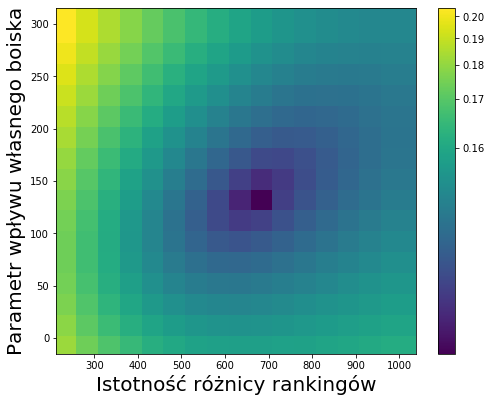

In [245]:
def graph2(data,xlabel,ylabel,col,save,s):
    fig,ax=plt.subplots(figsize=(7.8,6))
    plt.subplots_adjust(left=0.1,right=0.9,top=0.9,bottom=0.1)
    plot=ax.scatter(x='sensitivity', y='home_buff', data=data, 
                    c=col, cmap = "viridis", s = s, marker = "s",norm=matplotlib.colors.PowerNorm(gamma=0.3))
    #set_size(6,6)
    plt.colorbar(plot)
    ax.set_xlabel(xlabel,size=20)
    ax.set_ylabel(ylabel,size=20)
    fig.savefig(save+".png",dpi=200)
    
graph2(data=markov_scores.loc[markov_scores['alpha'] == 0.82,:],
      xlabel="Istotność różnicy rankingów",
      ylabel="Parametr wpływu własnego boiska",col="MSE",save="MSEvalmarkow",s=1300)
plt.show()

In [41]:
#aktualne

MSE = pd.DataFrame({'alpha' : [], 'sensitivity': [], 'home_buff': [], 'MSE': [], 'nr_mse': []})

i = 0

for alpha in range(80, 100, 2):
    for sensitivity in range(250, 1050, 50):
        for home_buff in range(0, 320, 20):
            se = 0
            nr_se = 4000

            #inicjuje macierze
            G_markovian_loop2 = G_markovian_start2.copy()
            Markovian_loop2 = Markovian_start2.copy()
            Markovian_with_E2 = markovian_with_E(alpha/100, Markovian_loop2, countries)

            for index, row in df_markovian.tail(8000).head(4000).iterrows():
                try:
                    #wyliczam ranking i prawdopodobienstwo ze starych macierzy
                    Max = np.max(np.abs(solve_ranking(alpha/100, Markovian_with_E2, countries)))
                    Min = np.min(np.abs(solve_ranking(alpha/100, Markovian_with_E2, countries)))
                    ranking_df = pd.DataFrame({'country': countries, 'rank': np.abs(solve_ranking(alpha/100, Markovian_with_E2, countries))/(Max-Min)*1000})

                    if(row['neutral']==False):
                        prob = probability_markovian(sensitivity, home_buff, ranking_df, row['home_team'], row['away_team'], 1)
                    else:
                        prob = probability_markovian(sensitivity, home_buff, ranking_df, row['home_team'], row['away_team'], 0)
                    se = se + (prob-df_markovian.at[index, 'W_home'])**2

                except np.linalg.LinAlgError as err:
                    if 'Singular matrix' in str(err):
                        nr_se = nr_se - 1

                #nowe macierze na nastepna petle
                G_markovian_loop2 = update_G_markovian2(df_markovian, index, G_markovian_loop2, countries)
                Markovian_loop2 = markovian2(G_markovian_loop2, countries)
                Markovian_with_E2 = markovian_with_E(alpha/100, Markovian_loop2, countries)

            df2 = {'alpha': alpha/100, 'sensitivity': sensitivity, 'home_buff': home_buff, 'MSE': se/nr_se, 'nr_mse': nr_se}

            MSE = MSE.append(df2, ignore_index = True)

            i = i+1
            print(i, '/60', alpha/100, sensitivity, home_buff, se/nr_se, nr_se)

1 /60 0.8 1000 200 0.1528681732341694 3989


KeyboardInterrupt: 

In [255]:
se = 0
nr_se = 4000

#inicjuje macierze
actual_scores2 = df_markovian.tail(8000).head(4000)

G_markovian_loop2 = g_markovian2(actual_scores2, countries)
Markovian_loop2 = markovian2(G_markovian_start2, countries)
Markovian_with_E2 = markovian_with_E(0.82, Markovian_loop2, countries)

for index, row in df_markovian.tail(4000).iterrows():
    try:
        #wyliczam ranking i prawdopodobienstwo ze starych macierzy
        Max = np.max(np.abs(solve_ranking(0.82, Markovian_with_E2, countries)))
        Min = np.min(np.abs(solve_ranking(0.82, Markovian_with_E2, countries)))
        ranking_df = pd.DataFrame({'country': countries, 'rank': np.abs(solve_ranking(0.82, Markovian_with_E2, countries))/(Max-Min)*1000})

        if(row['neutral']==False):
            prob = probability_markovian(700, 140, ranking_df, row['home_team'], row['away_team'], 1)
        else:
            prob = probability_markovian(700, 140, ranking_df, row['home_team'], row['away_team'], 0)
        se = se + (prob-df_markovian.at[index, 'W_home'])**2

    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            nr_se = nr_se - 1

    #nowe macierze na nastepna petle
    G_markovian_loop2 = update_G_markovian2(df_markovian, index, G_markovian_loop2, countries)
    Markovian_loop2 = markovian2(G_markovian_loop2, countries)
    Markovian_with_E2 = markovian_with_E(0.82, Markovian_loop2, countries)

MSE = se/nr_se

In [256]:
MSE

0.14655723270267584

In [260]:
ranking_markov = ranking_df.sort_values(by=['rank'], ascending=False)

In [284]:
ranking_markov = ranking_df.sort_values(by=['rank'], ascending=False)
ranking_markov.set_index('country', inplace = True)
ranking_markov.index.name = None
ranking_markov = ranking_markov.rename(columns={'rank':'Ranking'}).drop([
    'Felvidék','Galicia', 'Frøya', 'Greenland', 'Falkland Islands', 'Saint Pierre and Miquelon', 'Réunion',
    'Vatican City', 'Provence', 'Iraqi Kurdistan', 'Western Sahara', 'Kiribati', 'Åland Islands',
    'Isle of Wight', 'Two Sicilies', 'Madrid', 'Menorca', 'Rhodes', 'Romani people', 'Occitania',
    'Mayotte', 'County of Nice', 'Darfur', 'Saare County', 'Corsica', 'Brittany', 'Andalusia', 'Raetia',
    'Gotland', 'Arameans Suryoye', 'Gozo', 'Somaliland', 'Northern Mariana Islands', 'Catalonia'])
ranking_markov.Ranking = ranking_markov.Ranking.astype(int)
ranking_markov = ranking_markov.loc[ranking_markov['Ranking']>0]
ranking_markov2 = ranking_markov.head().append(pd.DataFrame({'index':['...'],'Ranking':['...']}).set_index('index')).append(ranking_markov.tail())
dfi.export(ranking_markov2, 'ranking_markov.png')

# ELORATINGS.NET

In [231]:
df_elonet = df.copy()
df_elonet = tournament(20, 30, 40, 50, 60, 30, df_elonet)
df_elonet["diff"] = df["home_score"] - df["away_score"]

conditions = [
    (df_elonet["diff"] > 0),
    (df_elonet["diff"] == 0),
    (df_elonet["diff"] < 0)
    ]

values = [1,0.5,0]

df_elonet["W_home"] = np.select(conditions, values)
df_elonet

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,I,diff,W_home
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,20,0,0.5
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,20,2,1.0
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,20,1,1.0
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,20,0,0.5
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,20,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False,40,2,1.0
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False,40,2,1.0
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False,40,1,1.0
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False,40,1,1.0


In [232]:
df_elonet["goals_buff_home"] = 1
df_elonet["goals_buff_away"] = 1

for i, row in df_elonet.iterrows():
    if row["diff"]>=4:
        df_elonet.loc[i,"goals_buff_home"] = 1+3/4+(row["diff"]-3)/8
    elif row["diff"]==3:
        df_elonet.loc[i,"goals_buff_home"] = 1 + 3/4
    elif row['diff']==2:
        df_elonet.loc[i,"goals_buff_home"] = 1 + 1/2
    elif row["diff"]<=-4:
        df_elonet.loc[i,"goals_buff_away"] = 1+3/4+(-row["diff"]-3)/8
    elif row["diff"]==-3:
        df_elonet.loc[i,"goals_buff_away"] = 1 + 3/4
    elif row['diff']==-2:
        df_elonet.loc[i,"goals_buff_away"] = 1 + 1/2

df_elonet

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,I,diff,W_home,goals_buff_home,goals_buff_away
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,20,0,0.5,1.00,1.0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,20,2,1.0,1.50,1.0
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,20,1,1.0,1.00,1.0
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,20,0,0.5,1.00,1.0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,20,3,1.0,1.75,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0,FIFA World Cup qualification,Mexico City,Mexico,False,40,2,1.0,1.50,1.0
43417,2022-03-30,Costa Rica,United States,2,0,FIFA World Cup qualification,San José,Costa Rica,False,40,2,1.0,1.50,1.0
43418,2022-03-30,Panama,Canada,1,0,FIFA World Cup qualification,Panama City,Panama,False,40,1,1.0,1.00,1.0
43419,2022-03-30,Jamaica,Honduras,2,1,FIFA World Cup qualification,Kingston,Jamaica,False,40,1,1.0,1.00,1.0


In [233]:
def estymuj_elonet(df, importance_diff_ranking = 10, sensitivity_diff_ranking = 400, home_buff = 100):
    df["We_home"] = 0

    a = pd.unique(df["home_team"])
    b = pd.unique(df["away_team"])
    countries = np.unique(np.concatenate((a,b),0))
    
    ranking = dict()
    for i in countries:
        ranking[i] = 1200;
        
    for i, row in df.iterrows():
        rank_home_before = ranking[df.loc[i,"home_team"]]
        rank_away_before = ranking[df.loc[i,"away_team"]]
        if(df.loc[i,'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before+home_buff)/sensitivity_diff_ranking))
        else:
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before)/sensitivity_diff_ranking))
            
        ranking[df.loc[i,"home_team"]] = int(rank_home_before + df.loc[i,"I"]*df.loc[i,"goals_buff_home"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
        ranking[df.loc[i,"away_team"]] = int(rank_away_before + df.loc[i,"I"]*df.loc[i,"goals_buff_away"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))

    df["W_home-We_home"] = df["W_home"]-df["We_home"]
    
    df_1loop = df.copy()
    ranking_1loop = ranking.copy()
    
    for i, row in df.iterrows():
        rank_home_before = ranking[df.loc[i,"home_team"]]
        rank_away_before = ranking[df.loc[i,"away_team"]]
        if(df.loc[i,'neutral'] == False):
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before+home_buff)/sensitivity_diff_ranking))
        else:
            df.loc[i,"We_home"] = 1/(1+importance_diff_ranking**(-(rank_home_before-rank_away_before)/sensitivity_diff_ranking))
        
        ranking[df.loc[i,"home_team"]] = int(rank_home_before + df.loc[i,"I"]*df.loc[i,"goals_buff_home"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
        ranking[df.loc[i,"away_team"]] = int(rank_away_before + df.loc[i,"I"]*df.loc[i,"goals_buff_away"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))
    
    df["W_home-We_home"] = df["W_home"]-df["We_home"]
    
    return(df, df_1loop, ranking, ranking_1loop)

In [234]:
df_elonet, df_elonet_1loop, ranking_elonet, _ = estymuj_elonet(df_elonet)

In [235]:
import operator
sorted(ranking_elonet.items(), key=operator.itemgetter(1), reverse=True)

[('Brazil', 2532),
 ('Argentina', 2486),
 ('France', 2442),
 ('Belgium', 2424),
 ('England', 2381),
 ('Spain', 2369),
 ('Italy', 2338),
 ('Uruguay', 2338),
 ('Germany', 2330),
 ('Portugal', 2318),
 ('Netherlands', 2293),
 ('Colombia', 2292),
 ('Denmark', 2290),
 ('Switzerland', 2277),
 ('Peru', 2258),
 ('Ecuador', 2247),
 ('Yugoslavia', 2246),
 ('Mexico', 2217),
 ('Croatia', 2216),
 ('Serbia', 2201),
 ('United States', 2198),
 ('Chile', 2194),
 ('Wales', 2186),
 ('Sweden', 2178),
 ('Iran', 2172),
 ('Ukraine', 2169),
 ('Czech Republic', 2161),
 ('Czechoslovakia', 2161),
 ('German DR', 2155),
 ('Japan', 2154),
 ('South Korea', 2151),
 ('Paraguay', 2149),
 ('Poland', 2148),
 ('Canada', 2147),
 ('Russia', 2136),
 ('Costa Rica', 2107),
 ('Scotland', 2093),
 ('Turkey', 2081),
 ('Venezuela', 2078),
 ('Norway', 2077),
 ('Austria', 2076),
 ('Hungary', 2072),
 ('Finland', 2058),
 ('Bolivia', 2053),
 ('Republic of Ireland', 2046),
 ('Morocco', 2045),
 ('Slovakia', 2043),
 ('Basque Country', 2042)

In [68]:
print("MSE walidacyjny 1 petla: ", MSE(df_elonet_1loop.tail(20000).head(16000), 4000))
print("MSE walidacyjny: ", MSE(df_elonet.tail(20000).head(16000), 4000))
print("MSE test: ", MSE(df_elonet, 4000))

MSE walidacyjny 1 petla:  0.13517
MSE walidacyjny:  0.13368
MSE test:  0.12684


In [13]:
save_rank(ranking_elonet,'ranking_elonet')

# Predykcja MŚ2022

In [180]:
ranking_own = estymuj_arek(df_own, 10, 200, 40)[2]#wyniki(df_own,10,300,70)[2] #nie dokladny bo liczy przed poissonem chyba ze mowic ze poisson to upgrade

                   0
conf                
Asia     1156.292683
Europa   1241.400000
NA       1177.525000
Oceania  1170.384615
SA       1348.300000
rest     1195.043478 1177 1241


In [79]:
def estymuj_ms2022(df, ranking_own):
        
    for i, row in df.iterrows():
        rank_home_before = ranking_own[df.loc[i,"home_team"]]
        rank_away_before = ranking_own[df.loc[i,"away_team"]]
        df.loc[i,"We_home"] = 1/(1+10**(-(rank_home_before-rank_away_before)/250))  #bez +40 buff bo neutral
        df.loc[i,"We_away"] = 1 - df.loc[i,"We_home"]
        
        #na razie bez aktualizacji bo W_home nie ma w QF itp
        #ranking_own[df.loc[i,"home_team"]] = int(rank_home_before + df.loc[i,"I"]*(df.loc[i,"W_home"]-df.loc[i,"We_home"]))
        #ranking_own[df.loc[i,"away_team"]] = int(rank_away_before + df.loc[i,"I"]*((1-df.loc[i,"W_home"])-(1-df.loc[i,"We_home"])))

    return(df, ranking_own)

In [80]:
def poisson_grupa(df_grupa):
    df = df_grupa.copy()
    suma = 0
    draw = 0
    
    for i in range(2,4):
        df['We_home'+str(i)] = df['We_home']**i
        df['We_away'+str(i)] = df['We_away']**i

    df['home_goals'] = 0.
    df['away_goals'] = 0.
    
    for index, row in df.iterrows():
        if (row['neutral']==True) and (row['We_home']>=0.8):
            df.at[index, 'home_goals'] = neutral(row['We_home'])
            df.at[index, 'away_goals'] = float(best_model_split_neutral.predict([row[['We_away','We_away2']].to_list()]))
        elif (row['neutral']==True) and (row['We_away']>=0.8):
            df.at[index, 'away_goals'] = neutral(row['We_away'])
            df.at[index, 'home_goals'] = float(best_model_split_neutral.predict([row[['We_home','We_home2']].to_list()]))
        elif (row['neutral']==False) and (row['We_home']>0.07):
            df.at[index, 'away_goals'] = best_model_split_away.predict([row[['We_home','We_home2','We_home3']].to_list()])
            if(row['We_home']<0.93):
                df.at[index, 'home_goals'] = best_model_split.predict([row[['We_home','We_home2','We_home3']].to_list()])
            else:
                df.at[index, 'home_goals'] = home_big_we_home(row['We_home'])
        elif (row['neutral']==False) and (row['We_home']<=0.07):
            df.at[index, 'home_goals'] = best_model_split.predict([row[['We_home','We_home2','We_home3']].to_list()])
            df.at[index, 'away_goals'] = away_small_we_home(row['We_home'])
        else:
            df.at[index, 'home_goals'] = float(best_model_split_neutral.predict([row[['We_home','We_home2']].to_list()]))
            df.at[index, 'away_goals'] = float(best_model_split_neutral.predict([row[['We_away','We_away2']].to_list()]))

        for away in range(30):
            for home in range(away, 30):
                if(away!=home):
                    suma = suma + poisson.pmf(home, df.at[index, 'home_goals'])*poisson.pmf(away, df.at[index, 'away_goals'])
                else:
                    draw = draw + poisson.pmf(home, df.at[index, 'home_goals'])*poisson.pmf(away, df.at[index, 'away_goals'])
                   
        wynik = np.random.uniform()
        if(wynik <= suma):
            df.at[index,'W_home'] = 3
            df.at[index,'W_away'] = 0
            suma = 0
            draw = 0
            continue
        elif(wynik > suma and wynik <= suma+draw):
            df.at[index,'W_home'] = 1
            df.at[index,'W_away'] = 1
        else:
            df.at[index,'W_home'] = 0
            df.at[index,'W_away'] = 3

        suma = 0
        draw = 0
        
    return(df)

In [81]:
def poisson_not_draw(df_grupa):
    df = df_grupa.copy()
    suma = 0
    draw = 0
    
    for i in range(2,4):
        df['We_home'+str(i)] = df['We_home']**i
        df['We_away'+str(i)] = df['We_away']**i

    df['home_goals'] = 0.
    df['away_goals'] = 0.
    
    for index, row in df.iterrows():
        if (row['neutral']==True) and (row['We_home']>=0.8):
            df.at[index, 'home_goals'] = neutral(row['We_home'])
            df.at[index, 'away_goals'] = float(best_model_split_neutral.predict([row[['We_away','We_away2']].to_list()]))
        elif (row['neutral']==True) and (row['We_away']>=0.8):
            df.at[index, 'away_goals'] = neutral(row['We_away'])
            df.at[index, 'home_goals'] = float(best_model_split_neutral.predict([row[['We_home','We_home2']].to_list()]))
        elif (row['neutral']==False) and (row['We_home']>0.07):
            df.at[index, 'away_goals'] = best_model_split_away.predict([row[['We_home','We_home2','We_home3']].to_list()])
            if(row['We_home']<0.93):
                df.at[index, 'home_goals'] = best_model_split.predict([row[['We_home','We_home2','We_home3']].to_list()])
            else:
                df.at[index, 'home_goals'] = home_big_we_home(row['We_home'])
        elif (row['neutral']==False) and (row['We_home']<=0.07):
            df.at[index, 'home_goals'] = best_model_split.predict([row[['We_home','We_home2','We_home3']].to_list()])
            df.at[index, 'away_goals'] = away_small_we_home(row['We_home'])
        else:
            df.at[index, 'home_goals'] = float(best_model_split_neutral.predict([row[['We_home','We_home2']].to_list()]))
            df.at[index, 'away_goals'] = float(best_model_split_neutral.predict([row[['We_away','We_away2']].to_list()]))

        for away in range(30):
            for home in range(away, 30):
                if(away!=home):
                    suma = suma + poisson.pmf(home, df.at[index, 'home_goals'])*poisson.pmf(away, df.at[index, 'away_goals'])
                else:
                    draw = draw + poisson.pmf(home, df.at[index, 'home_goals'])*poisson.pmf(away, df.at[index, 'away_goals'])
                    
        while(True):
            wynik = np.random.uniform()
            if(wynik <= suma or wynik > suma+draw):
                break
                
        if(wynik <= suma):
            df.at[index,'W_home'] = 3
            df.at[index,'W_away'] = 0
            df.at[index,'winner'] = df.at[index,'home_team']
        else:
            df.at[index,'W_home'] = 0
            df.at[index,'W_away'] = 3
            df.at[index,'winner'] = df.at[index,'away_team']

        suma = 0
        draw = 0
        
    return(df)

In [82]:
def make_group(countries):
    return(pd.DataFrame({'home_team' : [countries[0], countries[2], countries[3], countries[0], countries[3], countries[1]],
                          'away_team' : [countries[1], countries[3], countries[1], countries[2], countries[0], countries[2]],
                          'We_home': 0, 'We_away': 0, 'W_home': 0, 'W_away': 0, 'I': 50, 'neutral': True}))
    
A = make_group(['Qatar', 'Ecuador', 'Senegal', 'Netherlands'])
B = make_group(['England', 'Iran', 'United States', 'Wales'])
C = make_group(['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'])
D = make_group(['France', 'Australia', 'Denmark', 'Tunisia'])
E = make_group(['Spain', 'Costa Rica', 'Germany', 'Japan'])
F = make_group(['Belgium', 'Canada', 'Morocco', 'Croatia'])
G = make_group(['Brazil', 'Serbia', 'Switzerland', 'Cameroon'])
H = make_group(['Portugal', 'Ghana', 'Uruguay', 'South Korea'])

R16 = pd.DataFrame({'index': list(range(8)), 'home_team': ['']*8, 'away_team': ['']*8, 'We_home': np.zeros(8), 'We_away': np.zeros(8), 'winner': ['']*8, 'I': 50, 'neutral': True})
QF = pd.DataFrame({'index': list(range(4)), 'home_team': ['']*4, 'away_team': ['']*4, 'We_home': np.zeros(4), 'We_away': np.zeros(4), 'winner': ['']*4, 'I': 50, 'neutral': True})
SF = pd.DataFrame({'index': list(range(2)), 'home_team': ['']*2, 'away_team': ['']*2, 'We_home': np.zeros(2), 'We_away': np.zeros(2), 'winner': ['']*2, 'I': 50, 'neutral': True})
Final = pd.DataFrame({'index': 1, 'home_team': [''], 'away_team': [''], 'We_home': 0, 'We_away': 0, 'winner': [''], 'I': 50, 'neutral': True})

In [181]:
results = pd.DataFrame({'team' : ['Qatar', 'Ecuador', 'Senegal', 'Netherlands', 'England', 'Iran', 'United States', 'Wales',
                                  'Argentina', 'Saudi Arabia', 'Mexico', 'Poland', 'France', 'Australia', 'Denmark', 'Tunisia',
                                  'Spain', 'Costa Rica', 'Germany', 'Japan', 'Belgium', 'Canada', 'Morocco', 'Croatia',
                                  'Brazil', 'Serbia', 'Switzerland', 'Cameroon','Portugal', 'Ghana', 'Uruguay', 'South Korea'],
                        'out_group': 0, 'QF': 0, 'SF': 0, 'Final': 0, 'Winner': 0})

groups = [A, B, C, D, E, F, G, H]

R16order = [0, 4, 4, 0, 1, 5, 5, 1, 2, 6, 6, 2, 3, 7, 7, 3]
home_away_notation = ['home_team', 'away_team']*8


for i in range(100):
    print(str(i+1)+'/100')
    ranking = ranking_own.copy() #zrobic ranking
    i_R16order = 0

    for gr in groups:

        gr, ranking = estymuj_ms2022(gr, ranking) #nie wiem czy nadpisanie gr dziala

        gr = poisson_grupa(gr)
        #print(gr)
        grup_sort = pd.DataFrame(gr.groupby(['home_team']).sum()['W_home']+gr.groupby(['away_team']).sum()['W_away']).sort_values(by=[0], ascending = False)
        #print(grup_sort)
        R16.loc[R16order[i_R16order], [home_away_notation[i_R16order]]] = grup_sort.index[0]
        results.loc[results['team'] == grup_sort.index[0], ['out_group']] += 1
        i_R16order += 1
        R16.loc[R16order[i_R16order], [home_away_notation[i_R16order]]] = grup_sort.index[1]
        results.loc[results['team'] == grup_sort.index[1], ['out_group']] += 1
        i_R16order += 1

    R16, ranking = estymuj_ms2022(R16, ranking)

    #poisson zwracajacy wynik inny niz remis i wrzucajacy zwyciezce do winner oraz dodawac im do results
    R16 = poisson_not_draw(R16)
    for index, row in R16.iterrows():
        results.loc[results['team'] == R16.at[index,'winner'], ['QF']] += 1

    for i in range(4):
        QF.loc[i, ['home_team']] = R16.loc[2*i, ['winner']].values
        QF.loc[i, ['away_team']] = R16.loc[2*i+1, ['winner']].values

    QF, ranking = estymuj_ms2022(QF, ranking)

    #poisson zwracajacy wynik inny niz remis i wrzucajacy zwyciezce do winner oraz dodawac im do results
    QF = poisson_not_draw(QF)
    for index, row in QF.iterrows():
        results.loc[results['team'] == QF.at[index,'winner'], ['SF']] += 1

    for i in range(2):
        SF.loc[i, ['home_team']] = QF.loc[2*i, ['winner']].values
        SF.loc[i, ['away_team']] = QF.loc[2*i+1, ['winner']].values

    SF, ranking = estymuj_ms2022(SF, ranking)

    #poisson zwracajacy wynik inny niz remis i wrzucajacy zwyciezce do winner oraz dodawac im do results
    SF = poisson_not_draw(SF)
    for index, row in SF.iterrows():
        results.loc[results['team'] == SF.at[index,'winner'], ['Final']] += 1

    Final.loc[0, ['home_team']] = SF.loc[0, ['winner']].values
    Final.loc[0, ['away_team']] = SF.loc[1, ['winner']].values

    Final, ranking = estymuj_ms2022(Final, ranking)

    #poisson zwracajacy wynik inny niz remis i wrzucajacy zwyciezce do winner oraz dodawac im do results
    Final = poisson_not_draw(Final)
    results.loc[results['team'] == Final.at[0,'winner'], ['Winner']] += 1

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


In [33]:
import operator
sorted(ranking_own.items(), key=operator.itemgetter(1), reverse=True)

[('Brazil', 1398),
 ('Argentina', 1390),
 ('France', 1380),
 ('Belgium', 1359),
 ('Spain', 1319),
 ('England', 1317),
 ('Jersey', 1311),
 ('Italy', 1307),
 ('Guernsey', 1302),
 ('Padania', 1295),
 ('Isle of Man', 1288),
 ('Portugal', 1284),
 ('Northern Cyprus', 1281),
 ('Uruguay', 1281),
 ('Mexico', 1279),
 ('Germany', 1274),
 ('United States', 1267),
 ('Netherlands', 1260),
 ('Colombia', 1257),
 ('Switzerland', 1257),
 ('County of Nice', 1255),
 ('Abkhazia', 1253),
 ('Iraqi Kurdistan', 1250),
 ('Kárpátalja', 1249),
 ('Iran', 1246),
 ('Denmark', 1245),
 ('Réunion', 1244),
 ('Andalusia', 1233),
 ('Canada', 1233),
 ('Basque Country', 1231),
 ('Kernow', 1230),
 ('Peru', 1229),
 ('Menorca', 1227),
 ('Yorkshire', 1224),
 ('Japan', 1223),
 ('Arameans Suryoye', 1222),
 ('South Korea', 1221),
 ('Occitania', 1219),
 ('Rhodes', 1219),
 ('Croatia', 1218),
 ('Artsakh', 1215),
 ('Costa Rica', 1215),
 ('Ellan Vannin', 1215),
 ('Panjab', 1215),
 ('Chameria', 1214),
 ('Cascadia', 1213),
 ('New Zealand

In [182]:
results

,team,out_group,QF,SF,Final,Winner
0,Qatar,26,6,1,0,0
1,Ecuador,66,25,8,4,1
2,Senegal,27,5,0,0,0
3,Netherlands,81,35,12,5,2
4,England,87,68,31,17,8
5,Iran,39,22,5,3,2
6,United States,48,23,8,3,0
7,Wales,26,16,7,2,1
8,Argentina,98,69,49,31,18
9,Saudi Arabia,9,0,0,0,0


In [25]:
def make_group(countries):
    return(pd.DataFrame({'home_team' : [countries[0], countries[2], countries[3], countries[0], countries[3], countries[1]],
                          'away_team' : [countries[1], countries[3], countries[1], countries[2], countries[0], countries[2]],
                          'We_home': [3,2,1,2,3,1], 'We_away': [3,3,1,1,2,2]}))
    
print(A)
A = make_group(['Oatar', 'Ecuador', 'Senegal', 'Netherlands'])
pd.DataFrame(A.groupby(['home_team']).sum()['We_home']+A.groupby(['away_team']).sum()['We_away']).sort_values(by=[0], ascending = False).index[0]

     home_team    away_team  We_home  We_away
0        Oatar      Ecuador        3        3
1      Senegal  Netherlands        2        3
2  Netherlands      Ecuador        1        1
3        Oatar      Senegal        2        1
4  Netherlands        Oatar        3        2
5      Ecuador      Senegal        1        2


'Netherlands'

#################################################################
#STARE
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################

In [ ]:
mu, sigma = st.norm.fit(df_with_diff["W_home-We_home"].tail(10000).append(-df_with_diff["W_home-We_home"].tail(10000)))

plt.hist(df_with_diff["W_home-We_home"].tail(10000).append(-df_with_diff["W_home-We_home"].tail(10000)),density = 1, bins = 100)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = st.norm.pdf(x, mu, sigma)

plt.plot(x, p, 'k', linewidth=2)

print("mu: ",mu,"\nsigma: ",sigma)
#df_test = df2.tail(10000)
df_test = df_with_diff.tail(10000)[df_with_diff.tail(10000)["W_home"] != 0.5]
ilosc_dobrych = 0
for i,row in df_test.iterrows():
    if((df_test.loc[i,"W_home"]==1 and df_test.loc[i,"We_home"]>0.5) or
      (df_test.loc[i,"W_home"]==0 and df_test.loc[i,"We_home"]<0.5)):
        ilosc_dobrych += 1 

ilosc_dobrych = ilosc_dobrych/len(df_test["We_home"])
print("Czesc dobrych zwyciestw: ", ilosc_dobrych)

plt.hist(df_with_diff["W_home-We_home"].tail(10000).append(-df_with_diff["W_home-We_home"].tail(10000)),density = 1, bins = 100)
plt.show()
print("SE: ", np.sum(df_with_diff["W_home-We_home"].tail(10000)**2))

In [41]:
ranking2 = dict()
for i in countries:
    ranking2[i] = 1200;

    
    
conditions = [
    (df_gosp["diff"] > 0),
    (df_gosp["diff"] == 0),
    (df_gosp["diff"] < 0)
    ]

values = [1,0.5,0]

df_gosp["W_home"] = np.select(conditions, values)

df_gosp["We_home"] = 0

for i, row in df_gosp.iterrows():
    rank_home_before = ranking2[df_gosp.loc[i,"home_team"]]
    rank_away_before = ranking2[df_gosp.loc[i,"away_team"]]
    if(df_gosp.loc[i,"neutral"] == False):
        df_gosp.loc[i,"We_home"] = 1/(1+10**(-(rank_home_before-rank_away_before+50)/600))
    else:
        df_gosp.loc[i,"We_home"] = 1/(1+10**(-(rank_home_before-rank_away_before)/600))
    
    ranking2[df_gosp.loc[i,"home_team"]] = int(rank_home_before + df_gosp.loc[i,"I"]*(df_gosp.loc[i,"W_home"]-df_gosp.loc[i,"We_home"]))
    ranking2[df_gosp.loc[i,"away_team"]] = int(rank_away_before + df_gosp.loc[i,"I"]*((1-df_gosp.loc[i,"W_home"])-(1-df_gosp.loc[i,"We_home"])))
    
df_gosp["W_home-We_home"] = df_gosp["W_home"]-df_gosp["We_home"]
df_gosp

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,diff,I,W_home,We_home,W_home-We_home
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,10,0.5,0.547824,-0.047824
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,2.0,10,1.0,0.548774,0.451226
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,10,1.0,0.538301,0.461699
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,10,0.5,0.548774,-0.048774
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,3.0,10,1.0,0.547824,0.452176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42352,2021-06-23,Sweden,Poland,3.0,2.0,UEFA Euro,Saint Petersburg,Russia,True,1.0,40,1.0,0.565815,0.434185
42353,2021-06-23,Germany,Hungary,2.0,2.0,UEFA Euro,Munich,Germany,False,0.0,40,0.5,0.822745,-0.322745
42354,2021-06-23,Portugal,France,2.0,2.0,UEFA Euro,Budapest,Hungary,True,0.0,40,0.5,0.391424,0.108576
42355,2021-06-23,Ecuador,Peru,2.0,2.0,Copa América,Goiânia,Brazil,True,0.0,40,0.5,0.418232,0.081768


mu:  -2.842170943040401e-18 
sigma:  0.3856618516944088
Czesc dobrych zwyciestw:  0.4866596913418781


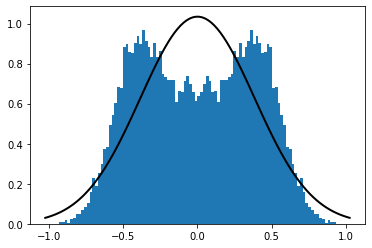

In [42]:
mu_gosp, sigma_gosp = st.norm.fit(df_gosp["W_home-We_home"].tail(10000).append(-df_gosp["W_home-We_home"].tail(10000)))

plt.hist(df_gosp["W_home-We_home"].tail(10000).append(-df_gosp["W_home-We_home"].tail(10000)),density = 1, bins = 100)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = st.norm.pdf(x, mu_gosp, sigma_gosp)

plt.plot(x, p, 'k', linewidth=2)

print("mu: ",mu_gosp,"\nsigma: ",sigma_gosp)

df_test_gosp = df_gosp.tail(10000)[df_gosp.tail(10000)["W_home"] != 0.5]
ilosc_dobrych_gosp = 0
for i,row in df_test_gosp.iterrows():
    if(df_test_gosp.loc[i,"W_home"]==1 and df_test_gosp.loc[i,"We_home"]>0.5):
        ilosc_dobrych_gosp += 1 

ilosc_dobrych_gosp = ilosc_dobrych_gosp/len(df_test_gosp["W_home"]) 
print("Czesc dobrych zwyciestw: ", ilosc_dobrych_gosp)

In [43]:
sigma_gosp-sigma #poprawka sprawila nieznaczne poprawienie

-0.006767381143964135

In [45]:
ranking3 = dict()
for i in countries:
    ranking3[i] = 1200;

    
    
conditions = [
    (df_own["diff"] > 0),
    (df_own["diff"] == 0),
    (df_own["diff"] < 0)
    ]

values = [1,0.5,0]

df_own["W_home"] = np.select(conditions, values)

df_own["We_home"] = 0

for i, row in df_own.iterrows():
    rank_home_before = ranking3[df_own.loc[i,"home_team"]]
    rank_away_before = ranking3[df_own.loc[i,"away_team"]]
    if df_own.loc[i, "neutral"] == False:
        df_own.loc[i,"We_home"] = 1/(1+24**(-(rank_home_before-rank_away_before+50)/500))
    else:
        df_own.loc[i,"We_home"] = 1/(1+24**(-(rank_home_before-rank_away_before)/500))
    
    ranking3[df_own.loc[i,"home_team"]] = int(rank_home_before + 1.07**(abs(df_own.loc[i,"diff"]))*df_own.loc[i,"I"]*(df_own.loc[i,"W_home"]-df_own.loc[i,"We_home"]))
    ranking3[df_own.loc[i,"away_team"]] = int(rank_away_before + 1.07**(abs(df_own.loc[i,"diff"]))*df_own.loc[i,"I"]*((1-df_own.loc[i,"W_home"])-(1-df_own.loc[i,"We_home"])))
    
df_own["W_home-We_home"] = df_own["W_home"]-df_own["We_home"]
df_own

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,diff,I,W_home,We_home,W_home-We_home
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,10,0.5,0.578789,-0.078789
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,2.0,10,1.0,0.580338,0.419662
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,10,1.0,0.563221,0.436779
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,10,0.5,0.580338,-0.080338
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,3.0,10,1.0,0.578789,0.421211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42352,2021-06-23,Sweden,Poland,3.0,2.0,UEFA Euro,Saint Petersburg,Russia,True,1.0,50,1.0,0.639236,0.360764
42353,2021-06-23,Germany,Hungary,2.0,2.0,UEFA Euro,Munich,Germany,False,0.0,50,0.5,0.829582,-0.329582
42354,2021-06-23,Portugal,France,2.0,2.0,UEFA Euro,Budapest,Hungary,True,0.0,50,0.5,0.318053,0.181947
42355,2021-06-23,Ecuador,Peru,2.0,2.0,Copa América,Goiânia,Brazil,True,0.0,50,0.5,0.374058,0.125942


In [51]:
2**(1/10) #zeby 10 goli dawalo mnoznik 2

1.0717734625362931

mu:  1.4210854715202004e-18 
sigma:  0.3770580101719048
Czesc dobrych zwyciestw:  0.7427413026419043


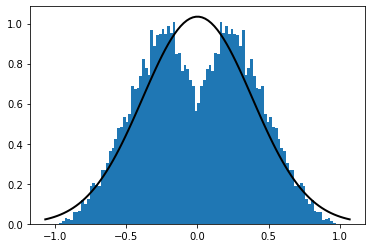

In [46]:
mu_own, sigma_own = st.norm.fit(df_own["W_home-We_home"].tail(10000).append(-df_own["W_home-We_home"].tail(10000)))

plt.hist(df_own["W_home-We_home"].tail(10000).append(-df_own["W_home-We_home"].tail(10000)),density = 1, bins = 100)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = st.norm.pdf(x, mu_gosp, sigma_gosp)

plt.plot(x, p, 'k', linewidth=2)

print("mu: ",mu_own,"\nsigma: ",sigma_own)

df_test_own = df_own.tail(10000)[df_own.tail(10000)["W_home"] != 0.5]
ilosc_dobrych_own = 0
for i,row in df_test_own.iterrows():
    if((df_test_own.loc[i,"W_home"]==1 and df_test_own.loc[i,"We_home"]>0.5) or
       (df_test_own.loc[i,"W_home"]==0 and df_test_own.loc[i,"We_home"]<0.5)):
        ilosc_dobrych_own += 1 

ilosc_dobrych_own = ilosc_dobrych_own/len(df_test_own["W_home"]) 
print("Czesc dobrych zwyciestw: ", ilosc_dobrych_own)

In [141]:
rezultaty2 = []
progres = 1
for importance in [math.e, 5, 10, 15, 20, 25]:
    for sensitivity in range(200, 900, 100):
        for buff in range(0, 120, 20):
            ranking2 = dict()
            for i in countries:
                ranking2[i] = 1200;
            df_est = estymuj_wyniki(df_own, ranking2, importance, sensitivity, buff)[0]
            
            df_score = df_est.tail(10000)[df_est.tail(10000)["W_home"] != 0.5]
            ilosc_dobrych = 0
            for i,row in df_score.iterrows():
                if((df_score.loc[i,"W_home"]==1 and df_score.loc[i,"We_home"]>0.5) or
                  (df_score.loc[i,"W_home"]==0 and df_score.loc[i,"We_home"]<0.5)):
                    ilosc_dobrych += 1 

            ilosc_dobrych = ilosc_dobrych/len(df_score["We_home"])
            
            rezultaty2.append([importance, sensitivity, buff, ilosc_dobrych, np.sum(df_own.tail(10000)["W_home-We_home"]**2)])

            print("Progres: ", progres, "/252\n")
            progres = progres+1
            
skutecznosc2 = pd.DataFrame(rezultaty2, columns=['importance', 'sensitivity', 'buff', 'skutecznosc', 'blad_kwadrat'])

Progres:  1 /252

Progres:  2 /252

Progres:  3 /252

Progres:  4 /252

Progres:  5 /252

Progres:  6 /252

Progres:  7 /252

Progres:  8 /252

Progres:  9 /252

Progres:  10 /252

Progres:  11 /252

Progres:  12 /252

Progres:  13 /252

Progres:  14 /252

Progres:  15 /252

Progres:  16 /252

Progres:  17 /252

Progres:  18 /252

Progres:  19 /252

Progres:  20 /252

Progres:  21 /252

Progres:  22 /252

Progres:  23 /252

Progres:  24 /252

Progres:  25 /252

Progres:  26 /252

Progres:  27 /252

Progres:  28 /252

Progres:  29 /252

Progres:  30 /252

Progres:  31 /252

Progres:  32 /252

Progres:  33 /252

Progres:  34 /252

Progres:  35 /252

Progres:  36 /252

Progres:  37 /252

Progres:  38 /252

Progres:  39 /252

Progres:  40 /252

Progres:  41 /252

Progres:  42 /252

Progres:  43 /252

Progres:  44 /252

Progres:  45 /252

Progres:  46 /252

Progres:  47 /252

Progres:  48 /252

Progres:  49 /252

Progres:  50 /252

Progres:  51 /252

Progres:  52 /252

Progres:  53 /252

Pr

In [142]:
grid_skutecznosc = skutecznosc2.sort_values(by=['skutecznosc'], ascending = False)
grid_skutecznosc.to_csv(r'/home/arek/Pulpit/magisterka/grid_skutecznosc3.csv')
#grid_skutecznosc.loc[(grid_skutecznosc['importance']==10) & (grid_skutecznosc['sensitivity']==600)]
grid_skutecznosc

,importance,sensitivity,buff,skutecznosc,blad_kwadrat
224,25.000000,400,40,0.733848,1451.974782
44,5.000000,200,40,0.733848,1451.974782
92,10.000000,300,40,0.733325,1452.719893
182,20.000000,400,40,0.733194,1452.721149
230,25.000000,500,40,0.733194,1456.975288
...,...,...,...,...,...
31,2.718282,700,20,0.701674,1580.890683
37,2.718282,800,20,0.698928,1592.787152
24,2.718282,600,0,0.698535,1580.316595
30,2.718282,700,0,0.694612,1591.749103


In [16]:
np.unique(df_with_diff['home_score'])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 24., 30., 31.])

,sumsquare_error,aic,bic,kl_div
rayleigh,0.002138,2103.208537,-526838.483860,inf
norm,0.010996,2975.767987,-474605.695420,inf
cauchy,0.021299,387.350128,-453518.798873,inf
lognorm,0.041580,446.034836,-432171.408250,inf
expon,0.049909,598.858156,-426358.597883,inf


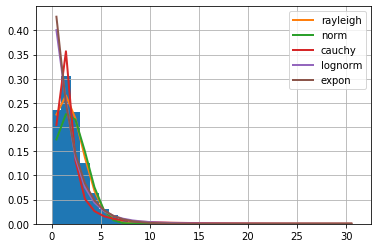

In [17]:
f = Fitter(df_own['home_score'].loc[df_own['neutral']==False],
          distributions = get_common_distributions(),
           bins = 32)
f.fit()
f.summary()

In [18]:
f.get_best()

{'rayleigh': {'loc': -0.9439364593833393, 'scale': 2.279276466642287}}

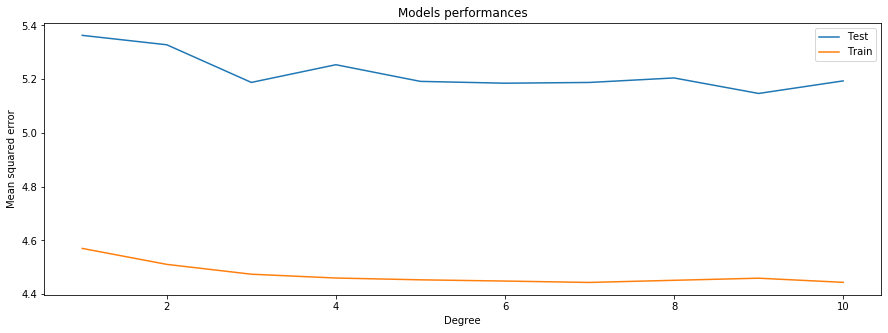

Test errors:  [5.3629946603947625, 5.327924933445113, 5.187759505025457, 5.253690991704774, 5.19164133746111, 5.184904240067655, 5.187675116197118, 5.204453220907247, 5.146737433829397, 5.193479356004523]


In [22]:
df_best_nonneutral = df_best.loc[df_best['neutral']==False]

X95 = df_best_nonneutral.loc[df_best_nonneutral['We_home']>=0.95].We_home.values.reshape(-1,1)
y95 = df_best_nonneutral.loc[df_best_nonneutral['We_home']>=0.95].home_score.values.reshape(-1,1)

errors_train = []
errors_test = []

model = LinearRegression() 

for order in range(1,11):
    
    X_train, X_test, y_train, y_test = train_test_split(X95, y95, test_size=0.3, random_state=43)
        
    poly = PolynomialFeatures(order, include_bias = False)
    X_order = poly.fit_transform(X_train)

    model.fit(X_order, y_train)
    y_to_error_train = model.predict(X_order)
    errors_train.append(mean_squared_error(y_train,y_to_error_train))

    
    X_order_test = poly.fit_transform(X_test)
    
    y_to_error_test = model.predict(X_order_test)
    errors_test.append(mean_squared_error(y_test,y_to_error_test))
    

plt.figure(figsize = (15,5)) 
plt.title("Models performances")
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.plot(range(1,11),errors_test, label = "Test")
plt.plot(range(1,11),errors_train, label = "Train")
plt.legend()
plt.show()

print("Test errors: ", errors_test)

In [23]:
poly2 = PolynomialFeatures(6, include_bias = False)
X95_2 = poly2.fit_transform(X95)

X_train, X_test, y_train, y_test = train_test_split(X95_2, y95, test_size=0.3, random_state=43)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

search = GridSearchCV(pipeline,
                      {'model__alpha': np.arange(0.1,10,0.1)},
                          cv = cv,
                          scoring = "neg_mean_squared_error",
                          verbose = 3,
                          n_jobs=-1
                      )

results_split = search.fit(X_train, y_train)
best_model_split = results_split.best_estimator_

y_pred = best_model_split.predict(X_test)
print("Mean squared error equals: {0}".format(mean_squared_error(y_pred, y_test)))
print("Score: ", best_model_split.score(X_test,y_test))

Fitting 30 folds for each of 99 candidates, totalling 2970 fits
Mean squared error equals: 5.321131107522051
Score:  0.01060369815622042


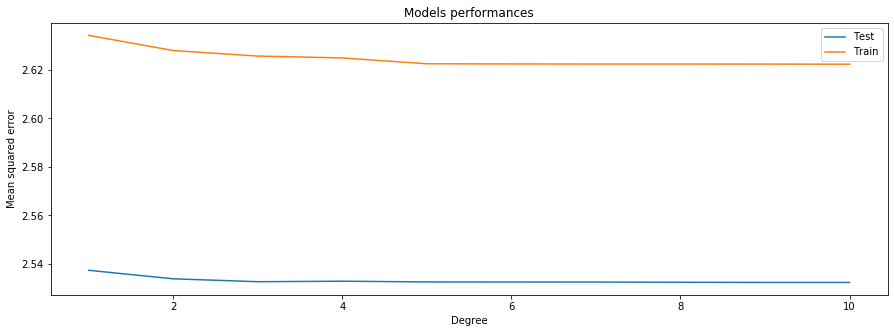

Test errors:  [2.537412323914166, 2.533903741800901, 2.5327091061502345, 2.532916059315342, 2.5326157566806056, 2.5325827625884907, 2.5325667004646633, 2.5324754925317983, 2.532404591313338, 2.532402023218375]


In [34]:
X0 = df_best_nonneutral.loc[df_best_nonneutral['We_home']<0.95].We_home.values.reshape(-1,1)
y0 = df_best_nonneutral.loc[df_best_nonneutral['We_home']<0.95].home_score.values.reshape(-1,1)


errors_train = []
errors_test = []

model = LinearRegression() 

for order in range(1,11):
    
    X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, random_state=43)
        
    poly = PolynomialFeatures(order, include_bias = False)
    X_order = poly.fit_transform(X_train)

    model.fit(X_order, y_train)
    y_to_error_train = model.predict(X_order)
    errors_train.append(mean_squared_error(y_train,y_to_error_train))

    
    X_order_test = poly.fit_transform(X_test)
    
    y_to_error_test = model.predict(X_order_test)
    errors_test.append(mean_squared_error(y_test,y_to_error_test))
    

plt.figure(figsize = (15,5)) 
plt.title("Models performances")
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.plot(range(1,11),errors_test, label = "Test")
plt.plot(range(1,11),errors_train, label = "Train")
plt.legend()
plt.show()

print("Test errors: ", errors_test)

In [35]:
poly2 = PolynomialFeatures(6, include_bias = False)
X0_2 = poly2.fit_transform(X0)

X_train, X_test, y_train, y_test = train_test_split(X0_2, y0, test_size=0.3, random_state=43)

results_split = search.fit(X_train, y_train)
best_model_split = results_split.best_estimator_

y_pred = best_model_split.predict(X_test)
print("Mean squared error equals: {0}".format(mean_squared_error(y_pred, y_test)))
print("Score: ", best_model_split.score(X_test,y_test))

Fitting 30 folds for each of 99 candidates, totalling 2970 fits
Mean squared error equals: 2.532313502795239
Score:  0.10236644522210103


In [23]:
df_markovian_val = df_markovian.tail(20000).head(16000).copy()

home_mean = df_markovian_val.groupby('neutral').mean().loc[False]['home_score']
away_mean = df_markovian_val.groupby('neutral').mean().loc[False]['away_score']
neutral_mean = np.mean(df_markovian_val.groupby('neutral').mean().loc[True])

df_markovian['home_score_modified'] = 0.
df_markovian['away_score_modified'] = 0.
for index, row in df_markovian.iterrows():
    if(df_markovian.at[index, 'neutral'] == False):
        df_markovian.at[index, 'home_score_modified'] = df_markovian.at[index, 'home_score']/home_mean
        df_markovian.at[index, 'away_score_modified'] = df_markovian.at[index, 'away_score']/away_mean
    else:
        df_markovian.at[index, 'home_score_modified'] = df_markovian.at[index, 'home_score']/neutral_mean
        df_markovian.at[index, 'away_score_modified'] = df_markovian.at[index, 'away_score']/neutral_mean
    
df_markovian

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_score_modified,away_score_modified
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.000000,0.000000
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,2.381629,1.994176
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.190815,0.997088
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,1.190815,1.994176
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.786222,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
42352,2021-06-23,Sweden,Poland,3.0,2.0,UEFA Euro,Saint Petersburg,Russia,True,2.825131,1.883421
42353,2021-06-23,Germany,Hungary,2.0,2.0,UEFA Euro,Munich,Germany,False,1.190815,1.994176
42354,2021-06-23,Portugal,France,2.0,2.0,UEFA Euro,Budapest,Hungary,True,1.883421,1.883421
42355,2021-06-23,Ecuador,Peru,2.0,2.0,Copa América,Goiânia,Brazil,True,1.883421,1.883421


In [24]:
#countries - unique countries 
#G_markovian - gole, rzedy to ile goli zdobyl dany klub przeciw temu z kolumny

actual_scores = df_markovian.tail(12000).head(4000)

def g_markovian(actual_scores, countries):

    G_markovian = np.zeros((len(countries),len(countries)))
    for index, row in actual_scores.iterrows():
        for team1 in range(len(countries)):
            if row['home_team'] == countries[team1]:
                break
        for team2 in range(len(countries)):
            if row['away_team'] == countries[team2]:
                break
        G_markovian[team1, team2] = G_markovian[team1, team2]+row['home_score_modified']
        G_markovian[team2, team1] = G_markovian[team2, team1]+row['away_score_modified']
    return(G_markovian)

G_markovian = g_markovian(actual_scores, countries)
G_markovian

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
def markovian(G_markovian, countries):
    Markovian = np.zeros((len(countries),len(countries)))
    for i in range(len(countries)):
        for j in range(len(countries)):
            if i!=j:
                Markovian[i, j] = (G_markovian[i, j]+1)/(G_markovian[i, j]+G_markovian[j, i]+2)
        Markovian[i, i] = np.sum(1-Markovian[i,:])
        Markovian[i,:] = Markovian[i,:]/len(countries)
    return(Markovian)

Markovian = markovian(G_markovian, countries)
Markovian

array([[0.50166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
        0.00166667],
       [0.00166667, 0.50575355, 0.00166667, ..., 0.00166667, 0.00166667,
        0.00166667],
       [0.00166667, 0.00166667, 0.50189909, ..., 0.00166667, 0.00166667,
        0.00166667],
       ...,
       [0.00166667, 0.00166667, 0.00166667, ..., 0.50446732, 0.00166667,
        0.00166667],
       [0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.49687476,
        0.00166667],
       [0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
        0.50166667]])

In [27]:
def update_G_markovian(df_markovian, row_index, G_markovian_old, countries):
    G_markovian_new = G_markovian_old.copy()
    for team1 in range(len(countries)):
        if df_markovian.at[row_index, 'home_team'] == countries[team1]:
            break
    for team2 in range(len(countries)):
        if df_markovian.at[row_index, 'away_team'] == countries[team2]:
            break
            
    for team1old in range(len(countries)):
        if df_markovian.at[row_index-4000, 'home_team'] == countries[team1old]:
            break
    for team2old in range(len(countries)):
        if df_markovian.at[row_index-4000, 'away_team'] == countries[team2old]:
            break
            
    G_markovian_new[team1, team2] = G_markovian_new[team1, team2]+df_markovian.at[row_index, 'home_score_modified']
    G_markovian_new[team2, team1] = G_markovian_new[team2, team1]+df_markovian.at[row_index, 'away_score_modified']
    G_markovian_new[team1old, team2old] = G_markovian_new[team1old, team2old]-df_markovian.at[row_index-4000, 'home_score_modified']
    G_markovian_new[team2old, team1old] = G_markovian_new[team2old, team1old]-df_markovian.at[row_index-4000, 'away_score_modified']
    
    return(G_markovian_new)

In [ ]:
conditions = [
    (df_markovian['home_score'] - df_markovian['away_score'] > 0),
    (df_markovian['home_score'] - df_markovian['away_score'] == 0),
    (df_markovian['home_score'] - df_markovian['away_score'] < 0)
]

values = [1,0.5,0]

df_markovian["W_home"] = np.select(conditions, values)

actual_scores = df_markovian.tail(12000).head(4000)

G_markovian_start = g_markovian(actual_scores, countries)
Markovian_start = markovian(G_markovian_start, countries)

In [40]:
MSE = pd.DataFrame({'alpha' : [], 'parameter': [], 'MSE': []})

i = 0

for alpha in range(97, 100, 1):
    for a in range(1000, 2000, 50):
        se = 0
        
        #inicjuje macierze
        G_markovian_loop = G_markovian_start
        Markovian_loop = Markovian_start
        Markovian_with_E = markovian_with_E(alpha/100, Markovian_loop, countries)
   
        for index, row in df_markovian.tail(8000).head(4000).iterrows():
            if(index%1000==356):
                print(index)
            try:
                #wyliczam ranking i prawdopodobienstwo ze starych macierzy
                ranking_df = pd.DataFrame({'country': countries, 'rank': np.abs(solve_ranking(alpha/100, Markovian_with_E, countries))/np.max(np.abs(solve_ranking(alpha/100, Markovian_with_E, countries))*15000)})
            except np.linalg.LinAlgError as err:
                if 'Singular matrix' in str(err):
                    print('singular')
                    se = -4000
                    break
                else:
                    raise
            if(row['neutral']==False):
                prob = probability_markovian(a, ranking_df, row['home_team'], row['away_team'], 1, False)
            else:
                prob = probability_markovian(a, ranking_df, row['home_team'], row['away_team'], 0, False)
            se = se + (prob-df_markovian.at[index, 'W_home'])**2
            
            #nowe macierze na nastepna petle
            G_markovian_loop = update_G_markovian(df_markovian, index, G_markovian_loop, countries)
            Markovian_loop = markovian(G_markovian_loop, countries)
            Markovian_with_E = markovian_with_E(alpha/100, Markovian_loop, countries)
            
        df2 = {'alpha': alpha/100, 'parameter': a, 'MSE': se/4000}

        MSE = MSE.append(df2, ignore_index = True)
        
        i = i+1
        print(i, '/60', alpha/100, a, se/4000)

35356
36356
37356
38356
1 /60 0.97 1000 0.18266534799142636


KeyboardInterrupt: 

In [100]:
SE2 = []
i = 0

for alpha in range(95, 100, 1):
    for a in range(1000*10**3, 1600*10**3, 200*10**3):
        se = 0
        
        #inicjuje macierze
        G_markovian_loop = G_markovian_start
        Markovian_loop = Markovian_start
        Markovian_with_E = markovian_with_E(alpha/100, Markovian_loop, countries)
            
        for index, row in df_markovian.tail(10000).iterrows():
            if(index%1000==0):
                print(index)
            
            #wyliczm ranking i prawdopodobienstwo ze starych macierzy
            ranking_df = pd.DataFrame({'country': countries, 'rank': solve_ranking(alpha/100, Markovian_with_E, countries)})
            prob = probability_markovian(a, ranking_df, row['home_team'], row['away_team'], 1, False)
            
            se = se + (prob-df_markovian.at[index, 'W_home'])**2
            
            #nowe macierze na nastepna petle
            G_markovian_loop = update_G_markovian(df_markovian, index, G_markovian_loop, countries)
            Markovian_loop = markovian(G_markovian_loop, countries)
            Markovian_with_E = markovian_with_E(alpha/100, Markovian_loop, countries)
            
        SE2.append(se)
        i = i+1
        print(i, '/60', se)

33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
1 /60 1870.047999976841
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
2 /60 1896.0878707718202
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
3 /60 1918.2787963037026
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
4 /60 2066.162454577346
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
5 /60 2076.0394738383015


KeyboardInterrupt: 

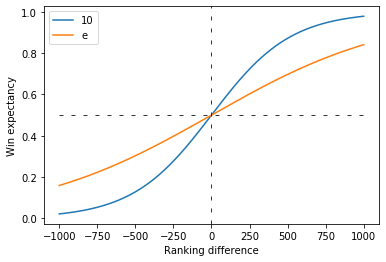

In [191]:
x = np.linspace(-1000, 1000, 1000)

plt.plot(x, 1/(1+10**(-x/600)), label = "10")
plt.plot(x, 1/(1+np.exp(-x/600)),label = "e")
plt.plot(x, 1/2*x**0, color = "black", linewidth = 0.8, linestyle =(0,(5,10)))
plt.axvline(0, color = "black", linewidth = 0.8, linestyle =(0,(5,10)))
plt.xlabel("Ranking difference")
plt.ylabel("Win expectancy")
plt.legend()
plt.show()